### Currently, this notebook is used for:
    - loading the sfMixLGN experiment data in python format
    - plotting responses
    
Last update: 20.07.16  
Last access: 21.05.18  

#### Plan: Deprecate this and copy over the relevant/novel analyses to descrAnalysesLGN

### Set up

In [3]:
import os
import numpy as np
import matplotlib
# matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.cm as cm
import seaborn as sns
import helper_fcns as hf
import autoreload
import itertools
import scipy.optimize as opt
from scipy.stats import ttest_rel as paired_ttest
from scipy.stats import ks_2samp as ks2samp
from scipy.stats import pearsonr
from scipy.stats.mstats import gmean as geomean
import LGN.sach.helper_fcns as sach_hf

import sys # so that we can import model_responses (in different folder)

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

%matplotlib inline 

base_path = os.getcwd() + '/';
expDir = 'LGN/';
dataPath = base_path + 'LGN/structures/';
sv_loc = base_path + 'figures/reports/descrLGN_210518/';

In [4]:
from matplotlib import rcParams
rcParams['font.size'] = 20
rcParams['pdf.fonttype'] = 42 # should be 42; 3 works if there are kerning issues
rcParams['ps.fonttype'] = 42 # should be 42; 3 works if there are kerning issues

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';

In [15]:
# Now, decide: are we loading/plotting just my data (0)? just Sach's data (1)? Or both (2)?
datasets = 2; 

# what model/loss for DoG? -- enforce the same loss/model for both datasets
loss_type = 2; # 1/2/3/4 -- lsq/sqrt/poiss/sach
loss_suff = '_loss%s' % hf.descrLoss_name(loss_type) # for save name ONLY
DoGmodel = 0; # 0/1/2 -- flex/sach/tony
mod_suff = '_%s' % hf.descrMod_name(DoGmodel)[0]; # just take first character
# -- but allow joint/non-joint separately (first number is for my data, second for Sach's)
is_joint = [0, 0];
# -- and which names?
fLnameBaseMine = 'descrFits_210517'
# sach_flbase = 'descrFits_s191204'
sach_flbase = 'descrFits_s210509'

# note: Sach uses 70% as his varExpl cut-off (# i.e. what is the threshold for variance explained for counting that fit/params in the analysis?)
thresh_varExpl = 70; # IF joint fits, we've already cut out the conditions we don't want to consider

#####
## no need to adjust


if datasets == 0:
    save_suff = 'mine/'
elif datasets == 1:
    save_suff = 'sach/'
elif datasets == 2:
    save_suff = 'both/';
save_loc = sv_loc + save_suff;

In [16]:
### WARNING: Slow due to loading each cell to get list of contrasts/sfs/disps

######## my data ##########

if datasets == 0 or datasets == 2:
    ### then load my data!
    dataList = hf.np_smart_load(dataPath + hf.get_datalist(expDir));
    
    ## first RVC
    dir = 1;
    rvcBase = 'rvcFits_210517';
    rvcMod = 0;
    rvcFits = hf.np_smart_load(dataPath + hf.rvc_fit_name(rvcBase, modNum=rvcMod, dir=1))
    phFits = hf.np_smart_load(dataPath + hf.phase_fit_name('phaseAdvanceFits_191023', dir));

    # -- interlude: stimulus information
    nCells = len(rvcFits.keys());
    allDisps = []; allCons = []; allSfs = []; allConByDisp =[]; allSfRef = [];

    for cellNum in range(nCells):

        cellName = dataList['unitName'][cellNum];
        cellStruct = hf.np_smart_load(dataPath +  cellName + '_sfm.npy');
        data = cellStruct['sfm']['exp']['trial'];
        expInd = hf.get_exp_ind(dataPath, cellName)[0]
        _, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(data, expInd)

        spks = hf.get_adjusted_spikerate(data, cellNum+1, expInd, dataPath, rvcBase, rvcMod, force_f1=True); #force F1, since we're in LGN
        _, _, respOrg, _ = hf.organize_resp(spks, data, expInd, respsAsRate=True);
        sfRef = respOrg[0, :, -1]; # 0 disp, highest contrast

        allDisps.append(stimVals[0])
        allCons.append(stimVals[1])
        allSfs.append(stimVals[2])
        allConByDisp.append(val_con_by_disp);
        # let's also save high contrast, single grating SF tuning
        allSfRef.append(sfRef);
    
    all_c50 = [[hf.get_c50(rvcMod, y) for y in rvcFits[x][0]['params']] if 0 in rvcFits[x] else np.nan for x in rvcFits]
    all_conGain = [np.array(rvcFits[x][0]['conGain']) if 0 in rvcFits[x] else np.nan for x in sorted(rvcFits.keys())]
    all_c50eff = [[hf.c50_empirical(rvcMod, x)[0] for x in rvcFits[x][0]['params']] if 0 in rvcFits[x] else np.nan for x in sorted(rvcFits.keys())]
    all_c50eval = [[hf.c50_empirical(rvcMod, x)[1] for x in rvcFits[x][0]['params']] if 0 in rvcFits[x] else np.nan for x in sorted(rvcFits.keys())]
    all_types = dataList['unitType'];

    ## then DoG
    if is_joint[0] == 1:
        fLnameBase = '%s_joint' % fLnameBaseMine
    else:
        fLnameBase = fLnameBaseMine

    descrFits = hf.np_smart_load(dataPath + hf.descrFit_name(loss_type, fLnameBase, hf.descrMod_name(DoGmodel)))
      
    val_cellsMine = sorted(descrFits.keys())
       
    singleCons_myData = [np.array(x[0]) for x in allConByDisp]; # the indices
    cons_myData = [allCons[x][y] for x,y in zip(val_cellsMine, singleCons_myData)]
    
    allM_params = [descrFits[x]['params'][0] for x in val_cellsMine]
    flatM_params = np.asarray(hf.flatten_list(allM_params))
    allM_varExpl = [descrFits[x]['varExpl'][0] for x in val_cellsMine]
    flatM_varExpl = np.asarray(hf.flatten_list(allM_varExpl));
    allM_prefSf = [descrFits[x]['prefSf'][0] for x in val_cellsMine]
    flatM_prefSf = np.asarray(hf.flatten_list(allM_prefSf));
    allM_NLL = [descrFits[x]['NLL'][0] for x in val_cellsMine]
    flatM_NLL = np.asarray(hf.flatten_list(allM_NLL));
    allM_cfreq = [np.asarray([hf.dog_charFreq(x, DoGmodel) for x in y]) for y in allM_params]
    flatM_cfreq = np.asarray(hf.flatten_list(allM_cfreq));

    
else: # set to None
    all_c50, all_conGain, all_c50eff, all_c50eval, all_types = [], [], [], [], []
    val_cellsMine, singleCons_myData, cons_myData = [], [], [];
    allM_params, allM_varExpl, allM_prefSf, allM_NLL, allM_cfreq = [], [], [], [], []
    flatM_params, flatM_varExpl, flatM_prefSf, flatM_NLL, flatM_cfreq = [], [], [], [], []
    allDisps, allCons, allSfs, allConByDisp, allSfRef = [], [], [], [], [];
    
######## SACH ##########
    
print('######## SACH ########')
    
if datasets == 1 or datasets == 2:
    ### then load Sach's data!
    
    # first RVC
    rvcMod = 0;
    rvcBase = 'rvcFits_210304'

    sachPath = dataPath.replace('structures', 'sach/structures') 
    sachRVC = hf.np_smart_load(sachPath + '%s%s.npy' % (rvcBase, hf.rvc_mod_suff(rvcMod)))

    # - interlude: stimulus information (i.e. also create the 'allCons' etc)
    val_sach = sorted(sachRVC.keys())
    sach_cons = []; sach_sfs = []; sach_type = [];
    sach_dl = hf.np_smart_load(sachPath + 'sachData.npy');
    for v in val_sach:
        data = sach_dl[v]['data'];
        resps, stimVals, _ = sach_hf.tabulateResponses(data);

        sach_cons.append(stimVals[0]);
        sach_sfs.append(stimVals[1]);

        curr_type = sach_dl[v]['cellType'];
        if curr_type.startswith('P'):
            sach_type.append('parvo');
        if curr_type.startswith('M'):
            sach_type.append('magno');
        if curr_type.startswith('B'): # yes, I know that BY is a real cell type, but we're just counting this as TBD for now...
            sach_type.append('tbd');

    singleCons_sachData = [np.arange(len(x)) for x in sach_cons]
            
    sach_c50 = [[hf.get_c50(rvcMod, y) for y in sachRVC[x]['params']] for x in val_sach]
    sach_conGain = [np.array(sachRVC[x]['conGain']) for x in val_sach]
    sach_c50eff = [[hf.c50_empirical(rvcMod, x)[0] for x in sachRVC[x]['params']] for x in val_sach]
    sach_c50eval = [[hf.c50_empirical(rvcMod, x)[0] for x in sachRVC[x]['params']] for x in val_sach]
    
    # then DoG
    if is_joint[1] == 1:
        sach_fLnameBase = '%s_joint' % sach_flbase
    else:
        sach_fLnameBase = sach_flbase;

    sachPath = dataPath.replace('structures', 'sach/structures') 
    sachFits = hf.np_smart_load(sachPath + hf.descrFit_name(loss_type, sach_fLnameBase, hf.descrMod_name(DoGmodel)))

    allS_params = [sachFits[x]['params'] for x in val_sach]
    flatS_params = np.asarray(hf.flatten_list(allS_params))
    allS_varExpl = [sachFits[x]['varExpl'] for x in val_sach]
    flatS_varExpl = np.asarray(hf.flatten_list(allS_varExpl));
    allS_prefSf = [[hf.descr_prefSf(x, DoGmodel) for x in y] for y in allS_params]
    flatS_prefSf = np.asarray(hf.flatten_list(allS_prefSf));
    allS_NLL = [sachFits[x]['NLL'] for x in val_sach]
    flatS_NLL = np.asarray(hf.flatten_list(allS_NLL));
    allS_cfreq = [np.asarray([hf.dog_charFreq(x, DoGmodel) for x in y]) for y in allS_params]
    flatS_cfreq = np.asarray(hf.flatten_list(allS_cfreq));
    
else: # set to None
    sach_c50, sach_conGain, sach_c50eff, sach_c50eval, sach_type = [], [], [], [], []
    val_sach, sach_cons, singleCons_sachData = [], [], [];
    allS_params, allS_varExpl, allS_prefSf, allS_NLL, allS_cfreq = [], [], [], [], []
    flatS_params, flatS_varExpl, flatS_prefSf, flatS_NLL, flatS_cfreq = [], [], [], [], []
    sach_cons, sach_sfs = [], [];


/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:3587: RuntimeWarning: Mean of empty slice
  # NOTE: we are getting the modRespOrg output of tabulate_responses, and ensuring the spikes are treated as rates (or raw counts) based on how they are passed in here
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:913: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);


######## SACH ########


now, combine if needed

In [17]:
### first c50 information
c50s = [all_c50, sach_c50];
con_gains = [all_conGain, sach_conGain];
c50effs = [all_c50eff, sach_c50eff];
c50eval = [all_c50eval, sach_c50eval];
allTypes = [all_types, sach_type];

all_metr = [c50s, con_gains, c50effs, c50eval, allTypes]

for i in range(len(all_metr)):
    all_metr[i] = np.array(hf.flatten_list(all_metr[i]))
    
all_c50s, all_conGains, all_c50effs, all_c50eval, allTypes = all_metr;
nCells = len(all_c50s);

### then DoG information
prms = [flatM_params, flatS_params];
all_keys = [val_cellsMine, val_sach];
expNum = [np.zeros(len(val_cellsMine, )), np.ones(len(val_sach, ))] # 0 for mine, 1 for Sach's
### first, some metadata
con_inds = [singleCons_myData, singleCons_sachData]
# and the actualy contrat values
con_vals = [cons_myData, sach_cons]

all_gainC = []; all_gainS = []; all_gainRat = [];
all_radC = []; all_radS = []; all_radRat = [];
# and for contrast
allConVals = []; allConInds = [];

### also, all stimulus conditions
all_sfs  = [allSfs, sach_sfs];
all_cons = [allCons, sach_cons];

# - and flatten
all_conds = [all_sfs, all_cons]

for i in range(len(all_conds)):
    all_conds[i] = np.array(hf.flatten_list(all_conds[i]))
    
all_sfs, all_cons = all_conds;

# now, we try to merge everything!
for fp in prms:

    if fp == []:
        continue;
    
    gain_c = [hf.dog_get_param(x, DoGmodel, 'gc') if ~np.any(np.isnan(x)) else np.nan for x in fp]
    all_gainC.append(gain_c);
    gain_s = [hf.dog_get_param(x, DoGmodel, 'gs') if ~np.any(np.isnan(x)) else np.nan for x in fp]
    all_gainS.append(gain_s);
    
    gain_ratio = np.divide(gain_c, gain_s);
    all_gainRat.append(gain_ratio);
    
    # radius
    rad_c = [hf.dog_get_param(x, DoGmodel, 'rc') if ~np.any(np.isnan(x)) else np.nan for x in fp]
    all_radC.append(rad_c);
    rad_s = [hf.dog_get_param(x, DoGmodel, 'rs') if ~np.any(np.isnan(x)) else np.nan for x in fp]
    all_radS.append(rad_s);

    rad_ratio = np.divide(rad_c, rad_s);
    all_radRat.append(rad_ratio);
    
### pack to easily flatten and cast as array
# more to flatten:
all_prms = [allM_params, allS_params];
all_vE = [allM_varExpl, allS_varExpl];
all_flatVE = [flatM_varExpl, flatS_varExpl];
all_psf = [allM_prefSf, allS_prefSf];
all_cf  = [allM_cfreq, allS_cfreq];
# now, flatten!
all_dogs = [all_gainC, all_gainS, all_gainRat, all_radC, all_radS, all_radRat, all_keys, con_inds, con_vals, all_prms, all_vE, all_psf, all_cf, expNum, all_flatVE];
for dog in range(len(all_dogs)):
    all_dogs[dog] = np.array(hf.flatten_list(all_dogs[dog]))
# finally, unpack for use
all_gainC, all_gainS, all_gainRat, all_radC, all_radS, all_radRat, all_keys, all_cInds, all_cVals, all_params, all_varExpl, all_prefSf, all_cfreq, expNum, all_flatVE = all_dogs;

n_cells = len(all_keys)
max_nCons = np.max([len(x) for x in all_cInds])

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/users/plevy/miniconda3/envs/pytorch

In [18]:
### and set up some arrays for labels/colors during plots
## by cell type
clrs_type = np.zeros((len(allTypes), ), dtype='O');
lbls_type = np.zeros((len(allTypes), ), dtype='O');

mInds = np.where(allTypes == 'magno')
pInds = np.where(allTypes == 'parvo')
tInds = np.where(allTypes == 'tbd')

clrs_type[mInds] = 'r'
clrs_type[pInds] = 'k'
clrs_type[tInds] = 'b'

lbls_type[mInds] = 'magno'
lbls_type[pInds] = 'parvo'
lbls_type[tInds] = 'tbd'

## and by experiment type (i.e. mine or sach's)
clrs_exp = np.zeros((len(allTypes), ), dtype='O');
lbls_exp = np.zeros((len(allTypes), ), dtype='O');

myInds = np.where(expNum == 0)
sachInds = np.where(expNum == 1)

clrs_exp[myInds] = 'r';
clrs_exp[sachInds] = 'k';

lbls_exp[myInds] = 'mine';
lbls_exp[sachInds] = 'sach';

# Response versus contrast

Now, organize all RVC measures - and split by cell type

In [19]:
c50_mean = np.nan * np.zeros((nCells, 4))
c50_min = np.nan * np.zeros((nCells, 4))
c50_med = np.nan * np.zeros((nCells, 4))
c50_pSf = np.nan * np.zeros((nCells, 4))
c50eff_mean = np.nan * np.zeros((nCells, 4))
c50eff_min = np.nan * np.zeros((nCells, 4))
c50eff_med = np.nan * np.zeros((nCells, 4))
c50eff_pSf = np.nan * np.zeros((nCells, 4))
c50eval_mean = np.nan * np.zeros((nCells, 4))
c50eval_min = np.nan * np.zeros((nCells, 4))
c50eval_med = np.nan * np.zeros((nCells, 4))
c50eval_pSf = np.nan * np.zeros((nCells, 4))
conGain_mean = np.nan * np.zeros((nCells, 4))
conGain_max = np.nan * np.zeros((nCells, 4))
conGain_med = np.nan * np.zeros((nCells, 4))
conGain_pSf = np.nan * np.zeros((nCells, 4))

for i in range(nCells):
    # first, what is the prefSf? and what index is that?
    pSf = all_prefSf[i][-1]; # at highest contrast
    curr_sfs = all_sfs[i]
    closest_sf = np.argmin(np.square(np.log(curr_sfs) - np.log(pSf)));
    
    curr_c50s = np.array(all_c50s[i]);
    c50_mean[i, 0] = geomean(curr_c50s[~np.isnan(curr_c50s)])
    c50_min[i, 0] = np.nanmin(curr_c50s)
    c50_med[i, 0] = np.nanmedian(curr_c50s)
    try:
        c50_pSf[i, 0] = curr_c50s[closest_sf];
    except: # some curr_c50s are just nan...
        pass;

    c50eff_mean[i, 0] = np.nanmean(all_c50effs[i])
    c50eff_min[i, 0] = np.nanmin(all_c50effs[i])
    c50eff_med[i, 0] = np.nanmedian(all_c50effs[i])
    try:
        c50eff_pSf[i, 0] = all_c50effs[i][closest_sf];
    except:
        pass

    c50eval_mean[i, 0] = np.nanmean(all_c50eval[i])
    c50eval_min[i, 0] = np.nanmin(all_c50eval[i])
    c50eval_med[i, 0] = np.nanmedian(all_c50eval[i])
    try:
        c50eval_pSf[i, 0] = all_c50eval[i][closest_sf];
    except:
        pass

    conGain_mean[i, 0] = np.nanmean(all_conGains[i])
    conGain_max[i, 0] = np.nanmax(all_conGains[i])
    conGain_med[i, 0] = np.nanmedian(all_conGains[i])
    try:
        conGain_pSf[i, 0] = all_conGains[i][closest_sf];
    except:
        pass

    if allTypes[i] == 'parvo':
        class_ind = 1;
        class_str = 'parvo';
    elif allTypes[i] == 'magno':
        class_ind = 2;
        class_str = 'magno';
    elif allTypes[i] == 'tbd':
        class_ind = 3;
        class_str = 'tbd';

    print('%s (#%d): pSf %.2f, clst %.2f, c50 %.2f, c50eval %.2f' % (class_str, i+1, pSf, curr_sfs[closest_sf], c50_pSf[i,0], c50eval_pSf[i, 0]))    

    

        
    c50_mean[i, class_ind] = c50_mean[i, 0]
    c50_min[i, class_ind] = c50_min[i, 0]
    c50_med[i, class_ind] = c50_med[i, 0]
    c50_pSf[i, class_ind] = c50_pSf[i, 0]

    c50eff_mean[i, class_ind] = c50eff_mean[i, 0]
    c50eff_min[i, class_ind] = c50eff_min[i, 0]
    c50eff_med[i, class_ind] = c50eff_med[i, 0]
    c50eff_pSf[i, class_ind] = c50eff_pSf[i, 0]
    
    c50eval_mean[i, class_ind] = c50eval_mean[i, 0]
    c50eval_min[i, class_ind] = c50eval_min[i, 0]
    c50eval_med[i, class_ind] = c50eval_med[i, 0]
    c50eval_pSf[i, class_ind] = c50eval_pSf[i, 0]
    
    conGain_mean[i, class_ind] = conGain_mean[i, 0]
    conGain_max[i, class_ind] = conGain_max[i, 0]
    conGain_med[i, class_ind] = conGain_med[i, 0]
    conGain_pSf[i, class_ind] = conGain_pSf[i, 0]

parvo (#1): pSf 1.78, clst 1.50, c50 0.08, c50eval 0.22
tbd (#2): pSf 3.95, clst 4.35, c50 1.00, c50eval 0.41
tbd (#3): pSf 1.79, clst 2.00, c50 0.73, c50eval 0.39
magno (#4): pSf 1.06, clst 1.00, c50 0.08, c50eval 0.21
parvo (#5): pSf 2.32, clst 2.00, c50 0.27, c50eval 0.32
parvo (#6): pSf 1.90, clst 2.00, c50 0.42, c50eval 0.35
parvo (#7): pSf 3.26, clst 2.83, c50 0.11, c50eval 0.24
parvo (#8): pSf 2.17, clst 2.00, c50 0.07, c50eval 0.20
parvo (#9): pSf 1.34, clst 1.41, c50 0.09, c50eval 0.22
parvo (#10): pSf 2.13, clst 2.00, c50 0.08, c50eval 0.22
parvo (#11): pSf 0.36, clst 0.35, c50 0.05, c50eval 0.18
parvo (#12): pSf 0.75, clst 0.71, c50 0.02, c50eval 0.13
parvo (#13): pSf 2.64, clst 2.83, c50 0.29, c50eval 0.32
parvo (#14): pSf 3.34, clst 3.03, c50 0.31, c50eval 0.33
tbd (#15): pSf 3.44, clst 3.03, c50 0.11, c50eval 0.24
parvo (#16): pSf 1.54, clst 1.41, c50 0.14, c50eval 0.26
tbd (#17): pSf 0.60, clst 0.71, c50 0.10, c50eval 0.23
tbd (#18): pSf 3.14, clst 2.83, c50 0.52, c50eva

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


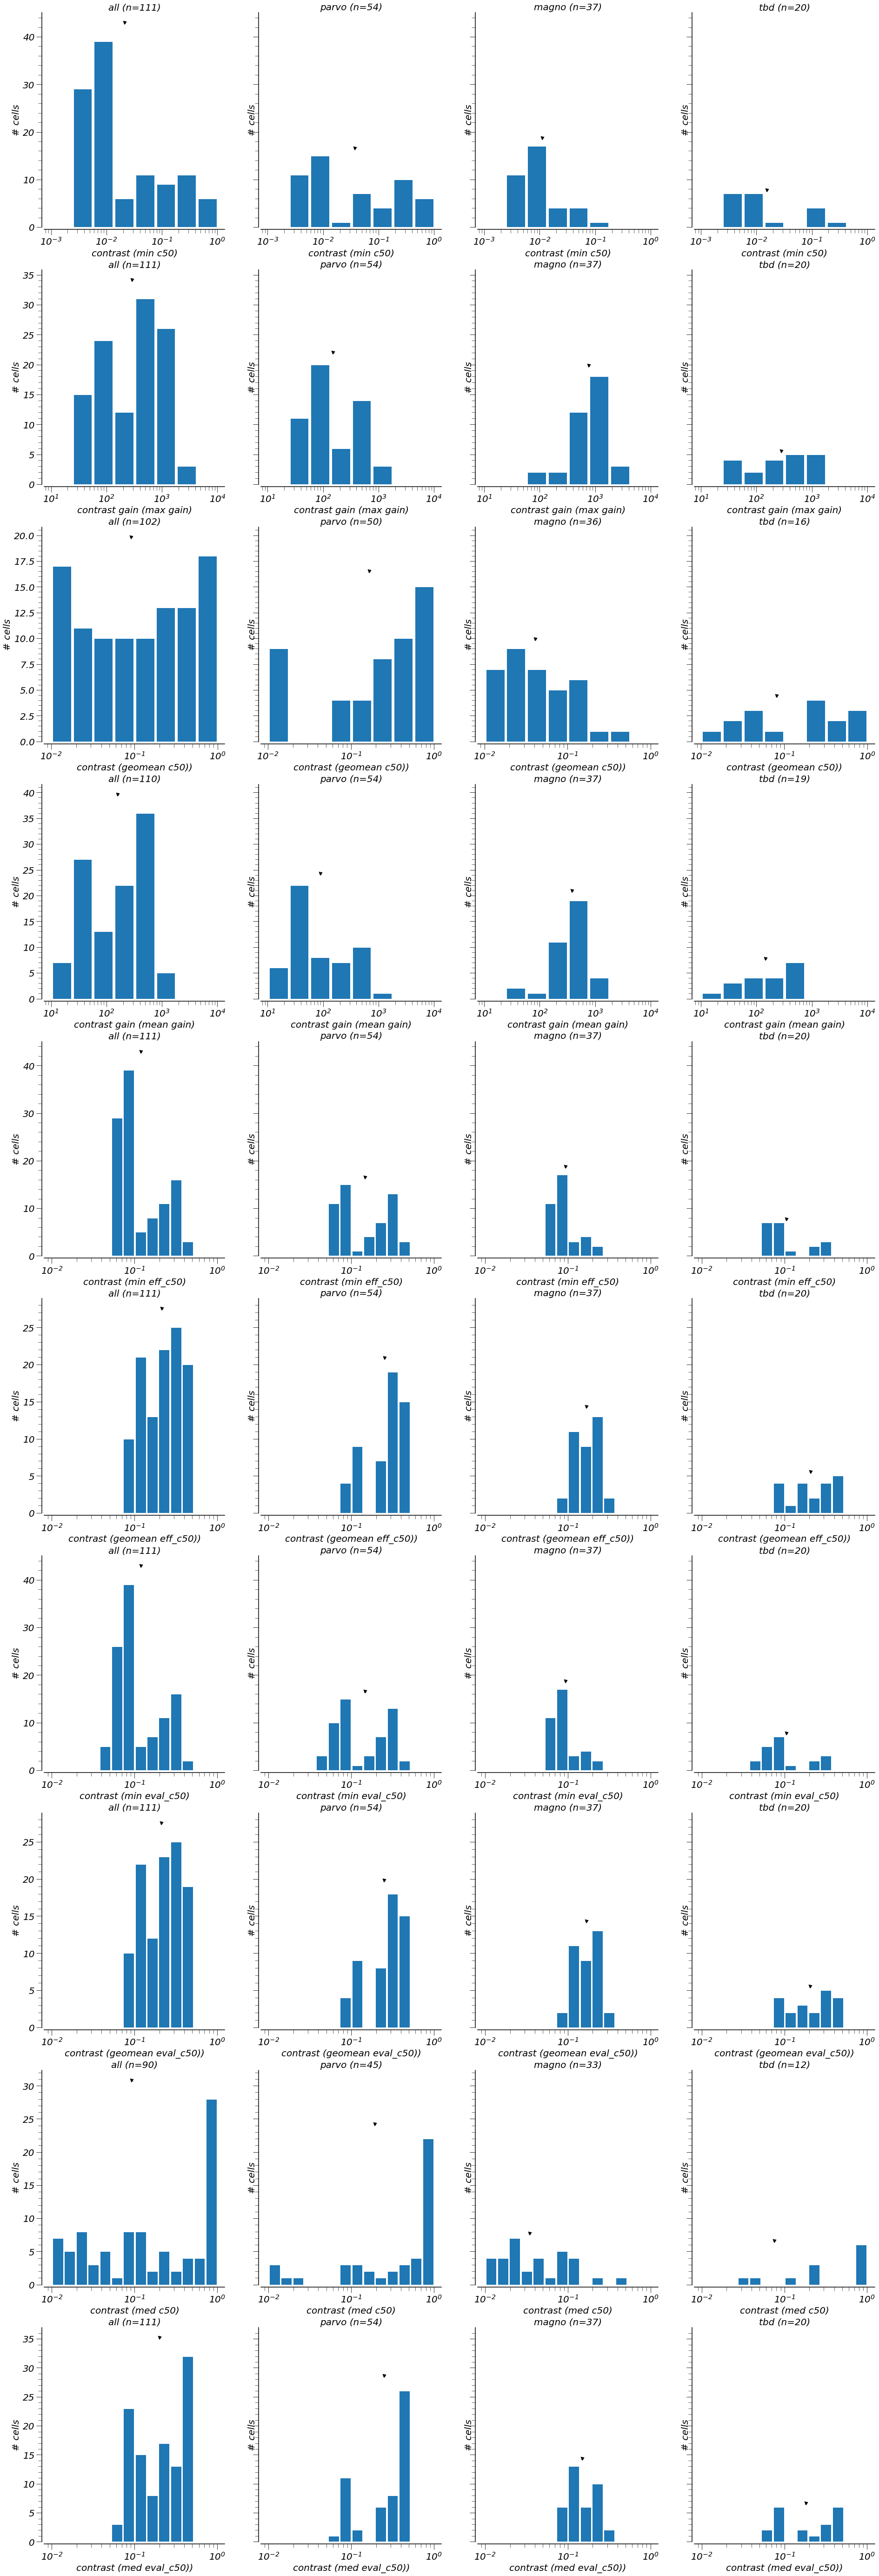

In [24]:
nrow = 10;
ncol = 4;
colStr = ['all', 'parvo', 'magno', 'tbd'];

f, ax = plt.subplots(nrow, ncol, figsize=(ncol*8, nrow*10), sharey='row')

# first row - minimum c50
for i in range(ncol):
    bins = np.geomspace(0.001, 1, 9)
    val_cls = np.where(~np.isnan(c50_min[:, i]))[0];
    counts, _, _ = ax[0, i].hist(c50_min[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50_min[val_cls, i])
    ax[0, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[0, i].set_xscale('log')
    ax[0, i].set_title('%s (n=%d)' % (colStr[i], sum(counts)))
    ax[0, i].set_xlabel('contrast (min c50)')
    ax[0, i].set_ylabel('# cells')
# second row - maximum contrast gain
for i in range(ncol):
    bins = np.geomspace(1e1, 1e4, 9)
    val_cls = np.where(~np.isnan(conGain_max[:, i]))[0];
    counts, _, _ = ax[1, i].hist(conGain_max[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(conGain_max[val_cls, i])
    ax[1, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[1, i].set_xscale('log')
    ax[1, i].set_title('%s (n=%d)' % (colStr[i], sum(counts)))
    ax[1, i].set_xlabel('contrast gain (max gain)')
    ax[1, i].set_ylabel('# cells')
# third row - mean c50
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 9)
    val_cls = np.where(~np.isnan(c50_mean[:, i]))[0];
    counts, _, _ = ax[2, i].hist(c50_mean[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50_mean[val_cls, i])
    ax[2, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[2, i].set_xscale('log')
    ax[2, i].set_title('%s (n=%d)' % (colStr[i], sum(counts)))
    ax[2, i].set_xlabel('contrast (geomean c50))')
    ax[2, i].set_ylabel('# cells')
# fourth row - mean contrast gain
for i in range(ncol):
    bins = np.geomspace(1e1, 1e4, 9)
    val_cls = np.where(~np.isnan(conGain_mean[:, i]))[0];
    counts, _, _ = ax[3, i].hist(conGain_mean[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(conGain_mean[val_cls, i])
    ax[3, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[3, i].set_xscale('log')
    ax[3, i].set_title('%s (n=%d)' % (colStr[i], sum(counts)))
    ax[3, i].set_xlabel('contrast gain (mean gain)')
    ax[3, i].set_ylabel('# cells')
# fifth row - c50 - effective (min)
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 15)
    val_cls = np.where(~np.isnan(c50eff_min[:, i]))[0];
    counts, _, _ = ax[4, i].hist(c50eff_min[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50eff_min[val_cls, i])
    ax[4, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[4, i].set_xscale('log')
    ax[4, i].set_title('%s (n=%d)' % (colStr[i], sum(counts)))
    ax[4, i].set_xlabel('contrast (min eff_c50)')
    ax[4, i].set_ylabel('# cells')
# sixth row - c50 - effective (mean)
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 15)
    val_cls = np.where(~np.isnan(c50eff_mean[:, i]))[0];
    counts, _, _ = ax[5, i].hist(c50eff_mean[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50eff_mean[val_cls, i])
    ax[5, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[5, i].set_xscale('log')
    ax[5, i].set_title('%s (n=%d)' % (colStr[i], sum(counts)))
    ax[5, i].set_xlabel('contrast (geomean eff_c50))')
    ax[5, i].set_ylabel('# cells')
# 7th row - c50 - eval (min)
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 15)
    val_cls = np.where(~np.isnan(c50eval_min[:, i]))[0];
    counts, _, _ = ax[6, i].hist(c50eval_min[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50eff_min[val_cls, i])
    ax[6, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[6, i].set_xscale('log')
    ax[6, i].set_title('%s (n=%d)' % (colStr[i], sum(counts)))
    ax[6, i].set_xlabel('contrast (min eval_c50)')
    ax[6, i].set_ylabel('# cells')
# 8th row - c50 - eval (mean)
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 15)
    val_cls = np.where(~np.isnan(c50eval_mean[:, i]))[0];
    counts, _, _ = ax[7, i].hist(c50eval_mean[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50eval_mean[val_cls, i])
    ax[7, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[7, i].set_xscale('log')
    ax[7, i].set_title('%s (n=%d)' % (colStr[i], sum(counts)))
    ax[7, i].set_xlabel('contrast (geomean eval_c50))')
    ax[7, i].set_ylabel('# cells')
# 8th row - c50 (median)
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 15)
    val_cls = np.where(~np.isnan(c50_med[:, i]))[0];
    counts, _, _ = ax[8, i].hist(c50_med[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50_med[val_cls, i])
    ax[8, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[8, i].set_xscale('log')
    ax[8, i].set_title('%s (n=%d)' % (colStr[i], sum(counts)))
    ax[8, i].set_xlabel('contrast (med c50)')
    ax[8, i].set_ylabel('# cells')
# 9th row - c50 - eval (geomean)
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 15)
    val_cls = np.where(~np.isnan(c50eval_med[:, i]))[0];
    counts, _, _ = ax[9, i].hist(c50eval_med[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50eval_med[val_cls, i])
    ax[9, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[9, i].set_xscale('log')
    ax[9, i].set_title('%s (n=%d)' % (colStr[i], sum(counts)))
    ax[9, i].set_xlabel('contrast (med eval_c50))')
    ax[9, i].set_ylabel('# cells')
    
sns.despine(offset=5)
    
saveName = "/rvcMeasures_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


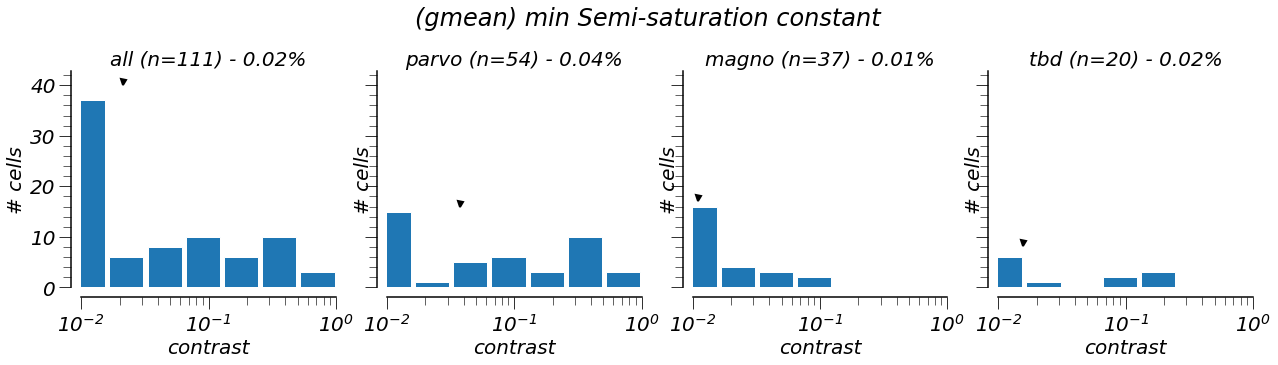

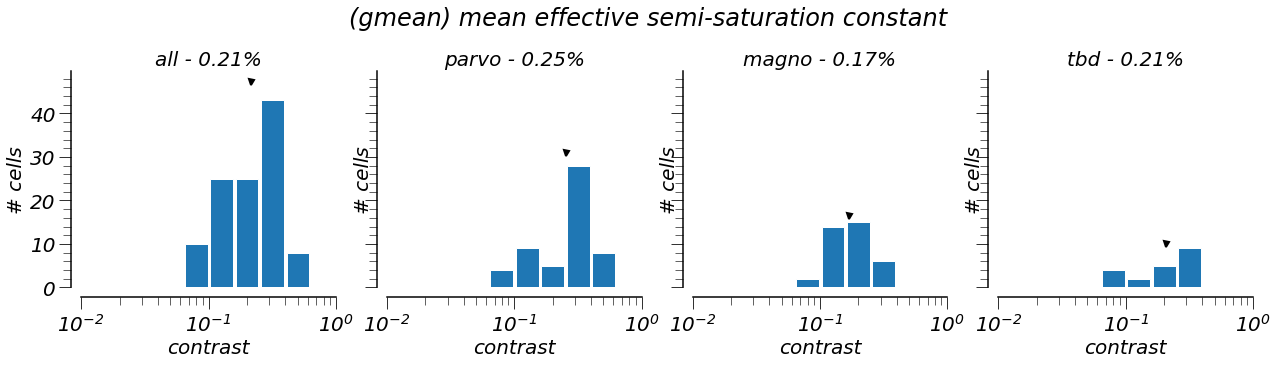

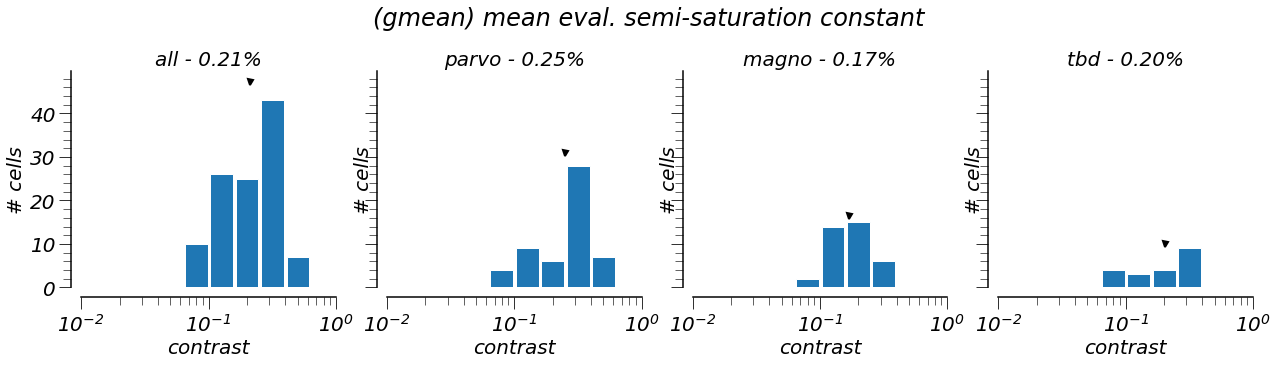

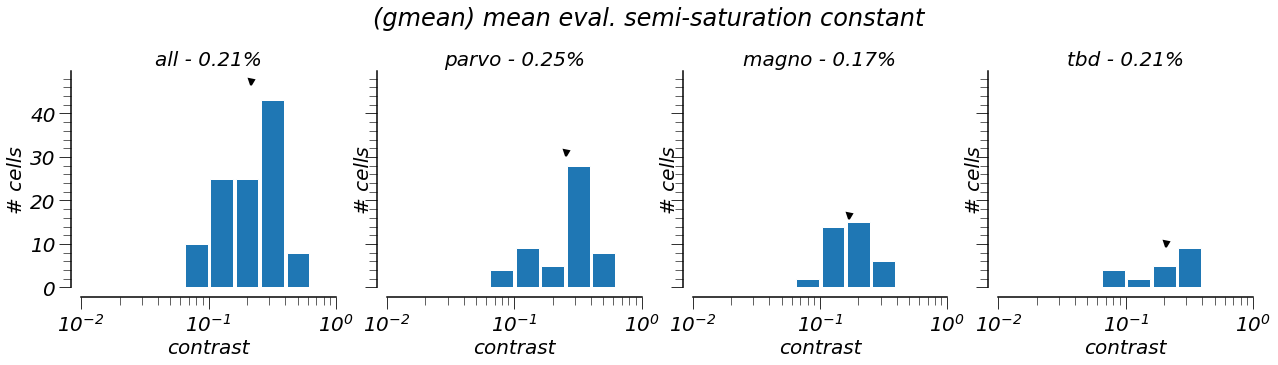

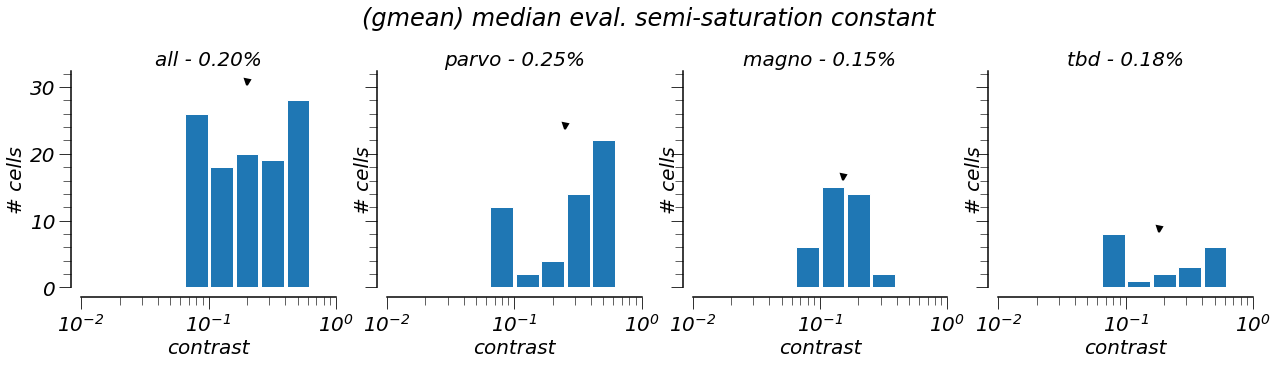

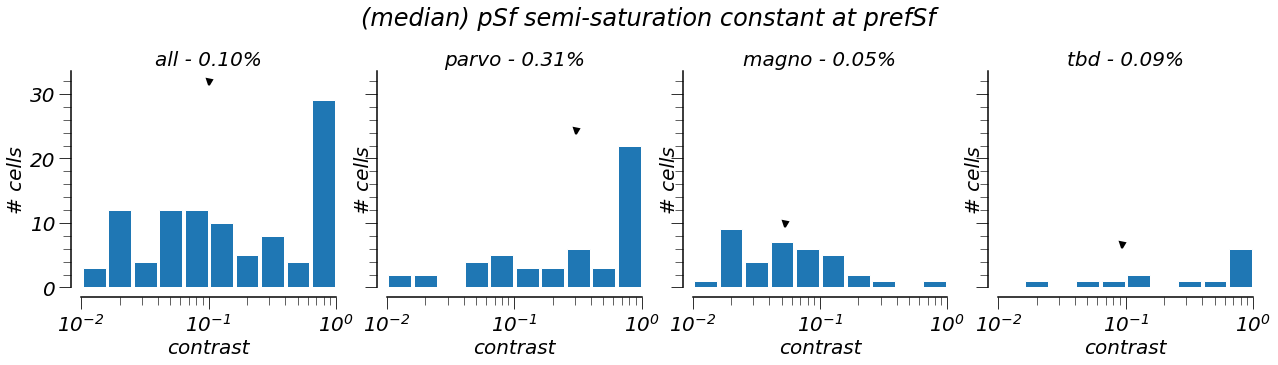

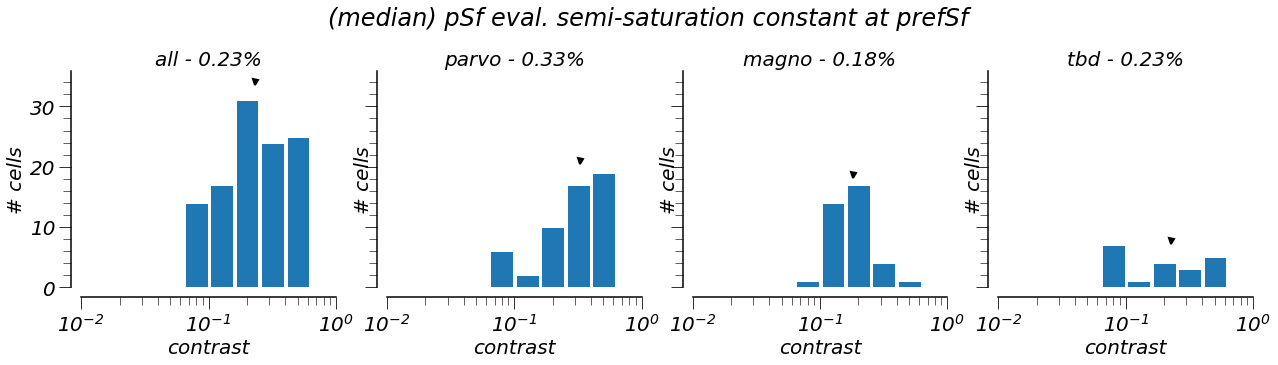

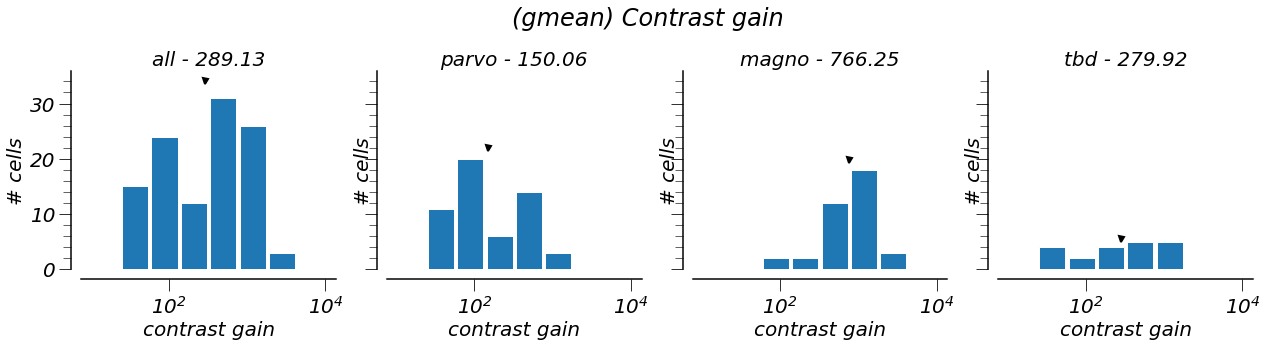

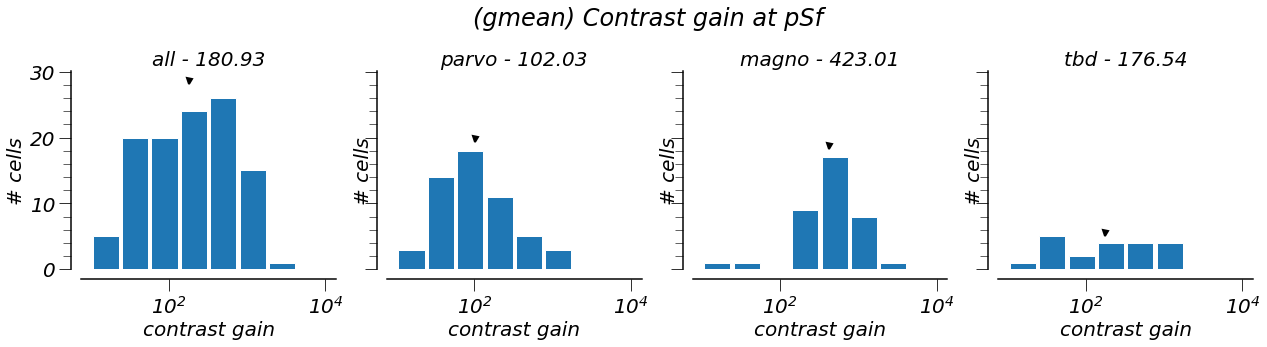

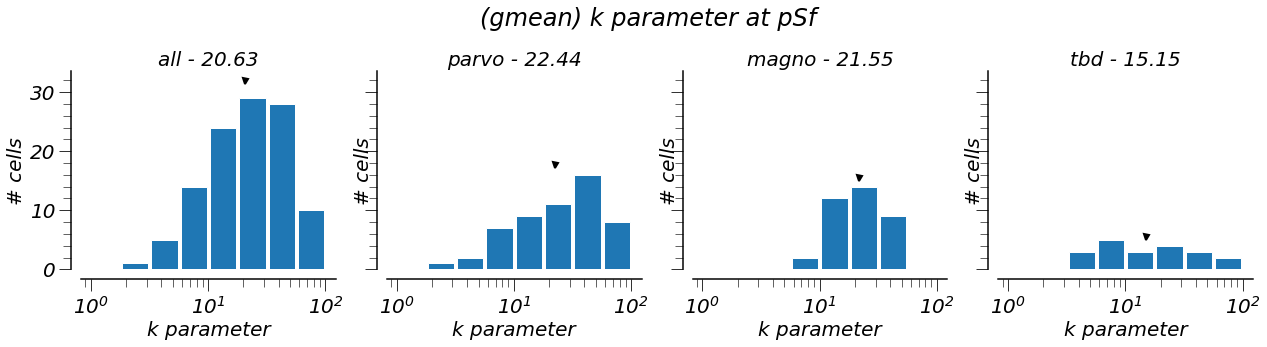

In [25]:
# first row - minimum c50
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(0.001, 1, 11)
    val_cells = np.where(~np.isnan(c50_min[:, i]))[0];
    counts, _, _ = ax[i].hist(c50_min[val_cells, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50_min[val_cells, i])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s (n=%d) - %.2f%%' % (colStr[i], len(val_cells), ratio_gmean))
    ax[i].set_xlabel('contrast')
    ax[i].set_ylabel('# cells')
    ax[i].set_xlim([1e-2, 1])
f.suptitle('(gmean) min Semi-saturation constant');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.2);

sns.despine(offset=10)

saveName = "/c50_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

# second row - gmean effective c50
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 11)
    val_cells = np.where(~np.isnan(c50eff_mean[:, i]))[0];
    counts, _, _ = ax[i].hist(c50eff_mean[val_cells, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50eff_mean[val_cells, i])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s - %.2f%%' % (colStr[i], ratio_gmean))
    ax[i].set_xlabel('contrast')
    ax[i].set_ylabel('# cells')
    ax[i].set_xlim([1e-2, 1])
f.suptitle('(gmean) mean effective semi-saturation constant');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.2);

sns.despine(offset=10)

saveName = "/c50eff_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

# third row - gmean eval c50
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 11)
    val_cells = np.where(~np.isnan(c50eval_mean[:, i]))[0];
    counts, _, _ = ax[i].hist(c50eval_mean[val_cells, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50eval_mean[val_cells, i])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s - %.2f%%' % (colStr[i], ratio_gmean))
    ax[i].set_xlabel('contrast')
    ax[i].set_ylabel('# cells')
    ax[i].set_xlim([1e-2, 1])
f.suptitle('(gmean) mean eval. semi-saturation constant');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.2);

sns.despine(offset=10)

saveName = "/c50eval_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

# 4th row - gmean effective c50
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 11)
    val_cells = np.where(~np.isnan(c50eff_mean[:, i]))[0];
    counts, _, _ = ax[i].hist(c50eff_mean[val_cells, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50eff_mean[val_cells, i])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s - %.2f%%' % (colStr[i], ratio_gmean))
    ax[i].set_xlabel('contrast')
    ax[i].set_ylabel('# cells')
    ax[i].set_xlim([1e-2, 1])
f.suptitle('(gmean) mean eval. semi-saturation constant');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.2);

sns.despine(offset=10)

saveName = "/c50eff_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

# 5th row - median eval c50
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 11)
    val_cells = np.where(~np.isnan(c50eval_med[:, i]))[0];
    counts, _, _ = ax[i].hist(c50eval_med[val_cells, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50eval_med[val_cells, i])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s - %.2f%%' % (colStr[i], ratio_gmean))
    ax[i].set_xlabel('contrast')
    ax[i].set_ylabel('# cells')
    ax[i].set_xlim([1e-2, 1])
f.suptitle('(gmean) median eval. semi-saturation constant');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.2);

sns.despine(offset=10)

saveName = "/c50eff_med_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

# 6th row - c50 at pSf
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 11)
    val_cells = np.where(~np.isnan(c50_pSf[:, i]))[0];
    counts, _, _ = ax[i].hist(c50_pSf[val_cells, i], bins, rwidth=0.9)
    ratio_gmean = np.nanmedian(c50_pSf[val_cells, i])
#     ratio_gmean = geomean(c50_pSf[val_cells, i])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s - %.2f%%' % (colStr[i], ratio_gmean))
    ax[i].set_xlabel('contrast')
    ax[i].set_ylabel('# cells')
    ax[i].set_xlim([1e-2, 1])
f.suptitle('(median) pSf semi-saturation constant at prefSf');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.2);

sns.despine(offset=10)

saveName = "/c50_pSf_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

# 7th row - c50eval at pSf
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 11)
    val_cells = np.where(~np.isnan(c50eval_pSf[:, i]))[0];
    counts, _, _ = ax[i].hist(c50eval_pSf[val_cells, i], bins, rwidth=0.9)
    ratio_gmean = np.nanmedian(c50eval_pSf[val_cells, i])
#     ratio_gmean = geomean(c50eval_pSf[val_cells, i])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s - %.2f%%' % (colStr[i], ratio_gmean))
    ax[i].set_xlabel('contrast')
    ax[i].set_ylabel('# cells')
    ax[i].set_xlim([1e-2, 1])
f.suptitle('(median) pSf eval. semi-saturation constant at prefSf');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.2);

sns.despine(offset=10)

saveName = "/c50eval_pSf_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

# 8th row - maximum contrast gain
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(1e1, 1e4, 9)
    val_cells = np.where(~np.isnan(conGain_max[:, i]))[0];
    counts, _, _ = ax[i].hist(conGain_max[val_cells, i], bins, rwidth=0.9)
    ratio_gmean = geomean(conGain_max[val_cells, i])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s - %.2f' % (colStr[i], ratio_gmean))
    ax[i].set_xlabel('contrast gain')
    ax[i].set_ylabel('# cells')
f.suptitle('(gmean) Contrast gain');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.25);

sns.despine(offset=10)

saveName = "/conGain_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

# 9th row - contrast gain at pSf
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(1e1, 1e4, 9)
    val_cells = np.where(~np.isnan(conGain_pSf[:, i]))[0];
    counts, _, _ = ax[i].hist(conGain_pSf[val_cells, i], bins, rwidth=0.9)
    ratio_gmean = geomean(conGain_pSf[val_cells, i])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s - %.2f' % (colStr[i], ratio_gmean))
    ax[i].set_xlabel('contrast gain')
    ax[i].set_ylabel('# cells')
f.suptitle('(gmean) Contrast gain at pSf');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.25);

sns.despine(offset=10)

saveName = "/conGain_pSf_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

# 10th row - "k" parameter at pSf (c50*conGain)
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(1e0, 1e2, 9)
    curr_vals = np.multiply(conGain_pSf[:,i], c50_pSf[:,i]);
    val_cells = np.where(~np.isnan(curr_vals))[0];
    counts, _, _ = ax[i].hist(curr_vals[val_cells], bins, rwidth=0.9)
    ratio_gmean = geomean(curr_vals[val_cells])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s - %.2f' % (colStr[i], ratio_gmean))
    ax[i].set_xlabel('k parameter')
    ax[i].set_ylabel('# cells')
f.suptitle('(gmean) k parameter at pSf');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.25);

sns.despine(offset=10)

saveName = "/kAmp_pSf_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


# Difference of gaussian fits

First, analyze how much variance is explained by each model fit. This analysis is described in Cavanaugh-Heeger-Movshon (1997), and is as follows: $\%variance = 100 * [1-d(m, \overline{r})/d(\overline{r}, \overline{\overline{r}})]$, with $m :=$ model prediction, $\overline{r} :=$ mean response (per condition), and $\overline{\overline{r}} :=$ mean response over all conditions.

Futher, $d(x, y) := \dfrac{1}{N} \Sigma_s{(x_s - y_x)^2}$, where $s :=$ each condition, and $N :=$ the number of conditions.

This analysis has been moved to helper_fcns, and is attached now to the params/NLL in the descrFits structure/analysis

Now, gather the indices for all valid (i.e. supra-variance-explained-threshold) conditions

In [26]:
print('Of %d gain ratios, %d are NaN\n' % (len(all_gainRat), np.sum(np.isnan(all_gainRat))))
non_nans = np.where(~np.isnan(all_gainRat))[0];
print('Of %d (non-nan) gain ratios, %.1f%% are greater than 1 (i.e. c > s)\n' % (len(non_nans), 100*np.sum(all_gainRat[non_nans]>1)/len(non_nans)))
print('Of %d (non-nan) radius ratios, %.1f%% are less than 1 (i.e. c < s)\n' % (len(non_nans), 100*np.sum(all_radRat[non_nans]<1)/len(non_nans)))

Of 1346 gain ratios, 1346 are NaN

Of 0 (non-nan) gain ratios, nan% are greater than 1 (i.e. c > s)

Of 0 (non-nan) radius ratios, nan% are less than 1 (i.e. c < s)



/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


Now, let's plot the trajectory of each parameter (and peak SF) with contrast, as split by cell

In [22]:
all_rc = np.nan * np.zeros((n_cells, max_nCons));
all_rs = np.nan * np.zeros((n_cells, max_nCons));
all_gc = np.nan * np.zeros((n_cells, max_nCons));
all_gs = np.nan * np.zeros((n_cells, max_nCons));
all_psf = np.nan * np.zeros((n_cells, max_nCons));
all_cfr = np.nan * np.zeros((n_cells, max_nCons));
all_volc = np.nan * np.zeros((n_cells, max_nCons));
all_vols = np.nan * np.zeros((n_cells, max_nCons));
all_volrat = np.nan * np.zeros((n_cells, max_nCons));

# and make space for normalized values of the same, where we normalize to the parameter value at the highest valid contrast
all_rc_norm = np.nan * np.zeros((n_cells, max_nCons));
all_rs_norm = np.nan * np.zeros((n_cells, max_nCons));
all_gc_norm = np.nan * np.zeros((n_cells, max_nCons));
all_gs_norm = np.nan * np.zeros((n_cells, max_nCons));
all_psf_norm = np.nan * np.zeros((n_cells, max_nCons));
all_cfr_norm = np.nan * np.zeros((n_cells, max_nCons));
all_volc_norm = np.nan * np.zeros((n_cells, max_nCons));
all_vols_norm = np.nan * np.zeros((n_cells, max_nCons));
all_volrat_norm = np.nan * np.zeros((n_cells, max_nCons));

# and contrast ratios...
all_rc_conRat = np.nan * np.zeros((n_cells, ))
all_rs_conRat = np.nan * np.zeros((n_cells, ))
all_volc_conRat = np.nan * np.zeros((n_cells, ))
all_vols_conRat = np.nan * np.zeros((n_cells, ))

In [23]:
# here, organize and compute everything we need
for i in range(n_cells):
    # now, get the valid contrast indices...
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    
    # take into account that not all cells are in descrFits, but all will be in all[Con[[byDisp]]][sf][disp]   
#     ii = val_cells[i]
#     cons_curr = allConByDisp[ii][0];
#     con_inds = range(len(cons_curr));
    # messy list comprehension, but basically only get the parameter if that fit meets the variance explained thresh
    all_rc[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'rc') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_rs[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'rs') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_gc[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'gc') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_gs[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'gs') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_psf[i, con_inds] = [all_prefSf[i][c] if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_cfr[i, con_inds] = [all_cfreq[i][c] if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    # now compute volumes, ratio of volumes
    all_volc[i, con_inds] = np.multiply(all_gc[i, con_inds], np.square(all_rc[i, con_inds]))
    all_vols[i, con_inds] = np.multiply(all_gs[i, con_inds], np.square(all_rs[i, con_inds]))
    all_volrat[i, con_inds] = np.divide(all_vols[i, con_inds], all_volc[i, con_inds])
    
    if np.all(np.isnan(all_rc[i, :])): # don't normalize if they're all NaN
        continue;
    highest_valIndex = np.where(~np.isnan(all_rc[i, con_inds]))[0][-1];
    lowest_valIndex = np.where(~np.isnan(all_rc[i, con_inds]))[0][0];
    all_rc_norm[i, con_inds] = np.divide(all_rc[i, con_inds], all_rc[i, highest_valIndex]);
    all_rs_norm[i, con_inds] = np.divide(all_rs[i, con_inds], all_rs[i, highest_valIndex]);
    all_gc_norm[i, con_inds] = np.divide(all_gc[i, con_inds], all_gc[i, highest_valIndex]);
    all_gs_norm[i, con_inds] = np.divide(all_gs[i, con_inds], all_gs[i, highest_valIndex]);
    all_psf_norm[i, con_inds] = np.divide(all_psf[i, con_inds], all_psf[i, highest_valIndex]) 
    all_cfr_norm[i, con_inds] = np.divide(all_cfr[i, con_inds], all_cfr[i, highest_valIndex]) 
    # now compute volumes, ratio of volumes
    all_volc_norm[i, con_inds] = np.divide(all_volc[i, con_inds], all_volc[i, highest_valIndex])
    all_vols_norm[i, con_inds] = np.divide(all_vols[i, con_inds], all_vols[i, highest_valIndex])
    all_volrat_norm[i, con_inds] = np.divide(all_volrat[i, con_inds], all_volrat[i, highest_valIndex])

    # measure ratio of center, surround radii at highest/lowest contrast; same for volumes
    all_rc_conRat[i] = all_rc[i, highest_valIndex]/all_rc[i, lowest_valIndex];
    all_rs_conRat[i] = all_rs[i, highest_valIndex]/all_rs[i, lowest_valIndex];
    all_volc_conRat[i] = all_volc[i, highest_valIndex]/all_volc[i, lowest_valIndex];
    all_vols_conRat[i] = all_vols[i, highest_valIndex]/all_vols[i, lowest_valIndex];
    
    
cellsPassed = np.where([np.any(x>thresh_varExpl) for x in all_varExpl])[0]
n_cellsPassed = len(cellsPassed)

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


#### Parameter trends versus contrast

First, let's ask: what is the lowest valid contrast (i.e. varExpl > thresh) for each cell?

In [24]:
lowestInd = np.nan * np.zeros((n_cells, ))
valLowest = [np.where(~np.isnan(all_rc[x, :]))[0][0] for x in cellsPassed]
lowestInd[cellsPassed] = valLowest

lowestCon = np.nan * np.zeros((n_cells, ));
valCon = [all_cVals[x][y] for x, y in zip(cellsPassed, valLowest)]
lowestCon[cellsPassed] = valCon

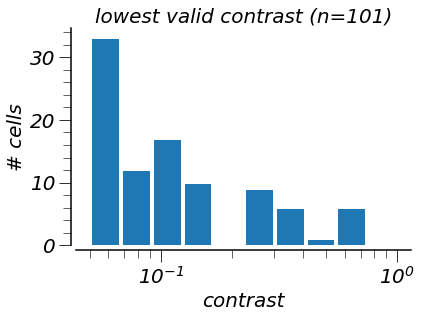

In [25]:
bins = np.geomspace(0.05, 1, 11)
# bins = np.unique(all_cVals)
plt.hist(lowestCon[~np.isnan(lowestCon)], bins, rwidth=0.9)
plt.xscale('log')
plt.xlabel('contrast');
plt.ylabel('# cells')
plt.title('lowest valid contrast (n=%d)' % n_cellsPassed);
sns.despine(offset=5)

As an example, let's plot center gain versus contrast - for all cells, overlayed

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


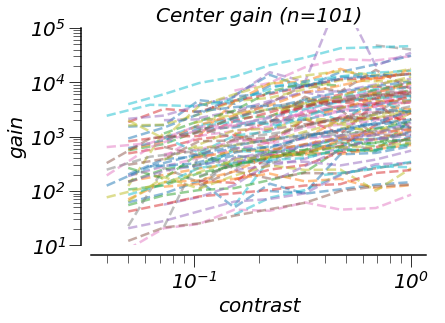

In [26]:
for i in range(n_cells):
    # now, get the valid contrast indices...
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_gc[i, con_inds], '--', alpha=0.5)
    
    #     ii = val_cells[i] # as above
#     con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
#     val_cons = allCons[ii][con_inds]
#     plt.plot(val_cons, all_gc[i, :], '--', alpha=0.5)
# gc_medians = np.nanmedian(all_gc, 0);
# plt.plot(val_cons, gc_medians, 'r', linewidth=3)
plt.ylim([1e1, 1e5])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Center gain (n=%d)' % n_cellsPassed)
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range
sns.despine(offset=10)

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


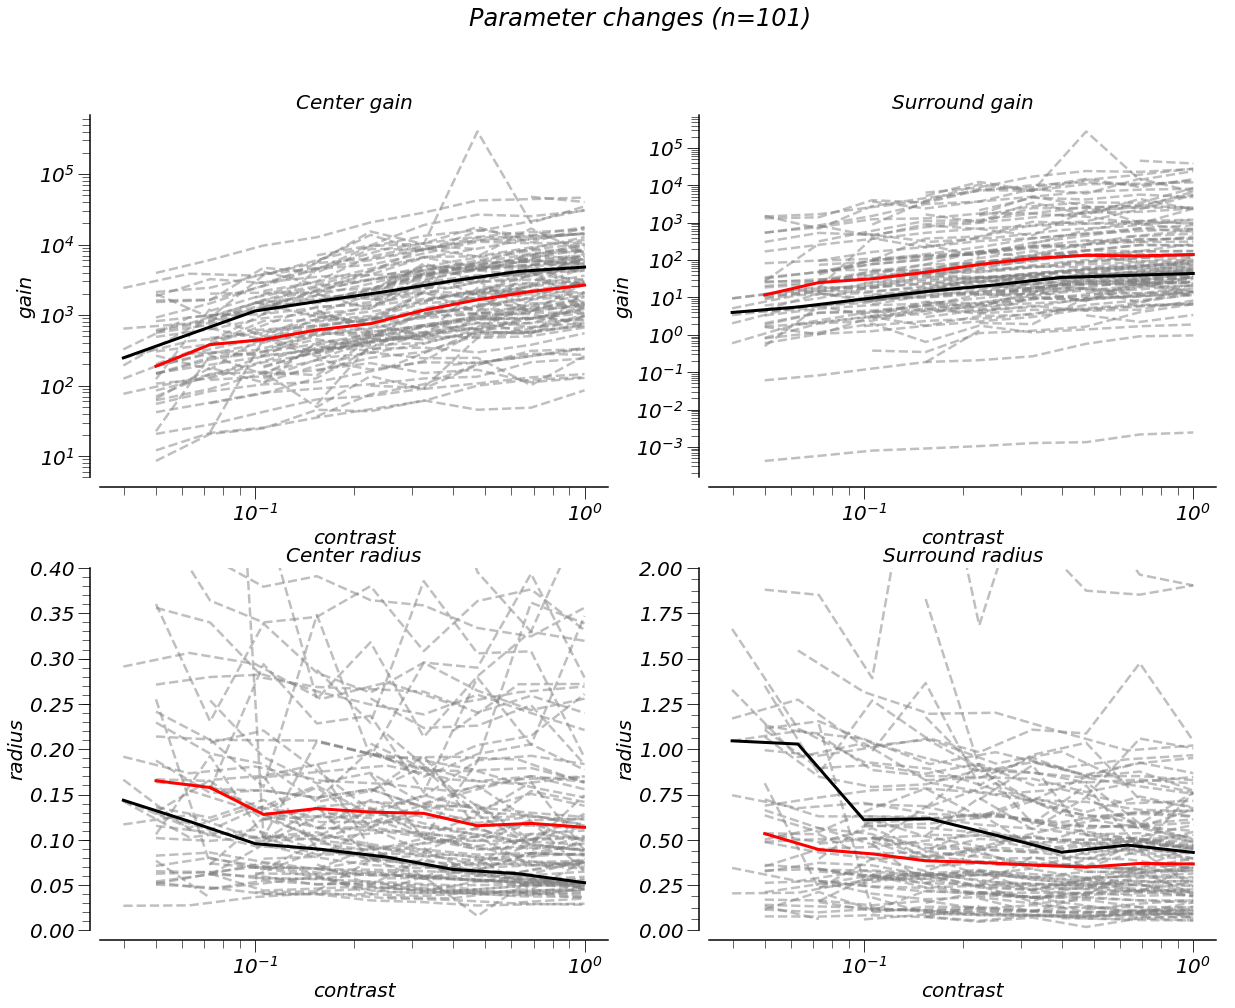

In [27]:
# PARAMETER PLOTS VS. CONTRAST
# throughout, we'll plot the median value across contrast for the two experiments separately
if datasets == 0 or datasets == 2:
    myInds = np.where(expNum==0)[0];
    myCons = all_cVals[myInds[0]];
else:
    myInds, myCons = None, None;
if datasets == 1 or datasets == 2:
    sachInds = np.where(expNum==1)[0];
    sachCons = all_cVals[sachInds[0]]
else:
    sachInds, sachCons = None, None
    
f, ax = plt.subplots(2, 2, figsize=(20, 15))

gray = cm.gray(0.5) # mean gray

# center gain
plt.subplot(2, 2, 1);
for i in range(n_cells):
    # now, get the valid contrast indices...
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_gc[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    gc_medians = np.nanmedian(all_gc[myInds], 0);
    plt.plot(myCons, gc_medians[~np.isnan(gc_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    gc_medians = np.nanmedian(all_gc[sachInds], 0);
    plt.plot(sachCons, gc_medians, 'k', linewidth=3, label='sach')
# plt.ylim([0, 75])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Center gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range

# surround gain
plt.subplot(2, 2, 2);
for i in range(n_cells):
    # now, get the valid contrast indices...
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_gs[i, con_inds], '--', color=gray, alpha=0.5)    
# my median
if myInds is not None:
    gs_medians = np.nanmedian(all_gs[myInds], 0);
    plt.plot(myCons, gs_medians[~np.isnan(gs_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    gs_medians = np.nanmedian(all_gs[sachInds], 0);
    plt.plot(sachCons, gs_medians, 'k', linewidth=3, label='sach')

# plt.ylim([10e0, 10e4])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Surround gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range

# center radius
plt.subplot(2, 2, 3);
for i in range(n_cells):
    # now, get the valid contrast indices...
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rc[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    rc_medians = np.nanmedian(all_rc[myInds], 0);
    plt.plot(myCons, rc_medians[~np.isnan(rc_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    rc_medians = np.nanmedian(all_rc[sachInds], 0);
    plt.plot(sachCons, rc_medians, 'k', linewidth=3, label='sach')
plt.ylim([0, 0.4]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround radius
plt.subplot(2, 2, 4);
for i in range(n_cells):
    # now, get the valid contrast indices...
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rs[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    rs_medians = np.nanmedian(all_rs[myInds], 0);
    plt.plot(myCons, rs_medians[~np.isnan(rs_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    rs_medians = np.nanmedian(all_rs[sachInds], 0);
    plt.plot(sachCons, rs_medians, 'k', linewidth=3, label='sach')
plt.ylim([0, 2]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

f.suptitle('Parameter changes (n=%d)' % n_cellsPassed)
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

saveName = "/DoG_params%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

The center (and, to a lesser extent, the surround) gain increases steadily with contrast. The center and surround radii seem relatively constant. These findings, though, are obscured by the different cells which contribute to each of the median values - i.e. cells 1, 3, 5 might contribute to lowest contrast, and 2, 4, 5 to the highest -- they each have their own range of values, so a "raw" median/trend might be misleading.

#### Normalized trends

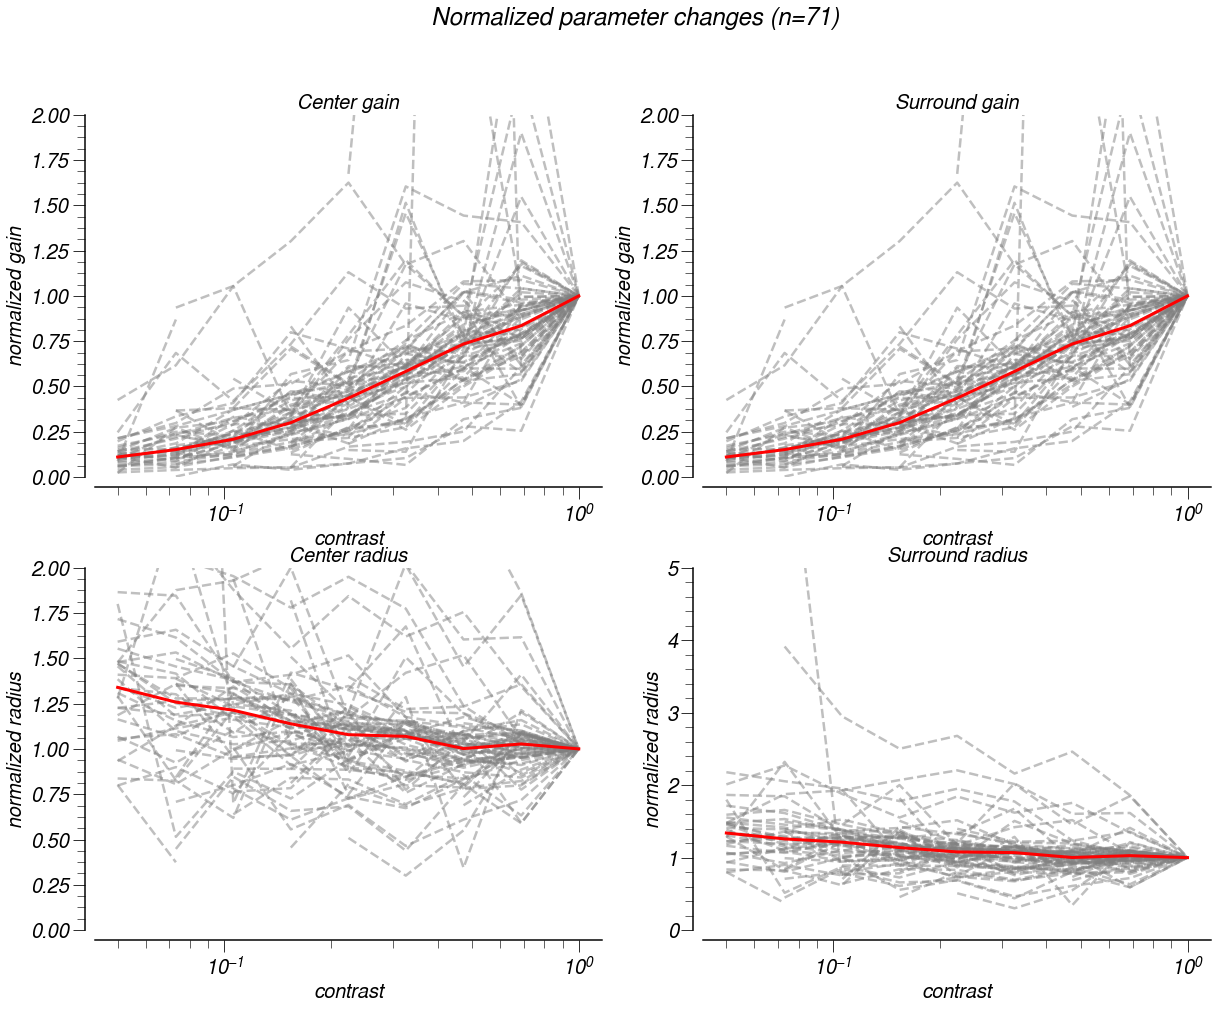

In [1860]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

gray = cm.gray(0.5)

# center gain
plt.subplot(2, 2, 1);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_gc_norm[i, con_inds], '--', c=gray, alpha=0.5)
# my median
if myInds is not None:
    gc_medians = np.nanmedian(all_gc_norm[myInds], 0);
    plt.plot(myCons, gc_medians[~np.isnan(gc_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    gc_medians = np.nanmedian(all_gc_norm[sachInds], 0);
    plt.plot(sachCons, gc_medians, 'k', linewidth=3, label='sach')
plt.ylim([0, 2])
plt.xlabel('contrast');
plt.ylabel('normalized gain')
plt.title('Center gain')
plt.xscale('log')

# surround gain
plt.subplot(2, 2, 2);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_gs_norm[i, con_inds], '--', c=gray, alpha=0.5)
# my median
if myInds is not None:
    gs_medians = np.nanmedian(all_gs_norm[myInds], 0);
    plt.plot(myCons, gs_medians[~np.isnan(gs_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    gs_medians = np.nanmedian(all_gs_norm[sachInds], 0);
    plt.plot(sachCons, gs_medians, 'k', linewidth=3, label='sach')
plt.ylim([0, 2])
plt.xlabel('contrast');
plt.ylabel('normalized gain')
plt.title('Surround gain')
plt.xscale('log')

# center radius
plt.subplot(2, 2, 3);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rc_norm[i, con_inds], '--', c=gray, alpha=0.5)
# my median
if myInds is not None:
    rc_medians = np.nanmedian(all_rc_norm[myInds], 0);
    plt.plot(myCons, rc_medians[~np.isnan(rc_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    rc_medians = np.nanmedian(all_rc_norm[sachInds], 0);
    plt.plot(sachCons, rc_medians, 'k', linewidth=3, label='sach')
plt.ylim([0, 2]);
plt.xlabel('contrast');
plt.ylabel('normalized radius')
plt.title('Center radius')
plt.xscale('log')

# surround radius
plt.subplot(2, 2, 4);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rs_norm[i, con_inds], '--', c=gray, alpha=0.5)
# my median
if myInds is not None:
    rs_medians = np.nanmedian(all_rs_norm[myInds], 0);
    plt.plot(myCons, rs_medians[~np.isnan(rs_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    rs_medians = np.nanmedian(all_rs_norm[sachInds], 0);
    plt.plot(sachCons, rs_medians, 'k', linewidth=3, label='sach')
plt.ylim([0, 5]);
plt.xlabel('contrast');
plt.ylabel('normalized radius')
plt.title('Surround radius')
plt.xscale('log')

f.suptitle('Normalized parameter changes (n=%d)' % n_cellsPassed)
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

saveName = "/DoG_params_norm%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

Now, a more clear picture emerges: gain increases with contrast, and radius - both center and surround - decrease with contrast. This is what Sach finds (plots/reports only on the radius change).

### Reproduce Sach's figure 3-3

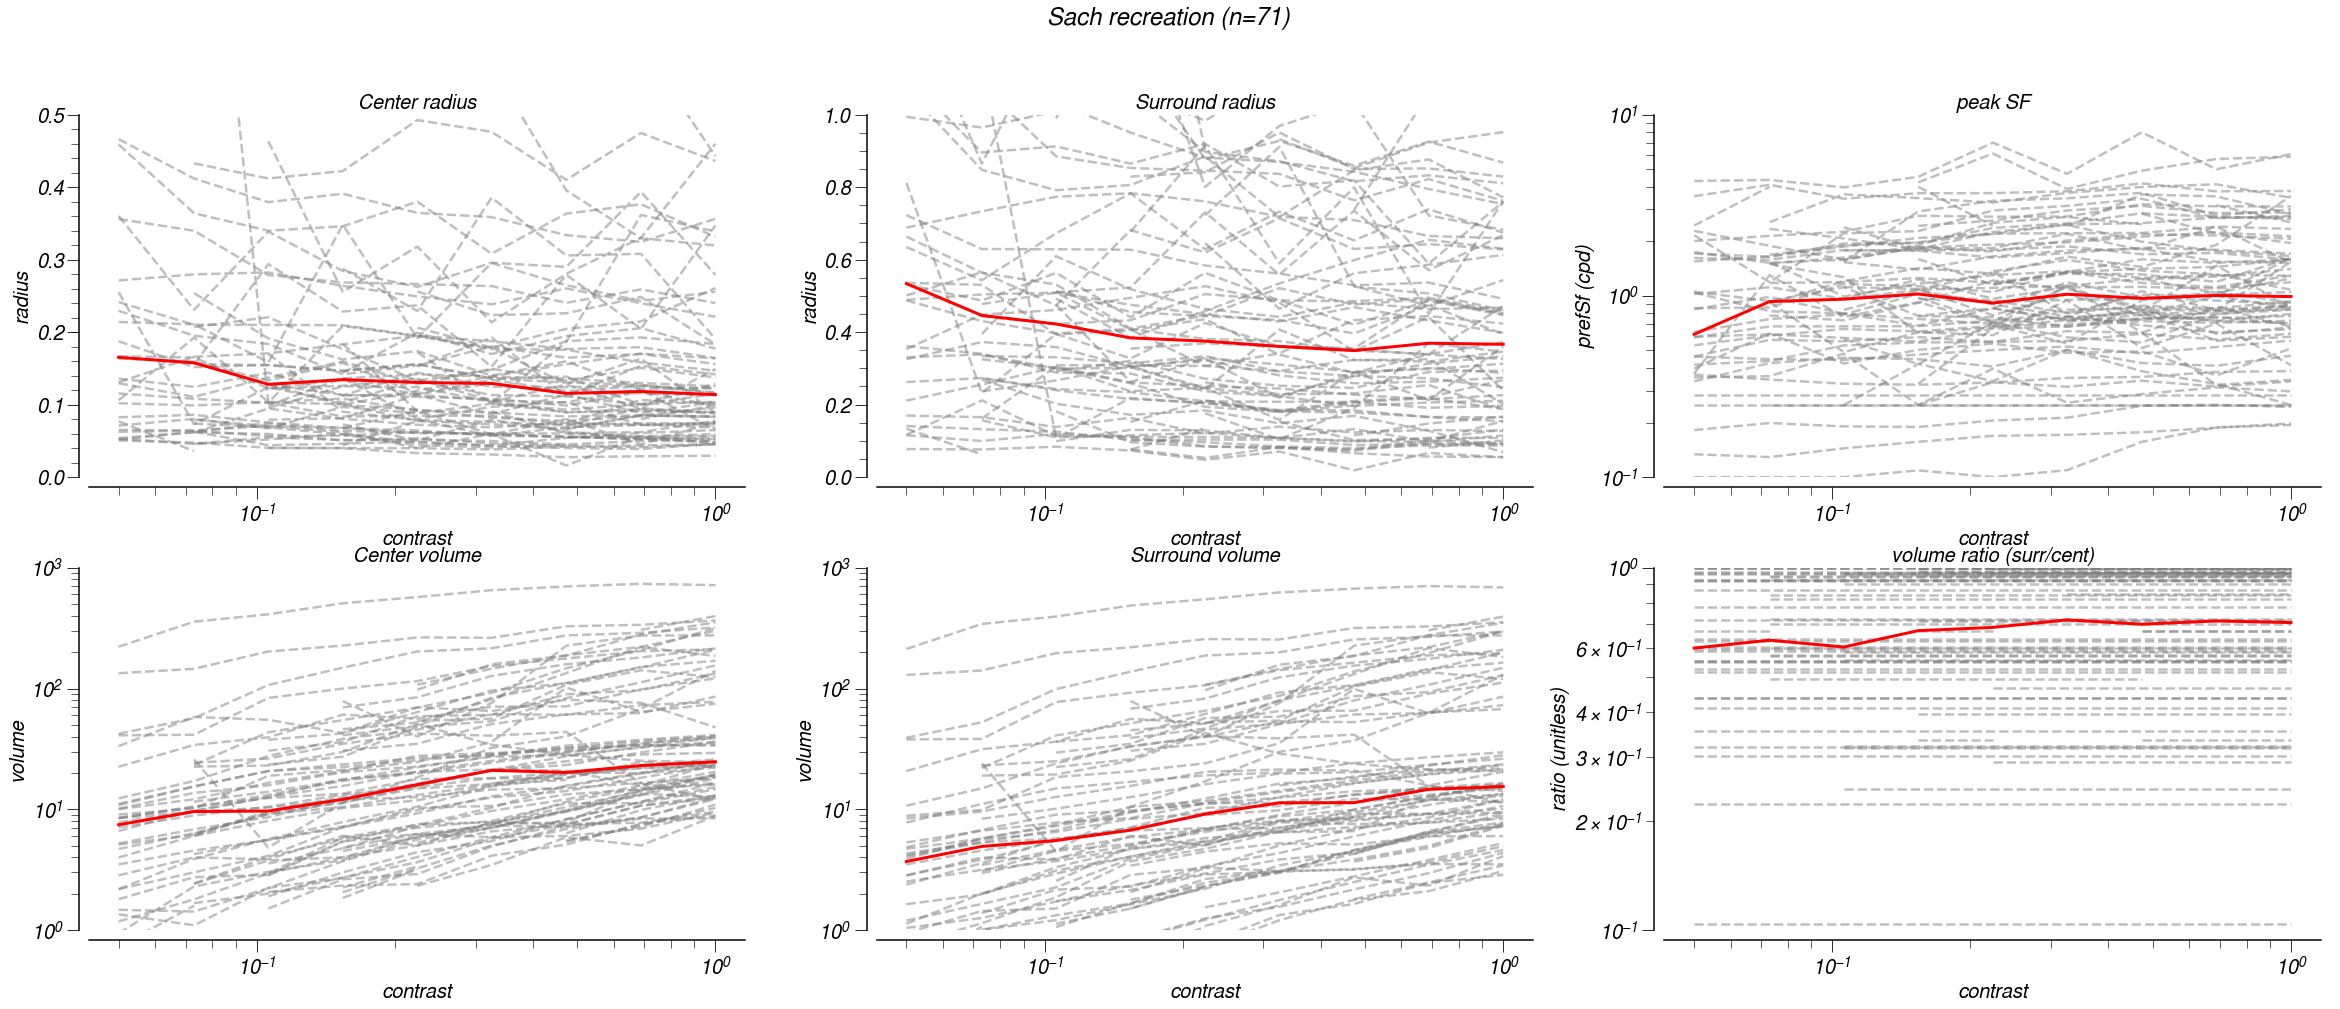

In [1861]:
f, ax = plt.subplots(2, 3, figsize=(40, 15))

gray = cm.gray(0.5) # mean gray

# center radius
plt.subplot(2, 3, 1);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rc[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    rc_medians = np.nanmedian(all_rc[myInds], 0);
    plt.plot(myCons, rc_medians[~np.isnan(rc_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    rc_medians = np.nanmedian(all_rc[sachInds], 0);
    plt.plot(sachCons, rc_medians, 'k', linewidth=3, label='sach')
plt.ylim([0, 0.5]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround radius
plt.subplot(2, 3, 2);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rs[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    rs_medians = np.nanmedian(all_rs[myInds], 0);
    plt.plot(myCons, rs_medians[~np.isnan(rs_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    rs_medians = np.nanmedian(all_rs[sachInds], 0);
    plt.plot(sachCons, rs_medians, 'k', linewidth=3, label='sach')
plt.ylim([0, 1]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

# peak SF
plt.subplot(2, 3, 3);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_psf[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    psf_medians = np.nanmedian(all_psf[myInds], 0);
    plt.plot(myCons, psf_medians[~np.isnan(psf_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    psf_medians = np.nanmedian(all_psf[sachInds], 0);
    plt.plot(sachCons, psf_medians, 'k', linewidth=3, label='sach')    
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('prefSf (cpd)')
plt.title('peak SF')
plt.xscale('log')
plt.yscale('log')

# center volume
plt.subplot(2, 3, 4);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_volc[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    volc_medians = np.nanmedian(all_volc[myInds], 0);
    plt.plot(myCons, volc_medians[~np.isnan(volc_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    volc_medians = np.nanmedian(all_volc[sachInds], 0);
    plt.plot(sachCons, volc_medians, 'k', linewidth=3, label='sach') 
plt.ylim([1e0, 1e3]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Center volume')
plt.xscale('log')
plt.yscale('log')

# surround volume
plt.subplot(2, 3, 5);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_vols[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    vols_medians = np.nanmedian(all_vols[myInds], 0);
    plt.plot(myCons, vols_medians[~np.isnan(vols_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    vols_medians = np.nanmedian(all_vols[sachInds], 0);
    plt.plot(sachCons, vols_medians, 'k', linewidth=3, label='sach') 
plt.ylim([1e0, 1e3]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Surround volume')
plt.xscale('log')
plt.yscale('log')

# volume ratio
plt.subplot(2, 3, 6);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_volrat[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    volrat_medians = np.nanmedian(all_volrat[myInds], 0);
    plt.plot(myCons, volrat_medians[~np.isnan(volrat_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    volrat_medians = np.nanmedian(all_volrat[sachInds], 0);
    plt.plot(sachCons, volrat_medians, 'k', linewidth=3, label='sach') 
plt.ylim([1e-1, 1e0]);
plt.xlabel('contrast');
plt.ylabel('ratio (unitless)')
plt.title('volume ratio (surr/cent)')
plt.xscale('log')
plt.yscale('log')

f.suptitle('Sach recreation (n=%d)' % n_cellsPassed)
f.subplots_adjust(wspace=0.2, hspace=0.25);
 
sns.despine(offset=10)

saveName = "/sach%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

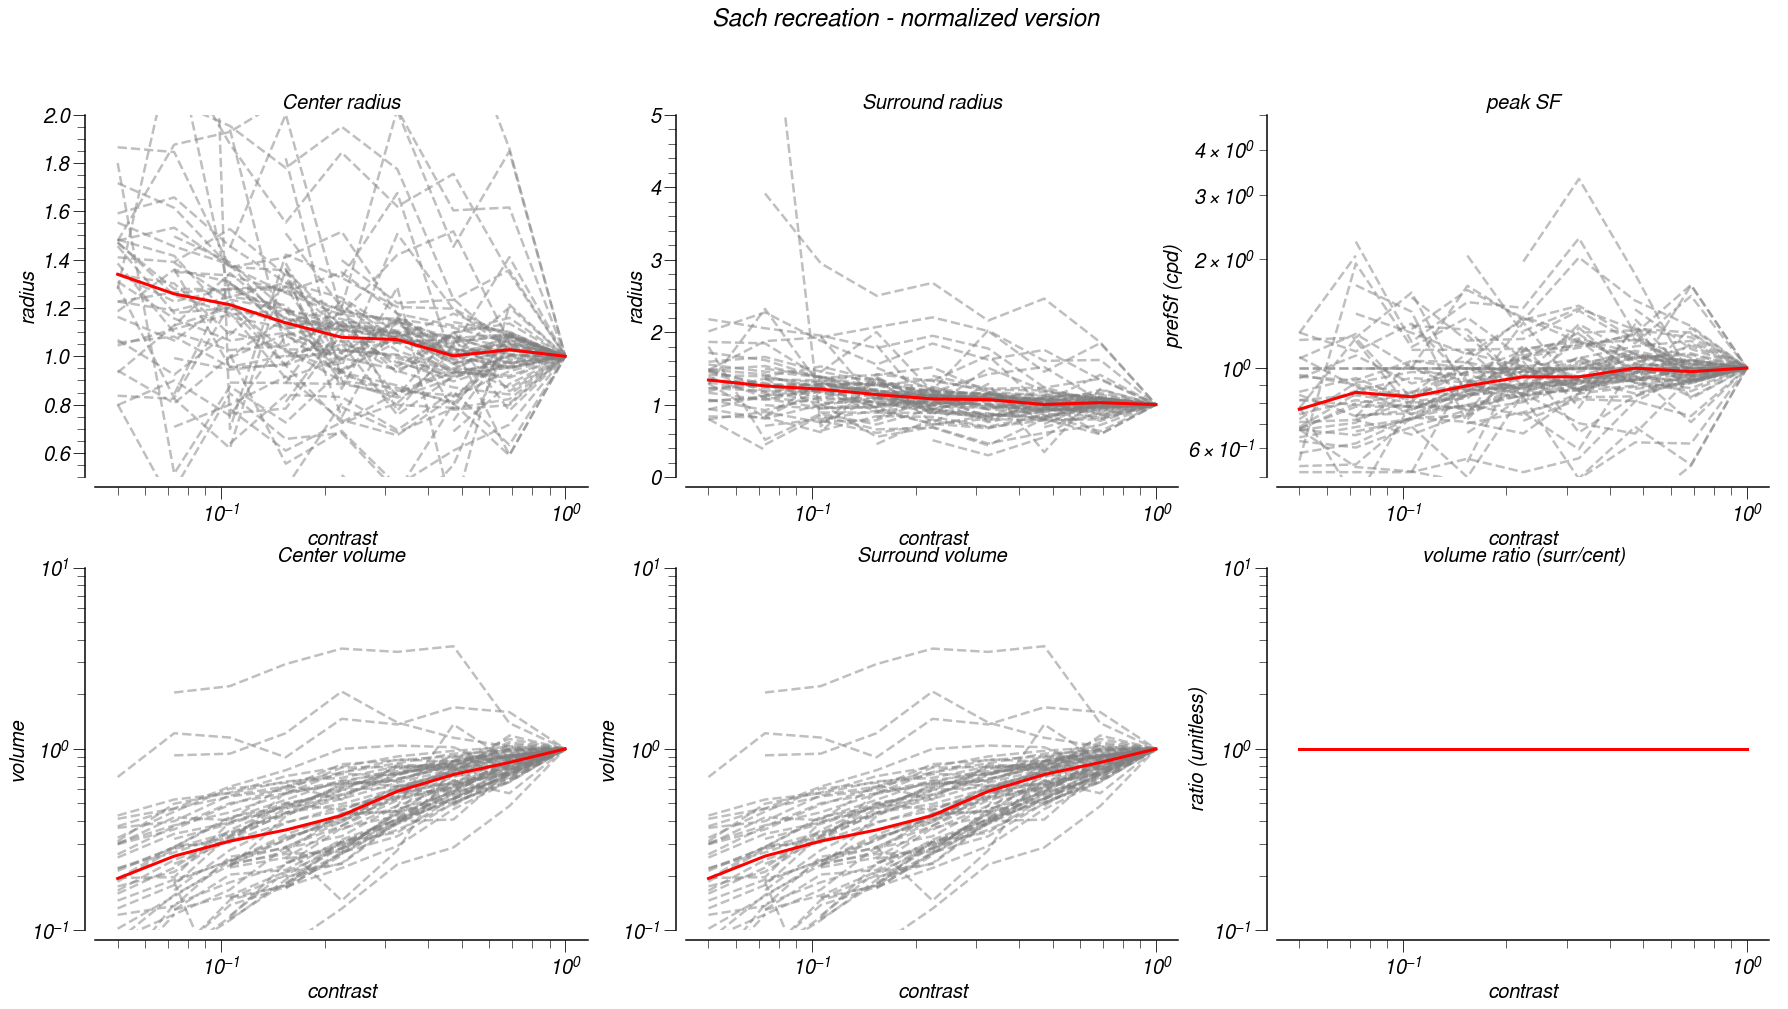

In [1862]:
f, ax = plt.subplots(2, 3, figsize=(30, 15))

gray = cm.gray(0.5) # mean gray

# center freq
plt.subplot(2, 3, 1);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rc_norm[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    rc_medians = np.nanmedian(all_rc_norm[myInds], 0);
    plt.plot(myCons, rc_medians[~np.isnan(rc_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    rc_medians = np.nanmedian(all_rc_norm[sachInds], 0);
    plt.plot(sachCons, rc_medians, 'k', linewidth=3, label='sach')
plt.ylim([0.5, 2]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround freq
plt.subplot(2, 3, 2);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rs_norm[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    rs_medians = np.nanmedian(all_rs_norm[myInds], 0);
    plt.plot(myCons, rs_medians[~np.isnan(rs_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    rs_medians = np.nanmedian(all_rs_norm[sachInds], 0);
    plt.plot(sachCons, rs_medians, 'k', linewidth=3, label='sach')
plt.ylim([0, 5]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

# peak SF
plt.subplot(2, 3, 3);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_psf_norm[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    psf_medians = np.nanmedian(all_psf_norm[myInds], 0);
    plt.plot(myCons, psf_medians[~np.isnan(psf_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    psf_medians = np.nanmedian(all_psf_norm[sachInds], 0);
    plt.plot(sachCons, psf_medians, 'k', linewidth=3, label='sach') 
plt.ylim([5e-1, 5e0]);
plt.xlabel('contrast');
plt.ylabel('prefSf (cpd)')
plt.title('peak SF')
plt.xscale('log')
plt.yscale('log')

# center volume
plt.subplot(2, 3, 4);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_volc_norm[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    volc_medians = np.nanmedian(all_volc_norm[myInds], 0);
    plt.plot(myCons, volc_medians[~np.isnan(volc_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    volc_medians = np.nanmedian(all_volc_norm[sachInds], 0);
    plt.plot(sachCons, volc_medians, 'k', linewidth=3, label='sach') 
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Center volume')
plt.xscale('log')
plt.yscale('log')

# surround volume
plt.subplot(2, 3, 5);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_vols_norm[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    vols_medians = np.nanmedian(all_vols_norm[myInds], 0);
    plt.plot(myCons, vols_medians[~np.isnan(vols_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    vols_medians = np.nanmedian(all_vols_norm[sachInds], 0);
    plt.plot(sachCons, vols_medians, 'k', linewidth=3, label='sach') 
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Surround volume')
plt.xscale('log')
plt.yscale('log')

# volume ratio
plt.subplot(2, 3, 6);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_volrat_norm[i, con_inds], '--', color=gray, alpha=0.5)
# my median
if myInds is not None:
    volrat_medians = np.nanmedian(all_volrat_norm[myInds], 0);
    plt.plot(myCons, volrat_medians[~np.isnan(volrat_medians)], 'r', linewidth=3, label='mine')
# sach median
if sachInds is not None:
    volrat_medians = np.nanmedian(all_volrat_norm[sachInds], 0);
    plt.plot(sachCons, volrat_medians, 'k', linewidth=3, label='sach');
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('ratio (unitless)')
plt.title('volume ratio (surr/cent)')
plt.xscale('log')
plt.yscale('log')

f.suptitle('Sach recreation - normalized version')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

saveName = "/sach_norm%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### Let's plot ratios!

Let's make scatter plots of each the ratios for each cell's tuning - evaluated at highest/lowest valid contrasts

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in greater


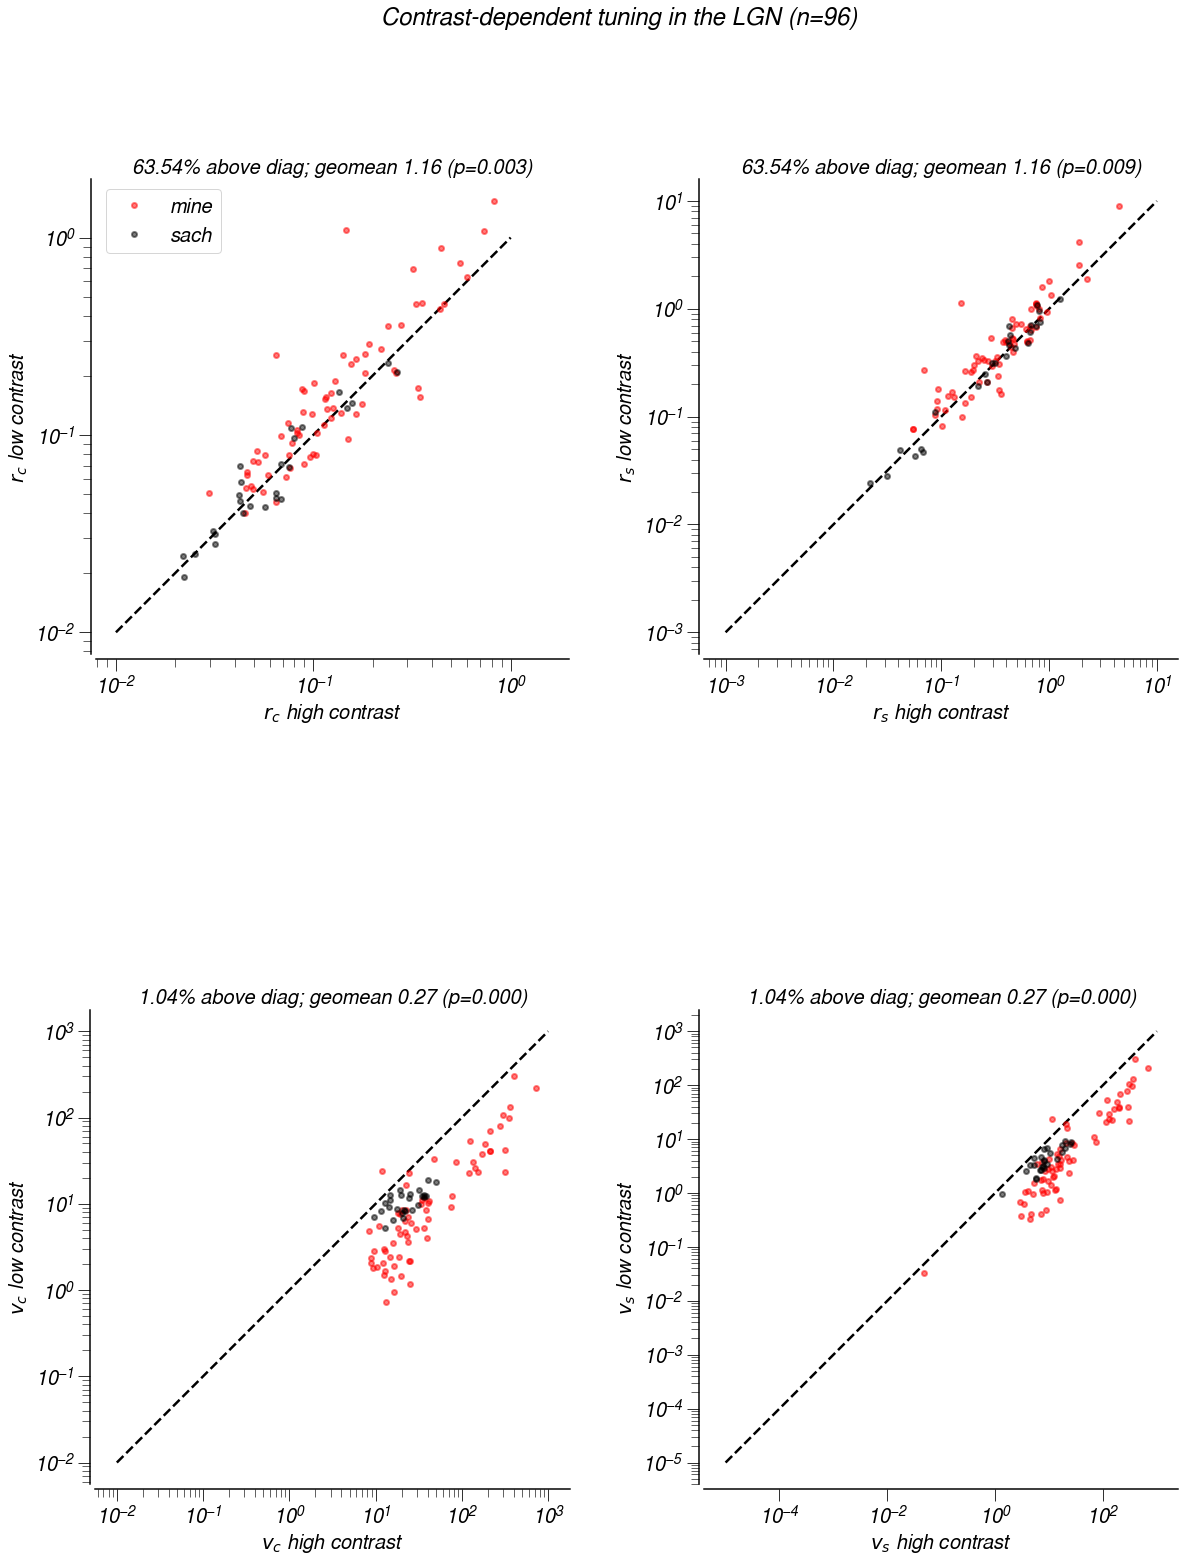

In [1666]:
ctrR_rats = np.nan*np.zeros((n_cells, ));
surR_rats = np.nan*np.zeros((n_cells, ));
ctrVol_rats = np.nan*np.zeros((n_cells, ));
surVol_rats = np.nan*np.zeros((n_cells, ));
# also save the indices into all_* for later analysis
extremaInds = np.zeros((n_cells, 2), dtype='int32');

nr, nc = 2, 2;
f, ax = plt.subplots(nr, nc, figsize=(10*nc, 12*nr))

for i in range(n_cells):
    ii = i
    
    # take into account that not all cells are necessarily in descrFits, but all will be in all[Con[[byDisp]]][sf][disp]
#     ii = val_cells[i]

    ### center radius - and generally, which contrasts are valid (i.e. varExpl above threshold)
    curr_radii = all_rc[ii, :];
    # first, label/extras:
    if i == 0:
        ax[0, 0].set_xlabel('$r_c$ high contrast')
        ax[0, 0].set_ylabel('$r_c$ low contrast')
        ax[0, 0].plot([1e-2, 1e0], [1e-2, 1e0], 'k--')
        sns.despine(offset=5, ax=ax[0, 0])
    # now, get the actual data
    non_nan = np.where(~np.isnan(curr_radii))[0];
    if len(non_nan) < 2:
        continue;
    extrema_ind = [non_nan[0], non_nan[-1]] # low con, high con
    extremaInds[ii, :] = extrema_ind
    low_r, high_r = curr_radii[extrema_ind[0]], curr_radii[extrema_ind[1]]
    ctrR_rats[ii] = np.divide(low_r, high_r);
    ax[0, 0].plot(high_r, low_r, 'o', alpha=0.5, color=clrs[ii], label=lbls[ii]);

    ### surround radius
    curr_radii = all_rs[ii, :];
    # first, label/extras:
    if i == 0:
        ax[0, 1].set_xlabel('$r_s$ high contrast')
        ax[0, 1].set_ylabel('$r_s$ low contrast')
        ax[0, 1].plot([1e-3, 1e1], [1e-3, 1e1], 'k--')
        sns.despine(offset=5, ax=ax[0, 1])
    # now, get the actual data
    low_r, high_r = curr_radii[extrema_ind[0]], curr_radii[extrema_ind[1]]
    surR_rats[ii] = np.divide(low_r, high_r);
    ax[0, 1].plot(high_r, low_r, 'ko', alpha=0.5, color=clrs[ii]);
    
    ### center volume
    curr_vol = all_volc[ii, :];
    # first, label/extras:
    if i == 0:
        ax[1, 0].set_xlabel('$v_c$ high contrast')
        ax[1, 0].set_ylabel('$v_c$ low contrast')
        ax[1, 0].plot([1e-2, 1e3], [1e-2, 1e3], 'k--')
        sns.despine(offset=5, ax=ax[1, 0])
    # now, get the actual data
    low_v, high_v = curr_vol[extrema_ind[0]], curr_vol[extrema_ind[1]]
    ctrVol_rats[ii] = np.divide(low_v, high_v);
    ax[1, 0].plot(high_v, low_v, 'ko', alpha=0.5, color=clrs[ii]);
    
    ### surround volume
    curr_vol = all_vols[ii, :];
    # first, label/extras:
    if i == 0:
        ax[1, 1].set_xlabel('$v_s$ high contrast')
        ax[1, 1].set_ylabel('$v_s$ low contrast')
        ax[1, 1].plot([1e-5, 1e3], [1e-5, 1e3], 'k--')
        sns.despine(offset=5, ax=ax[1, 1])
    # now, get the actual data
    low_v, high_v = curr_vol[extrema_ind[0]], curr_vol[extrema_ind[1]]
    surVol_rats[ii] = np.divide(low_v, high_v);
    ax[1, 1].plot(high_v, low_v, 'ko', alpha=0.5, color=clrs[ii]);

### general plotting
for inds in itertools.product(range(nr), range(nc)):
    ax[inds].set_xscale('log')
    ax[inds].set_yscale('log')
    ax[inds].axis('square')
    
### now, titles, some analysis
## center radius
nn_inds = np.where(~np.isnan(ctrR_rats));
non_nan = ctrR_rats[nn_inds]
ctrR_gt1 = sum(ctrR_rats>1);
# - get pval on paired t-test
idx_low = zip(range(n_cells), extremaInds[:, 0])
low_cr = np.array([all_rc[x] for x in idx_low])
idx_high = zip(range(n_cells), extremaInds[:, 1])
high_cr = np.array([all_rc[x] for x in idx_high])
pval_cr = paired_ttest(low_cr[nn_inds], high_cr[nn_inds])
# now set title
ax[0, 0].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*ctrR_gt1/len(non_nan), geomean(non_nan), pval_cr.pvalue));
# -- and legend
ax[0, 0].legend();

## surround radius
non_nan = surR_rats[~np.isnan(surR_rats)]
surR_gt1 = sum(surR_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_sr = np.array([all_rs[x] for x in idx_low])
high_sr = np.array([all_rs[x] for x in idx_high])
pval_sr = paired_ttest(low_sr[nn_inds], high_sr[nn_inds])
# now set title
ax[0, 1].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*surR_gt1/len(non_nan), geomean(non_nan), pval_sr.pvalue));

## center vol
non_nan = ctrVol_rats[~np.isnan(ctrVol_rats)]
ctrVol_gt1 = sum(ctrVol_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_vc = np.array([all_volc[x] for x in idx_low])
high_vc = np.array([all_volc[x] for x in idx_high])
pval_vc = paired_ttest(low_vc[nn_inds], high_vc[nn_inds])
ax[1, 0].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*ctrVol_gt1/len(non_nan), geomean(non_nan), pval_vc.pvalue));

## surround vol
non_nan = surVol_rats[~np.isnan(surVol_rats)]
surVol_gt1 = sum(surVol_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_vs = np.array([all_vols[x] for x in idx_low])
high_vs = np.array([all_vols[x] for x in idx_high])
pval_vs = paired_ttest(low_vs[nn_inds], high_vs[nn_inds])
ax[1, 1].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*surVol_gt1/len(non_nan), geomean(non_nan), pval_vs.pvalue));

f.suptitle('Contrast-dependent tuning in the LGN (n=%d)' % len(non_nan));
f.subplots_adjust(wspace=0.2, hspace=0.75);

saveName = "/dog_conDep%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


Now the same, but colored by cell type?

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in greater


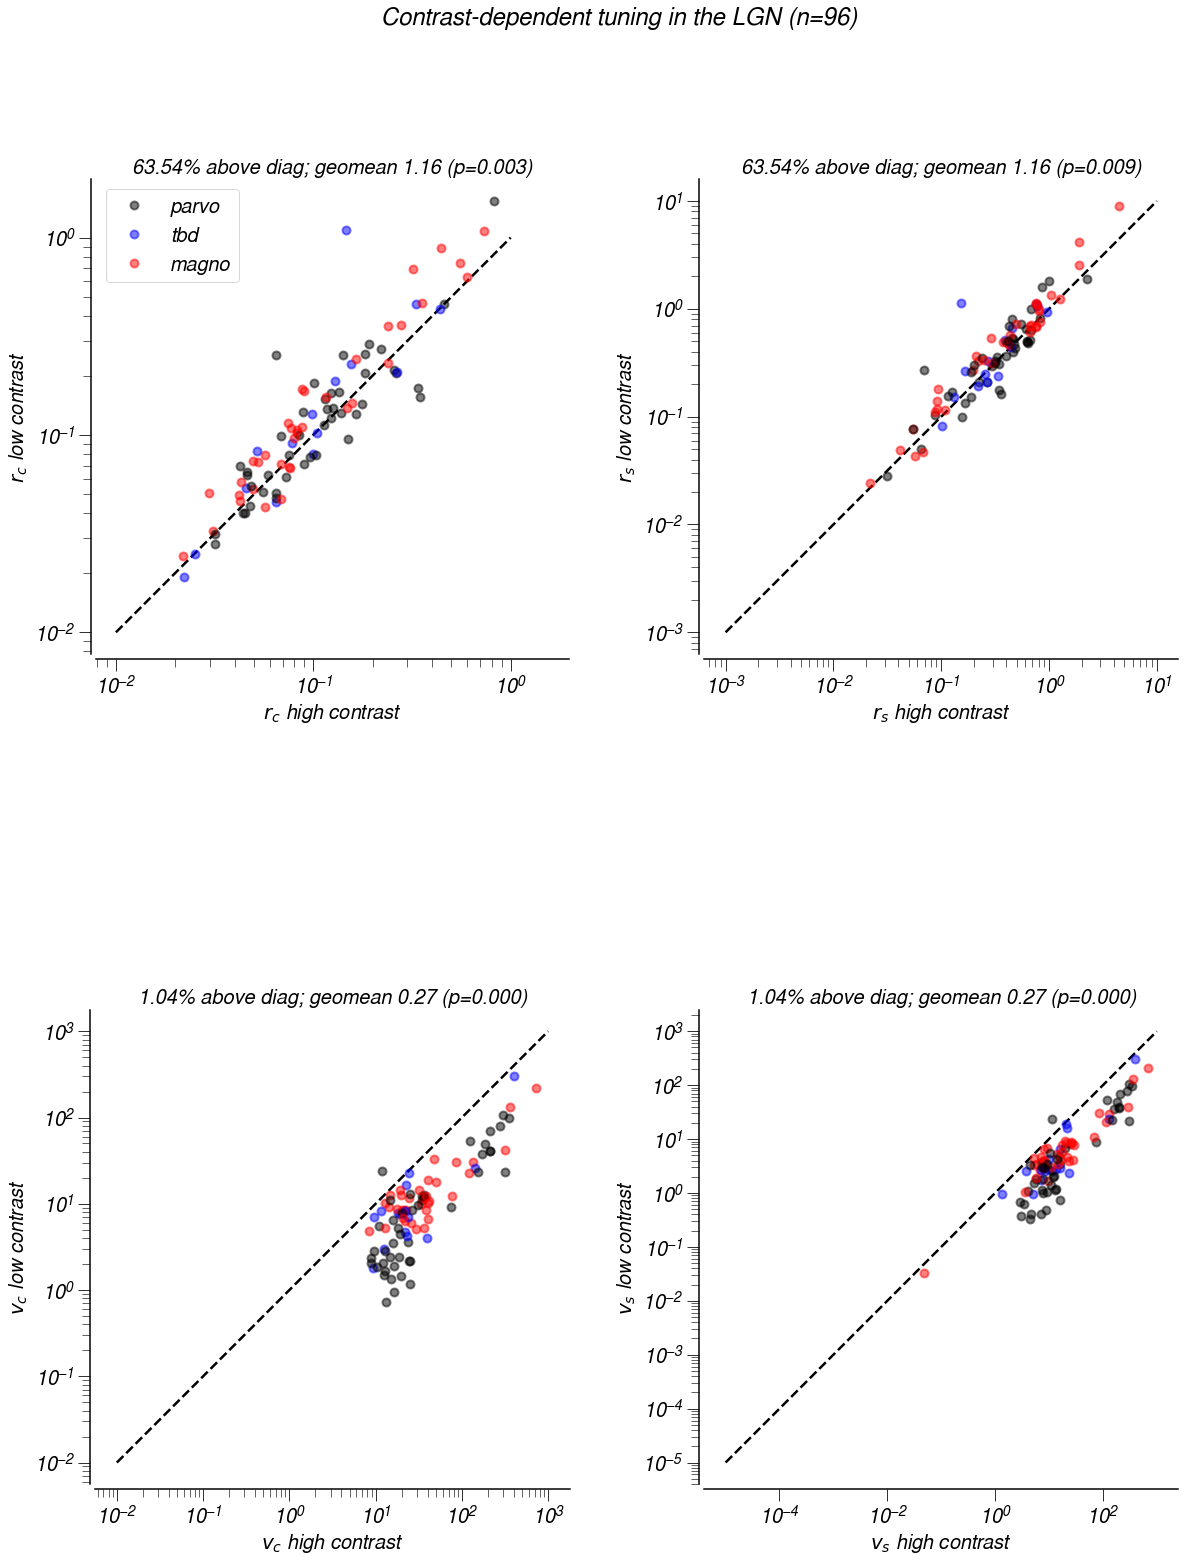

In [1669]:
ctrR_rats = np.nan*np.zeros((n_cells, ));
surR_rats = np.nan*np.zeros((n_cells, ));
ctrVol_rats = np.nan*np.zeros((n_cells, ));
surVol_rats = np.nan*np.zeros((n_cells, ));
# also save the indices into all_* for later analysis
extremaInds = np.zeros((n_cells, 2), dtype='int32');

nr, nc = 2, 2;
f, ax = plt.subplots(nr, nc, figsize=(10*nc, 12*nr))

for i in range(n_cells):
    ii = i;
    
    # take into account that not all cells are necessarily in descrFits, but all will be in all[Con[[byDisp]]][sf][disp]
#     ii = val_cells[i]

    ### center radius - and generally, which contrasts are valid (i.e. varExpl above threshold)
    curr_radii = all_rc[ii, :];
    # first, label/extras:
    if i == 0:
        ax[0, 0].set_xlabel('$r_c$ high contrast')
        ax[0, 0].set_ylabel('$r_c$ low contrast')
        ax[0, 0].plot([1e-2, 1e0], [1e-2, 1e0], 'k--')
        sns.despine(offset=5, ax=ax[0, 0])
    # now, get the actual data
    non_nan = np.where(~np.isnan(curr_radii))[0];
    if len(non_nan) < 2:
        continue;
    extrema_ind = [non_nan[0], non_nan[-1]] # low con, high con
    extremaInds[ii, :] = extrema_ind
    low_r, high_r = curr_radii[extrema_ind[0]], curr_radii[extrema_ind[1]]
    ctrR_rats[ii] = np.divide(low_r, high_r);
    ax[0, 0].plot(high_r, low_r, 'o', alpha=0.5, color=clrs_type[ii], label=lbls_type[ii], markersize=8);

    ### surround radius
    curr_radii = all_rs[ii, :];
    # first, label/extras:
    if i == 0:
        ax[0, 1].set_xlabel('$r_s$ high contrast')
        ax[0, 1].set_ylabel('$r_s$ low contrast')
        ax[0, 1].plot([1e-3, 1e1], [1e-3, 1e1], 'k--')
        sns.despine(offset=5, ax=ax[0, 1])
    # now, get the actual data
    low_r, high_r = curr_radii[extrema_ind[0]], curr_radii[extrema_ind[1]]
    surR_rats[ii] = np.divide(low_r, high_r);
    ax[0, 1].plot(high_r, low_r, 'o', alpha=0.5, color=clrs_type[ii], markersize=8);
    
    ### center volume
    curr_vol = all_volc[ii, :];
    # first, label/extras:
    if i == 0:
        ax[1, 0].set_xlabel('$v_c$ high contrast')
        ax[1, 0].set_ylabel('$v_c$ low contrast')
        ax[1, 0].plot([1e-2, 1e3], [1e-2, 1e3], 'k--')
        sns.despine(offset=5, ax=ax[1, 0])
    # now, get the actual data
    low_v, high_v = curr_vol[extrema_ind[0]], curr_vol[extrema_ind[1]]
    ctrVol_rats[ii] = np.divide(low_v, high_v);
    ax[1, 0].plot(high_v, low_v, 'o', alpha=0.5, color=clrs_type[ii], markersize=8);
    
    ### surround volume
    curr_vol = all_vols[ii, :];
    # first, label/extras:
    if i == 0:
        ax[1, 1].set_xlabel('$v_s$ high contrast')
        ax[1, 1].set_ylabel('$v_s$ low contrast')
        ax[1, 1].plot([1e-5, 1e3], [1e-5, 1e3], 'k--')
        sns.despine(offset=5, ax=ax[1, 1])
    # now, get the actual data
    low_v, high_v = curr_vol[extrema_ind[0]], curr_vol[extrema_ind[1]]
    surVol_rats[ii] = np.divide(low_v, high_v);
    ax[1, 1].plot(high_v, low_v, 'o', alpha=0.5, color=clrs_type[ii], markersize=8);

### general plotting
for inds in itertools.product(range(nr), range(nc)):
    ax[inds].set_xscale('log')
    ax[inds].set_yscale('log')
    ax[inds].axis('square')
    
### now, titles, some analysis
## center radius
nn_inds = np.where(~np.isnan(ctrR_rats));
non_nan = ctrR_rats[nn_inds]
ctrR_gt1 = sum(ctrR_rats>1);
# - get pval on paired t-test
idx_low = zip(range(n_cells), extremaInds[:, 0])
low_cr = np.array([all_rc[x] for x in idx_low])
idx_high = zip(range(n_cells), extremaInds[:, 1])
high_cr = np.array([all_rc[x] for x in idx_high])
pval_cr = paired_ttest(low_cr[nn_inds], high_cr[nn_inds])
# now set title
ax[0, 0].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*ctrR_gt1/len(non_nan), geomean(non_nan), pval_cr.pvalue));
ax[0, 0].legend();

## surround radius
non_nan = surR_rats[~np.isnan(surR_rats)]
surR_gt1 = sum(surR_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_sr = np.array([all_rs[x] for x in idx_low])
high_sr = np.array([all_rs[x] for x in idx_high])
pval_sr = paired_ttest(low_sr[nn_inds], high_sr[nn_inds])
# now set title
ax[0, 1].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*surR_gt1/len(non_nan), geomean(non_nan), pval_sr.pvalue));

## center vol
non_nan = ctrVol_rats[~np.isnan(ctrVol_rats)]
ctrVol_gt1 = sum(ctrVol_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_vc = np.array([all_volc[x] for x in idx_low])
high_vc = np.array([all_volc[x] for x in idx_high])
pval_vc = paired_ttest(low_vc[nn_inds], high_vc[nn_inds])
ax[1, 0].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*ctrVol_gt1/len(non_nan), geomean(non_nan), pval_vc.pvalue));

## surround vol
non_nan = surVol_rats[~np.isnan(surVol_rats)]
surVol_gt1 = sum(surVol_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_vs = np.array([all_vols[x] for x in idx_low])
high_vs = np.array([all_vols[x] for x in idx_high])
pval_vs = paired_ttest(low_vs[nn_inds], high_vs[nn_inds])
ax[1, 1].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*surVol_gt1/len(non_nan), geomean(non_nan), pval_vs.pvalue));

f.suptitle('Contrast-dependent tuning in the LGN (n=%d)' % len(non_nan));
f.subplots_adjust(wspace=0.2, hspace=0.75);

saveName = "/dog_conDep%s%s_byType.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


### Compute and plot peak SF

First, just get the already-computed prefSF -- the next section is using a simple model which fits the measured psf vs. con to infer the psf slope/change at any contrast (that has not yet been updated to handle both data sets)

In [1670]:
# get associated index for V1 contrast levels
v1_lowCon = 0.33
v1_lowInd = [np.argmin(np.square(x-v1_lowCon)) for x in all_cVals]

v1_highCon = 1
v1_highInd = [np.argmin(np.square(x-v1_highCon)) for x in all_cVals]

In [1671]:
# NOTE: USES FULL descFit, will not work with just params

# # peak SF v. contrast
# n_singleCons = all_psf.shape[1]
# psf_geo = np.nan * np.zeros((n_singleCons, ))
# psf_norm_geo = np.nan * np.zeros((n_singleCons, ))
# for i in range(n_singleCons):
#     non_nans = np.where(~np.isnan(all_psf[:, i]))[0]
#     if len(non_nans) > 0:
#         psf_geo[i] = geomean(all_psf[non_nans, i])
#         psf_norm_geo[i] = geomean(all_psf_norm[non_nans, i])

# ratio of peak SF at high:low contrast
psf_ratios = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
psf_ratios_V1 = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
for i in range(n_cells):
    non_nans = np.where(~np.isnan(all_psf[i]))[0]
    if len(non_nans) < 2:
        continue;
        
    min_con = non_nans[0];
    max_con = non_nans[-1];

    psf_ratios[i, 0] = all_psf[i, max_con] / all_psf[i, min_con];
    psf_ratios_V1[i, 0] = all_psf[i, v1_highInd[i]] / all_psf[i, v1_lowInd[i]];
    if allTypes[i] == 'parvo':
        psf_ratios[i, 1] = psf_ratios[i, 0];
        psf_ratios_V1[i, 1] = psf_ratios_V1[i, 0];
    if allTypes[i] == 'magno':
        psf_ratios[i, 2] = psf_ratios[i, 0];
        psf_ratios_V1[i, 2] = psf_ratios_V1[i, 0];
    if allTypes[i] == 'tbd':
        psf_ratios[i, 3] = psf_ratios[i, 0];
        psf_ratios_V1[i, 3] = psf_ratios_V1[i, 0];
    
val_ratios_all = psf_ratios[~np.isnan(psf_ratios[:, 0]), 0]
val_ratios_p = psf_ratios[~np.isnan(psf_ratios[:, 1]), 1]
val_ratios_m = psf_ratios[~np.isnan(psf_ratios[:, 2]), 2]
val_ratios_tbd = psf_ratios[~np.isnan(psf_ratios[:, 3]), 3]

val_ratiosV1_all = psf_ratios_V1[~np.isnan(psf_ratios_V1[:, 0]), 0]
val_ratiosV1_p = psf_ratios_V1[~np.isnan(psf_ratios_V1[:, 1]), 1]
val_ratiosV1_m = psf_ratios_V1[~np.isnan(psf_ratios_V1[:, 2]), 2]
val_ratiosV1_tbd = psf_ratios_V1[~np.isnan(psf_ratios_V1[:, 3]), 3]

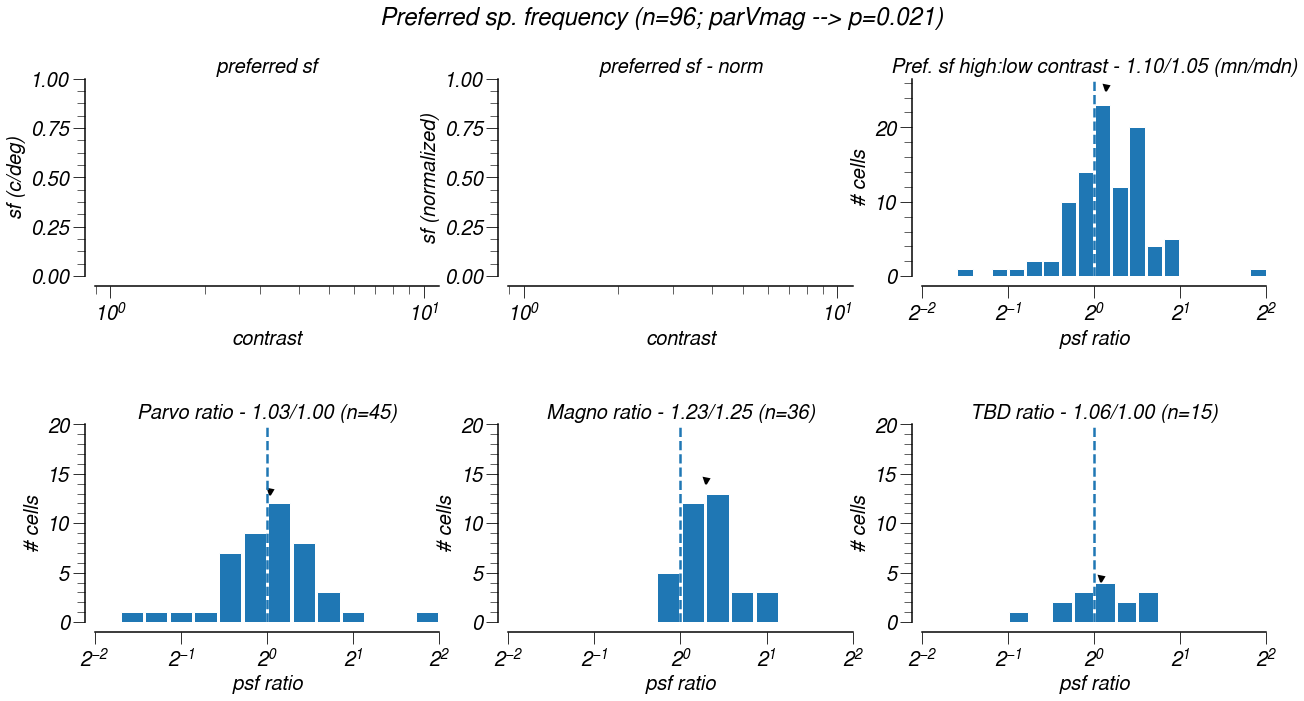

In [1672]:
### highest/lowest contrasts overall

# yes - lazy, but do it for now (manually set ylim for bottom row)
ylm = 20;

nrow = 2;
ncol = 3;
f, ax = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))

# plot_cons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons

plt.subplot(nrow, ncol, 1)
# plt.plot(plot_cons, cfreq_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (c/deg)')
plt.title('preferred sf');

plt.subplot(nrow, ncol, 2)
# plt.plot(plot_cons, cfreq_norm_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (normalized)')
plt.title('preferred sf - norm');

plt.subplot(nrow, ncol, 3)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 21)
counts, _, _ = plt.hist(val_ratios_all, bins, rwidth=0.9)
ratio_gmean, mdn = geomean(val_ratios_all), np.median(val_ratios_all)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.xscale('log', basex=2)
plt.xlabel('psf ratio')
plt.ylabel('# cells')
plt.title('Pref. sf high:low contrast - %.2f/%.2f (mn/mdn)' % (ratio_gmean, mdn))

plt.subplot(nrow, ncol, 4)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_p, bins, rwidth=0.9)
ratio_gmean, mdn = geomean(val_ratios_p), np.median(val_ratios_p)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, ylm])
plt.xscale('log', basex=2)
plt.xlabel('psf ratio')
plt.ylabel('# cells')
plt.title('Parvo ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, mdn, len(val_ratios_p)))
# get the ylimits here to pass on to the next plots - why here? since more parvo cells than anything, so highest

plt.subplot(nrow, ncol, 5)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_m, bins, rwidth=0.9)
ratio_gmean, mdn = geomean(val_ratios_m), np.median(val_ratios_m)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, ylm])
plt.xscale('log', basex=2)
plt.xlabel('psf ratio')
plt.ylabel('# cells')
plt.title('Magno ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, mdn, len(val_ratios_m)))

plt.subplot(nrow, ncol, 6)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 17)
counts, _, _ = plt.hist(val_ratios_tbd, bins, rwidth=0.9)
ratio_gmean, mdn = geomean(val_ratios_tbd), np.median(val_ratios_tbd)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k', label='gm=%.2f' % ratio_gmean);
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, ylm])
plt.xscale('log', basex=2)
plt.xlabel('psf ratio')
plt.ylabel('# cells')
plt.title('TBD ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, mdn, len(val_ratios_tbd)))

mVp_ksTest = ks2samp(val_ratios_m, val_ratios_p)

f.suptitle('Preferred sp. frequency (n=%d; parVmag --> p=%.3f)' % (len(val_ratios_all), mVp_ksTest.pvalue))
f.subplots_adjust(wspace=0.2, hspace=0.75);

sns.despine(offset=10)

saveName = "/prefSf%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


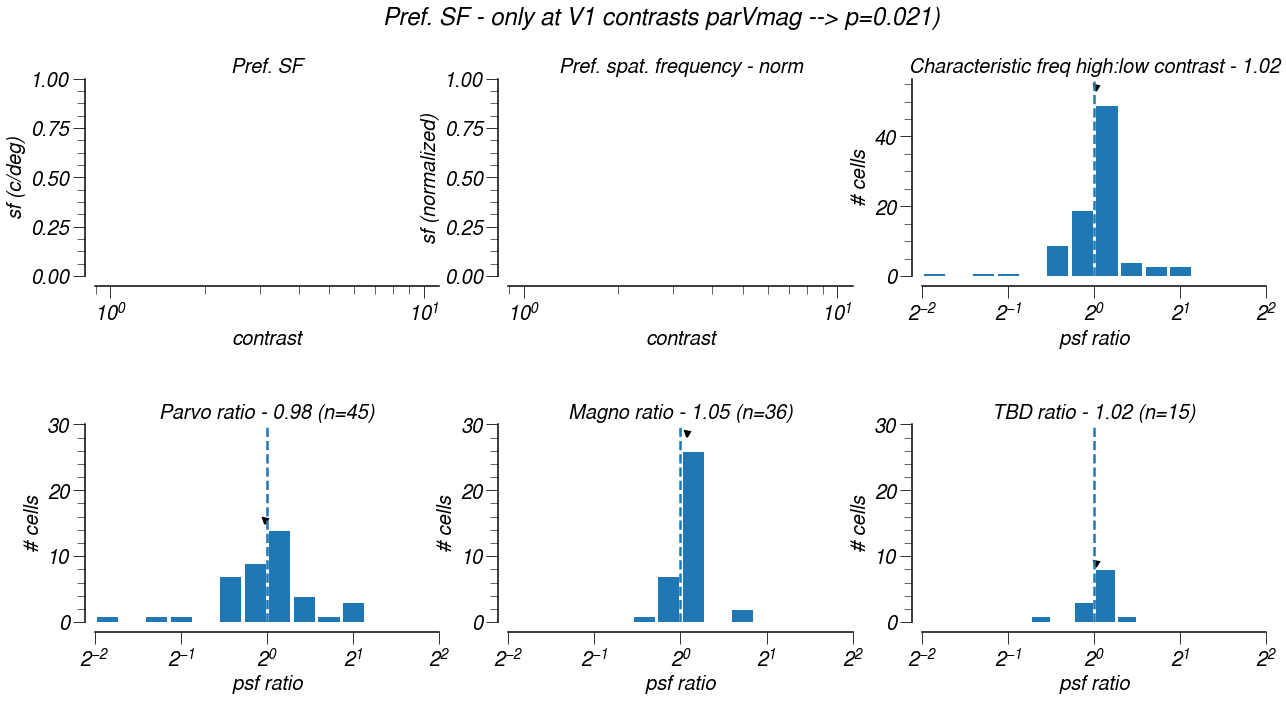

In [1673]:
### V1 contrasts only

# yes - lazy, but do it for now (manually set ylim for bottom row)
ylm = 30;

nrow = 2;
ncol = 3;
f, ax = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))

plot_cons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons

plt.subplot(nrow, ncol, 1)
# plt.plot(plot_cons, cfreq_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (c/deg)')
plt.title('Pref. SF');
plt.subplot(nrow, ncol, 2)
# plt.plot(plot_cons, cfreq_norm_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (normalized)')
plt.title('Pref. spat. frequency - norm');

plt.subplot(nrow, ncol, 3)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratiosV1_all, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratiosV1_all)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])

plt.xscale('log', basex=2)
plt.xlabel('psf ratio')
plt.ylabel('# cells')
plt.title('Characteristic freq high:low contrast - %.2f' % ratio_gmean)

plt.subplot(nrow, ncol, 4)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratiosV1_p, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratiosV1_p)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, ylm])
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('psf ratio')
plt.ylabel('# cells')
plt.title('Parvo ratio - %.2f (n=%d)' % (ratio_gmean, len(val_ratios_p)))
# get the ylimits here to pass on to the next plots - why here? since more parvo cells than anything, so highest

plt.subplot(nrow, ncol, 5)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratiosV1_m, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratiosV1_m)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, ylm])
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('psf ratio')
plt.ylabel('# cells')
plt.title('Magno ratio - %.2f (n=%d)' % (ratio_gmean, len(val_ratios_m)))

plt.subplot(nrow, ncol, 6)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 17)
counts, _, _ = plt.hist(val_ratiosV1_tbd, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratiosV1_tbd)
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, ylm])
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k', label='gm=%.2f' % ratio_gmean);
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('psf ratio')
plt.ylabel('# cells')
plt.title('TBD ratio - %.2f (n=%d)' % (ratio_gmean, len(val_ratios_tbd)))

mVp_ksTest = ks2samp(val_ratios_m, val_ratios_p)

f.suptitle('Pref. SF - only at V1 contrasts parVmag --> p=%.3f)' % (mVp_ksTest.pvalue))
f.subplots_adjust(wspace=0.2, hspace=0.75);

sns.despine(offset=10)

saveName = "/prefSf_v1cons%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


Fix some stuff here with n_cons vs allCons (not all expts have same # of contrasts)

In [865]:
# # NOTE: USES FULL descFit, will not work with just params

# # # peak SF v. contrast
# # n_singleCons = all_psf.shape[1]
# # psf_geo = np.nan * np.zeros((n_singleCons, ))
# # psf_norm_geo = np.nan * np.zeros((n_singleCons, ))
# # for i in range(n_singleCons):
# #     non_nans = np.where(~np.isnan(all_psf[:, i]))[0]
# #     if len(non_nans) > 0:
# #         psf_geo[i] = geomean(all_psf[non_nans, i])
# #         psf_norm_geo[i] = geomean(all_psf_norm[non_nans, i])

# # ratio of peak SF at high:low contrast
# psf_ratios = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
# psf_ratios_V1 = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
# for i in range(n_cells):
#     ii = i;
# #     #     curr_cons = allCons[i];
# #     if i not in descrFits.keys():
# #         continue;

#     ## TODO: Fix -- all_params is just params, but dog_prefSfMod wants full fit structure
#     # // should be able to just 
#     psf_ratios[i, 0], psf_model, opt_params = hf.dog_prefSfMod(all_params[i], curr_cons, dog_model=DoGmodel)
#     if np.isnan(psf_ratios[i, 0]):
#         continue;
#     #######    
#     # peak ratio only at the v1 contrasts (100% [index -1], 32.5%)
#     ######
#     singleCons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons
#     v1_conInds = [np.argmin(np.square(singleCons-0.33)), np.argmin(np.square(singleCons-1))]

#     v1_extrema = psf_model(*opt_params, con=(curr_cons[v1_conInds[0]], curr_cons[v1_conInds[-1]]));
#     psf_ratios_V1[i, 0] = v1_extrema[-1] / v1_extrema[0];
#     if dataList['unitType'][i] == 'parvo':
#         psf_ratios[i, 1] = psf_ratios[i, 0];
#         psf_ratios_V1[i, 1] = psf_ratios_V1[i, 0];
#     if dataList['unitType'][i] == 'magno':
#         psf_ratios[i, 2]  = psf_ratios[i, 0];
#         psf_ratios_V1[i, 2] = psf_ratios_V1[i, 0];
#     if dataList['unitType'][i] == 'tbd':
#         psf_ratios[i, 3] = psf_ratios[i, 0];
#         psf_ratios_V1[i, 3] = psf_ratios_V1[i, 0];
        
# val_ratios_all = psf_ratios[~np.isnan(psf_ratios[:, 0]), 0]
# val_ratios_p = psf_ratios[~np.isnan(psf_ratios[:, 1]), 1]
# val_ratios_m = psf_ratios[~np.isnan(psf_ratios[:, 2]), 2]
# val_ratios_tbd = psf_ratios[~np.isnan(psf_ratios[:, 3]), 3]

# val_ratiosV1_all = psf_ratios_V1[~np.isnan(psf_ratios_V1[:, 0]), 0]
# val_ratiosV1_p = psf_ratios_V1[~np.isnan(psf_ratios_V1[:, 1]), 1]
# val_ratiosV1_m = psf_ratios_V1[~np.isnan(psf_ratios_V1[:, 2]), 2]
# val_ratiosV1_tbd = psf_ratios_V1[~np.isnan(psf_ratios_V1[:, 3]), 3]

In [866]:
# nrow = 2;
# ncol = 3;
# f, ax = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow))

# plot_cons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons

# plt.subplot(nrow, ncol, 1)
# plt.plot(plot_cons, psf_geo, 'o')
# plt.xscale('log')
# plt.xlabel('contrast')
# plt.ylabel('sf (cpd)')
# plt.title('SF peak');

# plt.subplot(nrow, ncol, 2)
# plt.plot(plot_cons, psf_norm_geo, 'o')
# plt.xscale('log')
# plt.xlabel('contrast')
# plt.ylabel('sf (normalized)')
# plt.title('SF peak - normalized');

# plt.subplot(nrow, ncol, 3)
# bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
# counts, _, _ = plt.hist(val_ratios_all, bins, rwidth=0.9)
# ratio_gmean = geomean(val_ratios_all)
# plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
# plt.axvline(1, ls='--')
# plt.xscale('log', basex=2)
# plt.xlabel('pSf ratio')
# plt.ylabel('# cells')
# plt.title('peak SF at high:low contrast - %.2f' % ratio_gmean)

# plt.subplot(nrow, ncol, 4)
# bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
# counts, _, _ = plt.hist(val_ratios_p, bins, rwidth=0.9)
# ratio_gmean = geomean(val_ratios_p)
# plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
# plt.axvline(1, ls='--')
# plt.xscale('log', basex=2)
# plt.xlabel('pSf ratio')
# plt.ylabel('# cells')
# plt.title('Parvo SF ratio - %.2f' % ratio_gmean)

# plt.subplot(nrow, ncol, 5)
# bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
# counts, _, _ = plt.hist(val_ratios_m, bins, rwidth=0.9)
# ratio_gmean = geomean(val_ratios_m)
# plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
# plt.axvline(1, ls='--')
# plt.xscale('log', basex=2)
# plt.xlabel('pSf ratio')
# plt.ylabel('# cells')
# plt.title('Magno SF ratio - %.2f' % ratio_gmean)

# plt.subplot(nrow, ncol, 6)
# bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
# counts, _, _ = plt.hist(val_ratios_tbd, bins, rwidth=0.9)
# ratio_gmean = geomean(val_ratios_tbd)
# plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
# plt.axvline(1, ls='--')
# plt.xscale('log', basex=2)
# plt.xlabel('pSf ratio')
# plt.ylabel('# cells')
# plt.title('TBD SF ratio - %.2f' % ratio_gmean)

# f.suptitle('Peak SF response')
# f.subplots_adjust(wspace=0.2, hspace=0.75);

# sns.despine(offset=10)

# saveName = "/peakSF%s%s.pdf" % (mod_suff, loss_suff)
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

In [867]:
# nrow = 2;
# ncol = 3;
# f, ax = plt.subplots(nrow, ncol, figsize=(5*ncol, 3*nrow))

# plot_cons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons

# plt.subplot(nrow, ncol, 1)
# plt.plot(plot_cons, psf_geo, 'o')
# plt.xscale('log')
# plt.xlabel('contrast')
# plt.ylabel('sf (cpd)')
# plt.title('SF peak');

# plt.subplot(nrow, ncol, 2)
# plt.plot(plot_cons, psf_norm_geo, 'o')
# plt.xscale('log')
# plt.xlabel('contrast')
# plt.ylabel('sf (normalized)')
# plt.title('SF peak - normalized');

# plt.subplot(nrow, ncol, 3)
# bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
# counts, _, _ = plt.hist(val_ratiosV1_all, bins, rwidth=0.9)
# ratio_gmean = geomean(val_ratiosV1_all)
# plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
# plt.axvline(1, ls='--')
# plt.xscale('log', basex=2)
# plt.xlabel('pSf ratio')
# plt.ylabel('# cells')
# plt.title('peak SF at high:low contrast - %.2f' % ratio_gmean)

# plt.subplot(nrow, ncol, 4)
# bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
# counts, _, _ = plt.hist(val_ratiosV1_p, bins, rwidth=0.9)
# ratio_gmean = geomean(val_ratiosV1_p)
# plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
# plt.axvline(1, ls='--')
# plt.xscale('log', basex=2)
# plt.xlabel('pSf ratio')
# plt.ylabel('# cells')
# plt.title('Parvo SF ratio - %.2f' % ratio_gmean)

# plt.subplot(nrow, ncol, 5)
# bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
# counts, _, _ = plt.hist(val_ratiosV1_m, bins, rwidth=0.9)
# ratio_gmean = geomean(val_ratiosV1_m)
# plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
# plt.axvline(1, ls='--')
# plt.xscale('log', basex=2)
# plt.xlabel('pSf ratio')
# plt.ylabel('# cells')
# plt.title('Magno SF ratio - %.2f' % ratio_gmean)

# ax = plt.subplot(nrow, ncol, 6)
# bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
# counts, _, _ = plt.hist(val_ratiosV1_tbd, bins, rwidth=0.9)
# ratio_gmean = geomean(val_ratiosV1_tbd)
# plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
# plt.axvline(1, ls='--')
# plt.xscale('log', basex=2)
# plt.xlabel('pSf ratio')
# plt.ylabel('# cells')
# plt.title('TBD SF ratio - %.2f' % ratio_gmean)

# f.suptitle('Peak SF response - only at V1 contrasts')
# f.subplots_adjust(wspace=0.5, hspace=0.75);

# sns.despine(offset=10)

# saveName = "/peakSF_v1cons%s%s.pdf" % (mod_suff, loss_suff)
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

### Relating SF tuning to gain control

We can use phase advance as a proxy for strength of gain control, and relate phase advance to the change in peak contrast, for example

In [868]:
# disp = 0; # just do disp = 0 (single gratings)

# meanPhAdv =[np.nanmean(phFits[x]['phAdv']) for x in val_cells]
# bestPhAdv =[np.nanmax(phFits[x]['phAdv']) for x in val_cells]

# meanConGain =[np.nanmean(rvcFits[x][disp]['conGain']) if disp in rvcFits[x] else np.nan for x in val_cells]
# bestConGain =[np.nanmax(rvcFits[x][disp]['conGain']) if disp in rvcFits[x] else np.nan for x in val_cells]

# meanVarExpl = [np.nanmean(descrFits[x]['varExpl'][0, :]) for x in val_cells]
# varAsInd = np.round(meanVarExpl).astype('int32')
# varRange = np.max(varAsInd) - np.min(varAsInd);

### Plot characteristic frequency

Characteristic frequency ($1/2\pi r_c$), which we fit, is a measure of the high-frequency cut-off of the SF tuning curve. For cells that are low-pass (rather than bandpass) this is a more reliable measure.

In [1674]:
# Center frequency v. contrast
# n_single
# n_singleCons = all_psf.shape[1]

# cfreq_geo = np.nan * np.zeros((n_singleCons, ))
# cfreq_norm_geo = np.nan * np.zeros((n_singleCons, ))
# for i in range(n_singleCons):
#     non_nans = np.where(~np.isnan(all_rc[:, i]))[0]
#     if len(non_nans) > 0:
#         cfreq_geo[i] = geomean(np.divide(1, 2*np.pi*all_rc[non_nans, i]))
# #         cfreq_geo[i] = geomean(np.divide(1, np.pi*all_rc[non_nans, i]))
#         cfreq_norm_geo[i] = geomean(np.divide(1, all_rc_norm[non_nans, i]))
        
# ratio of peak SF at high:low contrast
cfreq_ratios = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
for i in range(n_cells):
    non_nans = np.where(~np.isnan(all_cfr[i]))[0]
    #     non_nans = np.where(~np.isnan(all_rc[i, :]))[0];
    if len(non_nans) < 2:
        continue;
        
    min_con = non_nans[0];
    max_con = non_nans[-1];

    cfreq_ratios[i, 0] = all_cfr[i, max_con] / all_cfr[i, min_con];
    if allTypes[i] == 'parvo':
        cfreq_ratios[i, 1] = cfreq_ratios[i, 0];
    if allTypes[i] == 'magno':
        cfreq_ratios[i, 2] = cfreq_ratios[i, 0];
    if allTypes[i] == 'tbd':
        cfreq_ratios[i, 3] = cfreq_ratios[i, 0];

val_ratios_all = cfreq_ratios[~np.isnan(cfreq_ratios[:, 0]), 0]
val_ratios_p = cfreq_ratios[~np.isnan(cfreq_ratios[:, 1]), 1]
val_ratios_m = cfreq_ratios[~np.isnan(cfreq_ratios[:, 2]), 2]
val_ratios_tbd = cfreq_ratios[~np.isnan(cfreq_ratios[:, 3]), 3]

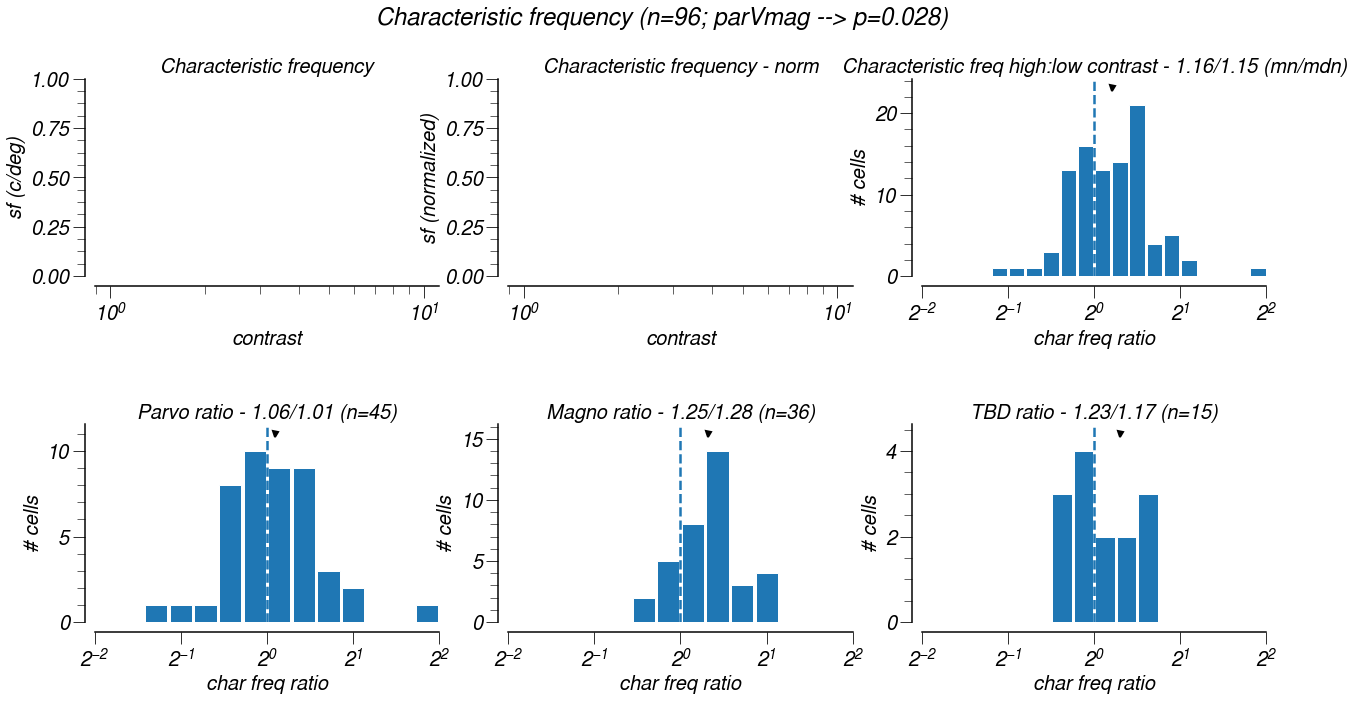

In [1675]:
### highest/lowest

nrow = 2;
ncol = 3;
f, ax = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))

# plot_cons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons

plt.subplot(nrow, ncol, 1)
# plt.plot(plot_cons, cfreq_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (c/deg)')
plt.title('Characteristic frequency');

plt.subplot(nrow, ncol, 2)
# plt.plot(plot_cons, cfreq_norm_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (normalized)')
plt.title('Characteristic frequency - norm');

plt.subplot(nrow, ncol, 3)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 21)
counts, _, _ = plt.hist(val_ratios_all, bins, rwidth=0.9)
ratio_gmean, mdn = geomean(val_ratios_all), np.median(val_ratios_all)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Characteristic freq high:low contrast - %.2f/%.2f (mn/mdn)' % (ratio_gmean, mdn))

plt.subplot(nrow, ncol, 4)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_p, bins, rwidth=0.9)
ratio_gmean, mdn = geomean(val_ratios_p), np.median(val_ratios_p)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Parvo ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, mdn, len(val_ratios_p)))
# get the ylimits here to pass on to the next plots - why here? since more parvo cells than anything, so highest

plt.subplot(nrow, ncol, 5)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_m, bins, rwidth=0.9)
ratio_gmean, mdn = geomean(val_ratios_m), np.median(val_ratios_m)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Magno ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, mdn, len(val_ratios_m)))


plt.subplot(nrow, ncol, 6)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 17)
counts, _, _ = plt.hist(val_ratios_tbd, bins, rwidth=0.9)
ratio_gmean, mdn = geomean(val_ratios_tbd), np.median(val_ratios_tbd)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k', label='gm=%.2f' % ratio_gmean);
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('TBD ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, mdn, len(val_ratios_tbd)))

mVp_ksTest = ks2samp(val_ratios_m, val_ratios_p)

f.suptitle('Characteristic frequency (n=%d; parVmag --> p=%.3f)' % (len(val_ratios_all), mVp_ksTest.pvalue))
f.subplots_adjust(wspace=0.2, hspace=0.75);

sns.despine(offset=10)

saveName = "/charFreq%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


Now the same, but only at the contrasts used in the V1 experiment (100%, 33%)

In [1676]:
v1_lowCon = 0.33
v1_lowInd = [np.argmin(np.square(x-v1_lowCon)) for x in all_cVals]

v1_highCon = 1
v1_highInd = [np.argmin(np.square(x-v1_highCon)) for x in all_cVals]

In [1677]:
# Center frequency v. contrast

# cfreq_geo = np.nan * np.zeros((max_nCons, ))
# cfreq_norm_geo = np.nan * np.zeros((max_nCons, ))
# for i in range(max_nCons):
#     non_nans = np.where(~np.isnan(all_rc[:, i]))[0]
#     if len(non_nans) > 0:
#         cfreq_geo[i] = geomean(np.divide(1, np.pi*all_rc[non_nans, i]))
#         cfreq_norm_geo[i] = geomean(np.divide(1, all_rc_norm[non_nans, i]))
    
        
# ratio of peak SF at high:low contrast
cfreq_ratios = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
for i in range(n_cells):
    non_nans = np.where(~np.isnan(all_rc[i, :]))[0];
    if ~np.any(non_nans == v1_lowInd[i]) or ~np.any(non_nans == v1_highInd[i]):
        continue;

    cfreq_ratios[i, 0] = all_cfr[i, v1_highInd[i]] / all_cfr[i, v1_lowInd[i]];
    if allTypes[i] == 'parvo':
        cfreq_ratios[i, 1] = cfreq_ratios[i, 0];
    if allTypes[i] == 'magno':
        cfreq_ratios[i, 2] = cfreq_ratios[i, 0];
    if allTypes[i] == 'tbd':
        cfreq_ratios[i, 3] = cfreq_ratios[i, 0];

val_ratios_all = cfreq_ratios[~np.isnan(cfreq_ratios[:, 0]), 0]
val_ratios_p = cfreq_ratios[~np.isnan(cfreq_ratios[:, 1]), 1]
val_ratios_m = cfreq_ratios[~np.isnan(cfreq_ratios[:, 2]), 2]
val_ratios_tbd = cfreq_ratios[~np.isnan(cfreq_ratios[:, 3]), 3]

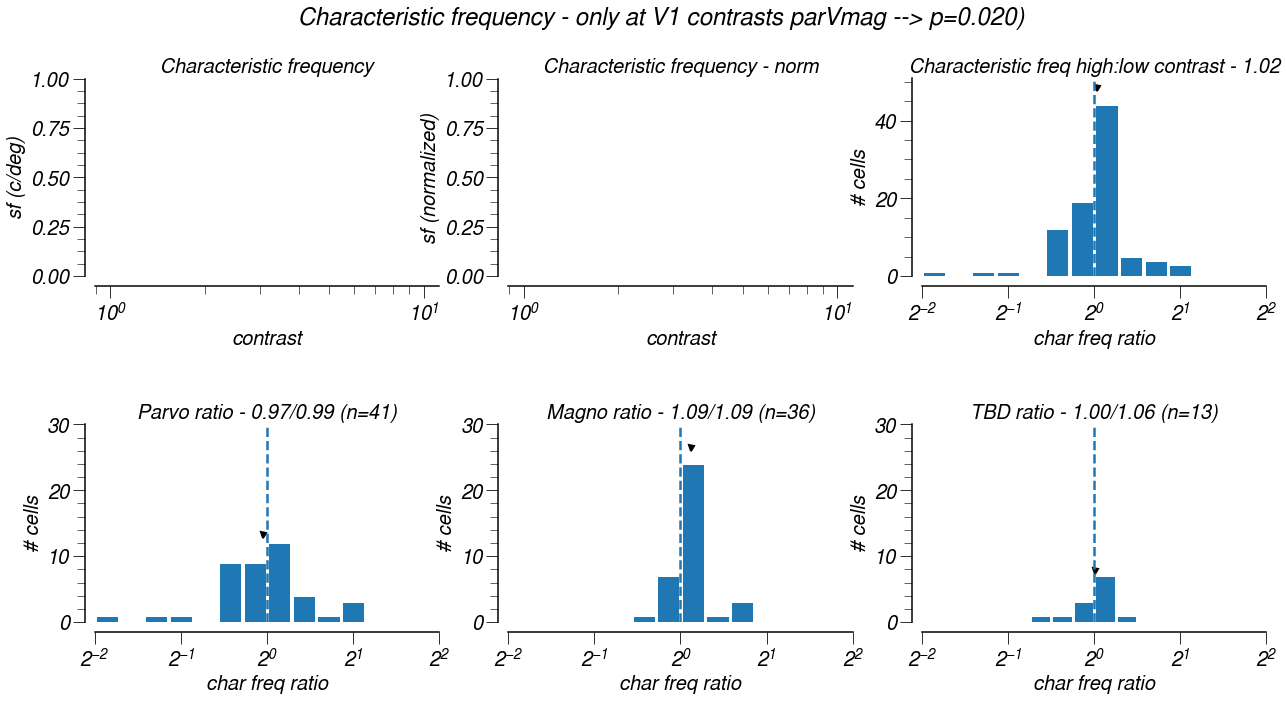

In [1678]:
### just V1 contrasts

# bad coding/lazy/hacky - fix later (manually set ylim for bottom row)
ylm = 30;

nrow = 2;
ncol = 3;
f, ax = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))

plot_cons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons

plt.subplot(nrow, ncol, 1)
# plt.plot(plot_cons, cfreq_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (c/deg)')
plt.title('Characteristic frequency');

plt.subplot(nrow, ncol, 2)
# plt.plot(plot_cons, cfreq_norm_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (normalized)')
plt.title('Characteristic frequency - norm');

plt.subplot(nrow, ncol, 3)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_all, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_all)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Characteristic freq high:low contrast - %.2f' % ratio_gmean)

plt.subplot(nrow, ncol, 4)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_p, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_p)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, ylm])
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Parvo ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, np.median(val_ratios_p), len(val_ratios_p)))
# get the ylimits here to pass on to the next plots - why here? since more parvo cells than anything, so highest

plt.subplot(nrow, ncol, 5)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_m, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_m)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, ylm])
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Magno ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, np.median(val_ratios_m), len(val_ratios_m)))

plt.subplot(nrow, ncol, 6)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 17)
counts, _, _ = plt.hist(val_ratios_tbd, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_tbd)
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, ylm])
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k', label='gm=%.2f' % ratio_gmean);
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('TBD ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, np.median(val_ratios_tbd), len(val_ratios_tbd)))

mVp_ksTest = ks2samp(val_ratios_m, val_ratios_p)

f.suptitle('Characteristic frequency - only at V1 contrasts parVmag --> p=%.3f)' % (mVp_ksTest.pvalue))
f.subplots_adjust(wspace=0.2, hspace=0.75);

sns.despine(offset=10)

saveName = "/charFreq_v1cons%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


Now the same, but only at (100%, X%) (e.g. 15%)

In [1679]:
print('me:' + str(all_cVals[myInds[0][0]]));
print('sach:' + str(all_cVals[sachInds[0][0]]));

me:[0.05  0.073 0.106 0.154 0.224 0.325 0.473 0.688 1.   ]
sach:[0.01      0.0158489 0.0251189 0.0398107 0.0630957 0.1       0.158489
 0.251189  0.398107  0.630957  1.       ]


In [1701]:
lowCon = 0.65
lowInd = [np.argmin(np.square(x-lowCon)) for x in all_cVals]

highCon = 1
highInd = [np.argmin(np.square(x-highCon)) for x in all_cVals]

In [1702]:
# Center frequency v. contrast

# cfreq_geo = np.nan * np.zeros((max_nCons, ))
# cfreq_norm_geo = np.nan * np.zeros((max_nCons, ))
# for i in range(max_nCons):
#     non_nans = np.where(~np.isnan(all_rc[:, i]))[0]
#     if len(non_nans) > 0:
#         cfreq_geo[i] = geomean(np.divide(1, np.pi*all_rc[non_nans, i]))
#         cfreq_norm_geo[i] = geomean(np.divide(1, all_rc_norm[non_nans, i]))
    
        
# ratio of peak SF at high:low contrast
cfreq_ratios = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
for i in range(n_cells):
    non_nans = np.where(~np.isnan(all_rc[i, :]))[0];
    if ~np.any(non_nans == lowInd[i]) or ~np.any(non_nans == highInd[i]):
        continue;

    cfreq_ratios[i, 0] = all_cfr[i, highInd[i]] / all_cfr[i, lowInd[i]];
    if allTypes[i] == 'parvo':
        cfreq_ratios[i, 1] = cfreq_ratios[i, 0];
    if allTypes[i] == 'magno':
        cfreq_ratios[i, 2] = cfreq_ratios[i, 0];
    if allTypes[i] == 'tbd':
        cfreq_ratios[i, 3] = cfreq_ratios[i, 0];

val_ratios_all = cfreq_ratios[~np.isnan(cfreq_ratios[:, 0]), 0]
val_ratios_p = cfreq_ratios[~np.isnan(cfreq_ratios[:, 1]), 1]
val_ratios_m = cfreq_ratios[~np.isnan(cfreq_ratios[:, 2]), 2]
val_ratios_tbd = cfreq_ratios[~np.isnan(cfreq_ratios[:, 3]), 3]

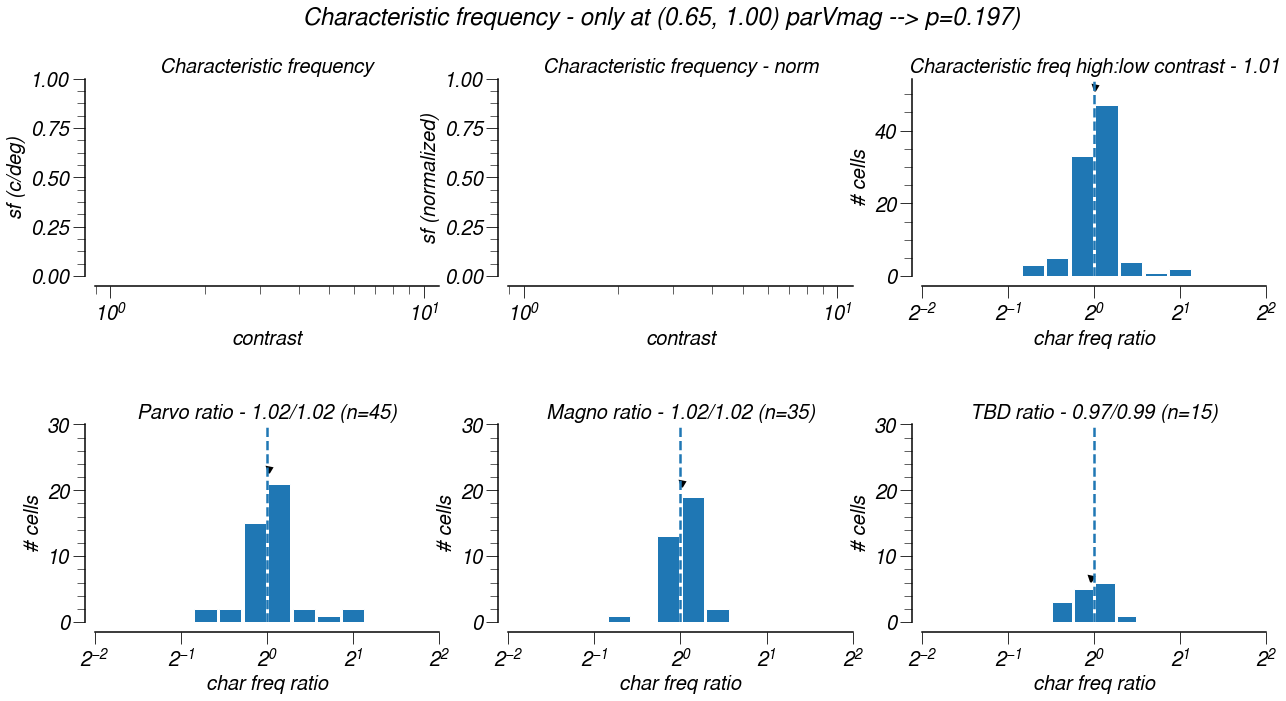

In [1703]:
# bad/hacky - fix
ylm = 30;

nrow = 2;
ncol = 3;
f, ax = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))

plot_cons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons

plt.subplot(nrow, ncol, 1)
# plt.plot(plot_cons, cfreq_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (c/deg)')
plt.title('Characteristic frequency');

plt.subplot(nrow, ncol, 2)
# plt.plot(plot_cons, cfreq_norm_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (normalized)')
plt.title('Characteristic frequency - norm');

plt.subplot(nrow, ncol, 3)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_all, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_all)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Characteristic freq high:low contrast - %.2f' % ratio_gmean)

plt.subplot(nrow, ncol, 4)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_p, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_p)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, ylm])
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Parvo ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, np.median(val_ratios_p), len(val_ratios_p)))
# get the ylimits here to pass on to the next plots - why here? since more parvo cells than anything, so highest

plt.subplot(nrow, ncol, 5)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_m, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_m)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, ylm])
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Magno ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, np.median(val_ratios_m), len(val_ratios_m)))

plt.subplot(nrow, ncol, 6)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 17)
counts, _, _ = plt.hist(val_ratios_tbd, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_tbd)
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, ylm])
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k', label='gm=%.2f' % ratio_gmean);
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('TBD ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, np.median(val_ratios_tbd), len(val_ratios_tbd)))

mVp_ksTest = ks2samp(val_ratios_m, val_ratios_p)

f.suptitle('Characteristic frequency - only at (%.02f, %.02f) parVmag --> p=%.3f)' % (lowCon, highCon, mVp_ksTest.pvalue))
f.subplots_adjust(wspace=0.2, hspace=0.75);

sns.despine(offset=10)

saveName = "/charFreq_consStep1%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


### Plot pSf, charFreq against conGain, phAdv

ValueError: Number of samples, -2147483552, must be non-negative.

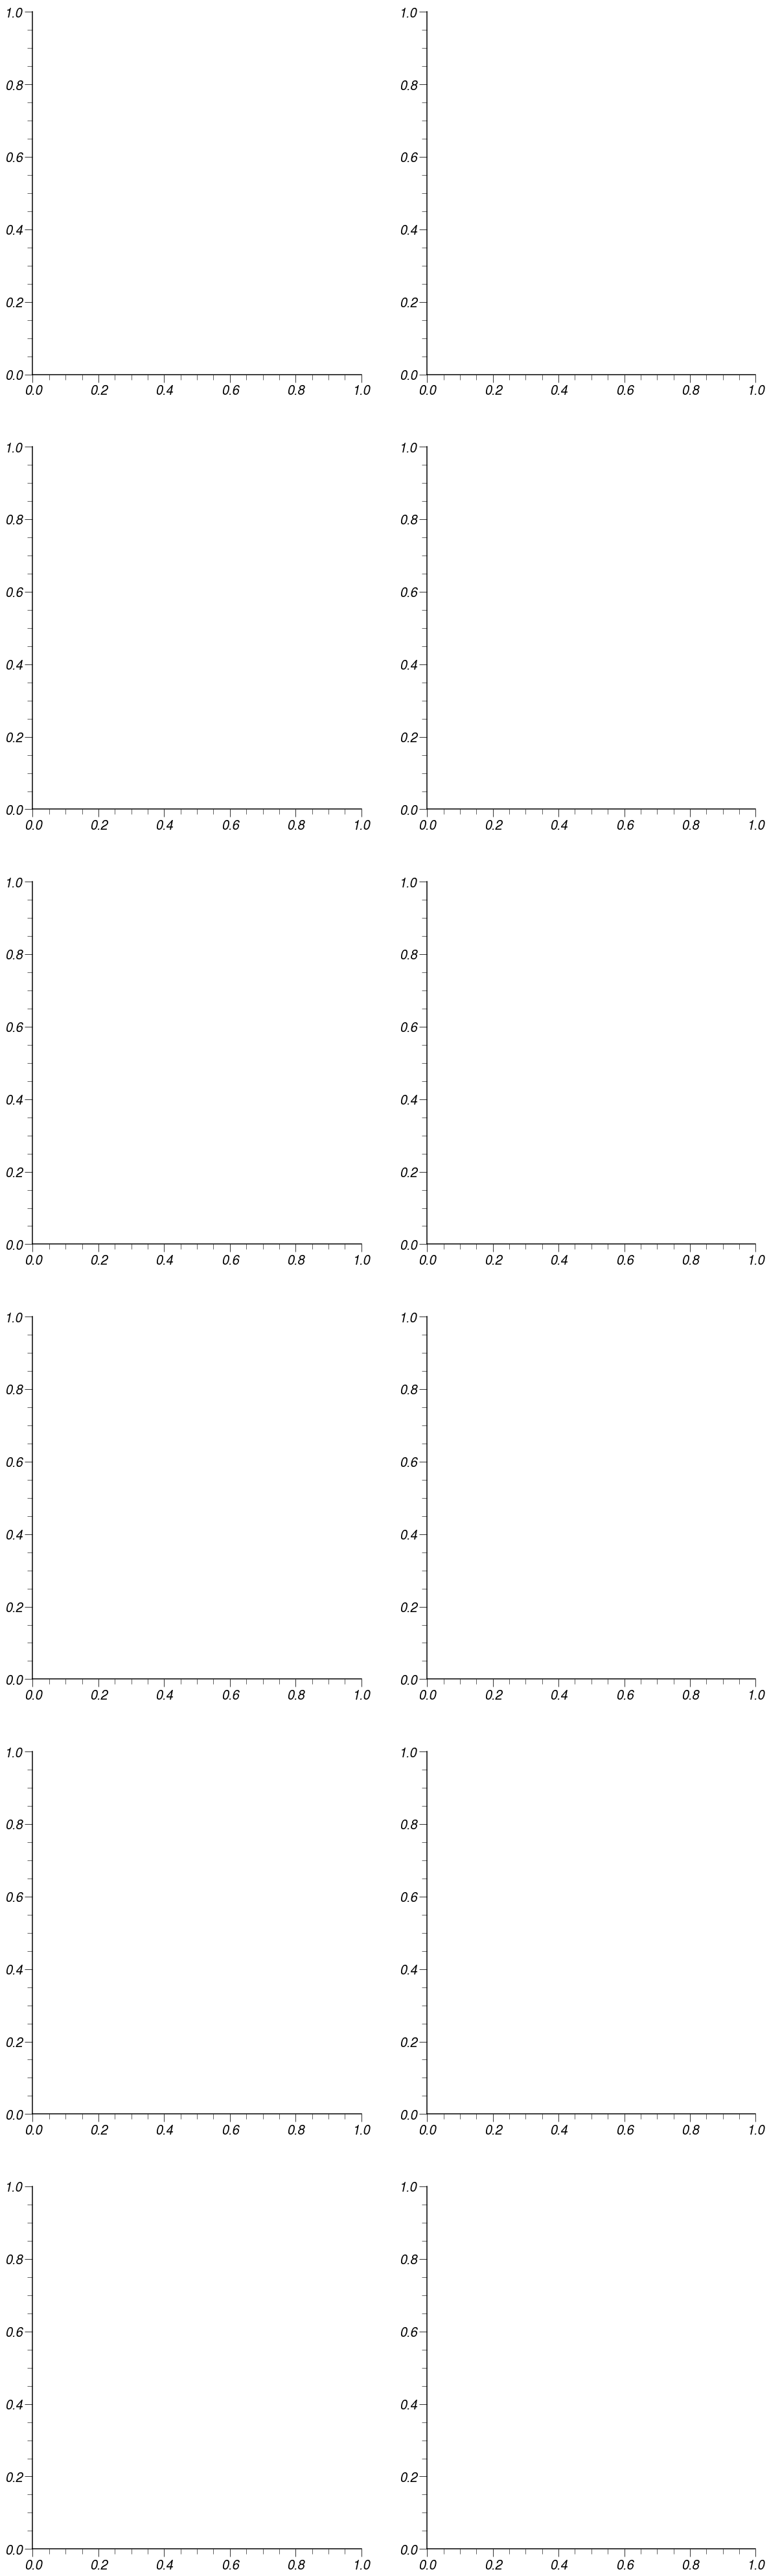

In [756]:
# nrow = 6;
# ncol = 2;
# f, ax = plt.subplots(nrow, ncol, figsize=(ncol*10, nrow*12))

# ### pSf versus phase advance

# # point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
# plt.subplot(nrow, ncol, 1)
# grays = cm.gray(np.linspace(0, 1, varRange+1))
# plt.scatter(psf_ratios[:, 0], bestPhAdv, color=grays[varRange - (varAsInd - np.min(varAsInd))])
# plt.xscale('log')
# plt.xlabel('psf ratio');
# plt.yscale('symlog')
# plt.ylabel('phase advance (ms)');
# plt.title('SF shift versus highest phase advance');

# # point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
# plt.subplot(nrow, ncol, 2)
# grays = cm.gray(np.linspace(0, 1, varRange+1))
# plt.scatter(psf_ratios[:, 0], meanPhAdv, color=grays[varRange - (varAsInd - np.min(varAsInd))])
# plt.xscale('log')
# plt.xlabel('psf ratio');
# plt.yscale('symlog')
# plt.ylabel('phase advance (ms)');
# plt.title('SF shift versus mean phase advance');

# ### pSf versus contrast gain

# # point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
# plt.subplot(nrow, ncol, 3)
# grays = cm.gray(np.linspace(0, 1, varRange+1))
# plt.scatter(psf_ratios[:, 0], bestConGain, color=grays[varRange - (varAsInd - np.min(varAsInd))])
# plt.xscale('log')
# plt.xlabel('psf ratio');
# plt.yscale('log')
# plt.ylabel('contrast gain');
# plt.title('SF shift versus highest conGain');

# # point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
# plt.subplot(nrow, ncol, 4)
# grays = cm.gray(np.linspace(0, 1, varRange+1))
# plt.scatter(psf_ratios[:, 0], meanConGain, color=grays[varRange - (varAsInd - np.min(varAsInd))])
# plt.xscale('log')
# plt.xlabel('psf ratio');
# plt.yscale('log')
# plt.ylabel('contrast gain');
# plt.title('SF shift versus mean conGain');

# ### charFreq versus phase advance
# # point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
# plt.subplot(nrow, ncol, 5)
# grays = cm.gray(np.linspace(0, 1, varRange+1))
# plt.scatter(cfreq_ratios[:, 0], bestPhAdv, color=grays[varRange - (varAsInd - np.min(varAsInd))])
# plt.xscale('log')
# plt.xlabel('charFreq ratio');
# plt.yscale('symlog')
# plt.ylabel('phase advance (ms)');
# plt.title('charFreq shift versus highest phase advance');

# # point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
# plt.subplot(nrow, ncol, 6)
# grays = cm.gray(np.linspace(0, 1, varRange+1))
# plt.scatter(cfreq_ratios[:, 0], meanPhAdv, color=grays[varRange - (varAsInd - np.min(varAsInd))])
# plt.xscale('log')
# plt.xlabel('charFreq ratio');
# plt.yscale('symlog')
# plt.ylabel('phase advance (ms)');
# plt.title('charFreq shift versus mean phase advance');

# ### pSf versus center radius change (high:low contrast ratio)
# plt.subplot(nrow, ncol, 7)
# grays = cm.gray(np.linspace(0, 1, varRange+1))
# plt.scatter(psf_ratios[:, 0], all_rc_conRat, color=grays[varRange - (varAsInd - np.min(varAsInd))])
# plt.xscale('log')
# plt.xlabel('psf ratio');
# plt.yscale('log')
# plt.ylabel('radius ratio');
# plt.title('SF shift versus center radius contrast change');

# ### pSf versus surround radius change
# # point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
# plt.subplot(nrow, ncol, 8)
# grays = cm.gray(np.linspace(0, 1, varRange+1))
# plt.scatter(psf_ratios[:, 0], all_rs_conRat, color=grays[varRange - (varAsInd - np.min(varAsInd))])
# plt.xscale('log')
# plt.xlabel('psf ratio');
# plt.yscale('symlog')
# plt.ylabel('radius ratio');
# plt.title('SF shift versus surround radius contrast change');

# ### pSf versus center volume change
# plt.subplot(nrow, ncol, 9)
# grays = cm.gray(np.linspace(0, 1, varRange+1))
# plt.scatter(psf_ratios[:, 0], all_volc_conRat, color=grays[varRange - (varAsInd - np.min(varAsInd))])
# plt.xscale('log')
# plt.xlabel('psf ratio');
# plt.yscale('log')
# plt.ylabel('volume ratio');
# plt.title('SF shift versus center volume contrast change');

# ### pSf versus surround volume change
# # point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
# plt.subplot(nrow, ncol, 10)
# grays = cm.gray(np.linspace(0, 1, varRange+1))
# plt.scatter(psf_ratios[:, 0], all_vols_conRat, color=grays[varRange - (varAsInd - np.min(varAsInd))])
# plt.xscale('log')
# plt.xlabel('psf ratio');
# plt.ylim([1e-1, 1e2])
# plt.yscale('log')
# plt.ylabel('volume ratio');
# plt.title('SF shift versus surround volume contrast change');

# sns.despine(offset=10)

# saveName = "/peakSF_v_DoG%s%s.pdf" % (mod_suff, loss_suff)
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

### Plot high-frequency cut-off

Characteristic frequency ($1/2\pi r_c$), which we fit, is a measure of the high-frequency cut-off of the SF tuning curve. For cells that are low-pass (rather than bandpass) this is a more reliable measure.

But, due to poor difference-of-gaussian fitting and/or the misleading characteristic frequencies that result from effectively flat tuning (which can occur at low contrasts/response amplitudes), we can just compute the frequency at which the response falls to X% of the peak response - this can be a proxy (and perhaps more reliable measure) for the changes in high-frequency

**update** must update to include different response drop-off measure

# Important: Characteristic Frequency analysis as in analyses_Sach.ipynb

To more easily compare my data to Sach's, I'm using the same analysis protocol used in .../LGN/sach/analyses_Sach.ipynb

In [ ]:
# f, ax = plt.subplots(1, 2, figsize=(20, 8))

# plt.subplot(1, 2, 1)
# plt.hist(all_flatVE[~np.isnan(all_flatVE)], bins=np.linspace(-10, 100, 12))
# plt.xlabel('% variance explained');
# plt.ylabel('# conditions');
# plt.title('Quality of DoG fits');

# ## TODO: here and throughout, how to bin/plot with different sets of contrasts...

# # plt.subplot(1, 2, 2);
# # vE_byCon_median = np.zeros((n_singleCons, ));
# # vE_byCon_mean = np.zeros((n_singleCons, ));
# # for i in range(n_singleCons): # same number of cons for all cells
# #     ii = val_cells[i] # as above
# #     con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
# #     curr_vE = [x[con_inds[i]] for x in all_varExpl];
# #     vE_byCon_median[i] = np.nanmedian(curr_vE);
# #     vE_byCon_mean[i] = np.nanmean(curr_vE);
# # plt.plot(singleCons, vE_byCon_median, label='median')
# # plt.plot(singleCons, vE_byCon_mean, label='mean')
# # plt.xlabel('contrast');
# # plt.ylabel('variance explained');
# # plt.title('Name: %s' % fLnameBase);
# # plt.legend();

# sns.despine(offset=10)

# saveName = "/varExpl%s%s.pdf" % (mod_suff, loss_suff);
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

In [ ]:
# to_thresh = 1;
# thresh_varExpl = 70
# # thresh_varExpl is set above

# if to_thresh == 1:
#     valid_inds = np.where(all_flatVE > thresh_varExpl)[0]
# else: # or to take all
#     valid_inds = np.arange(len(flat_params))
#     thresh_varExpl = -np.inf
    
# non_nanVar = np.sum(~np.isnan(flat_varExpl)) # some conditions are nan
# print('%.1f%% of conditions pass the threshold criteria' % (100*len(valid_inds)/non_nanVar))

In [ ]:
# import seaborn as sns
# from matplotlib.ticker import FormatStrFormatter

# sns.set_style('ticks');

In [1835]:
autoreload.reload(hf);
autoreload.reload(sach_hf);

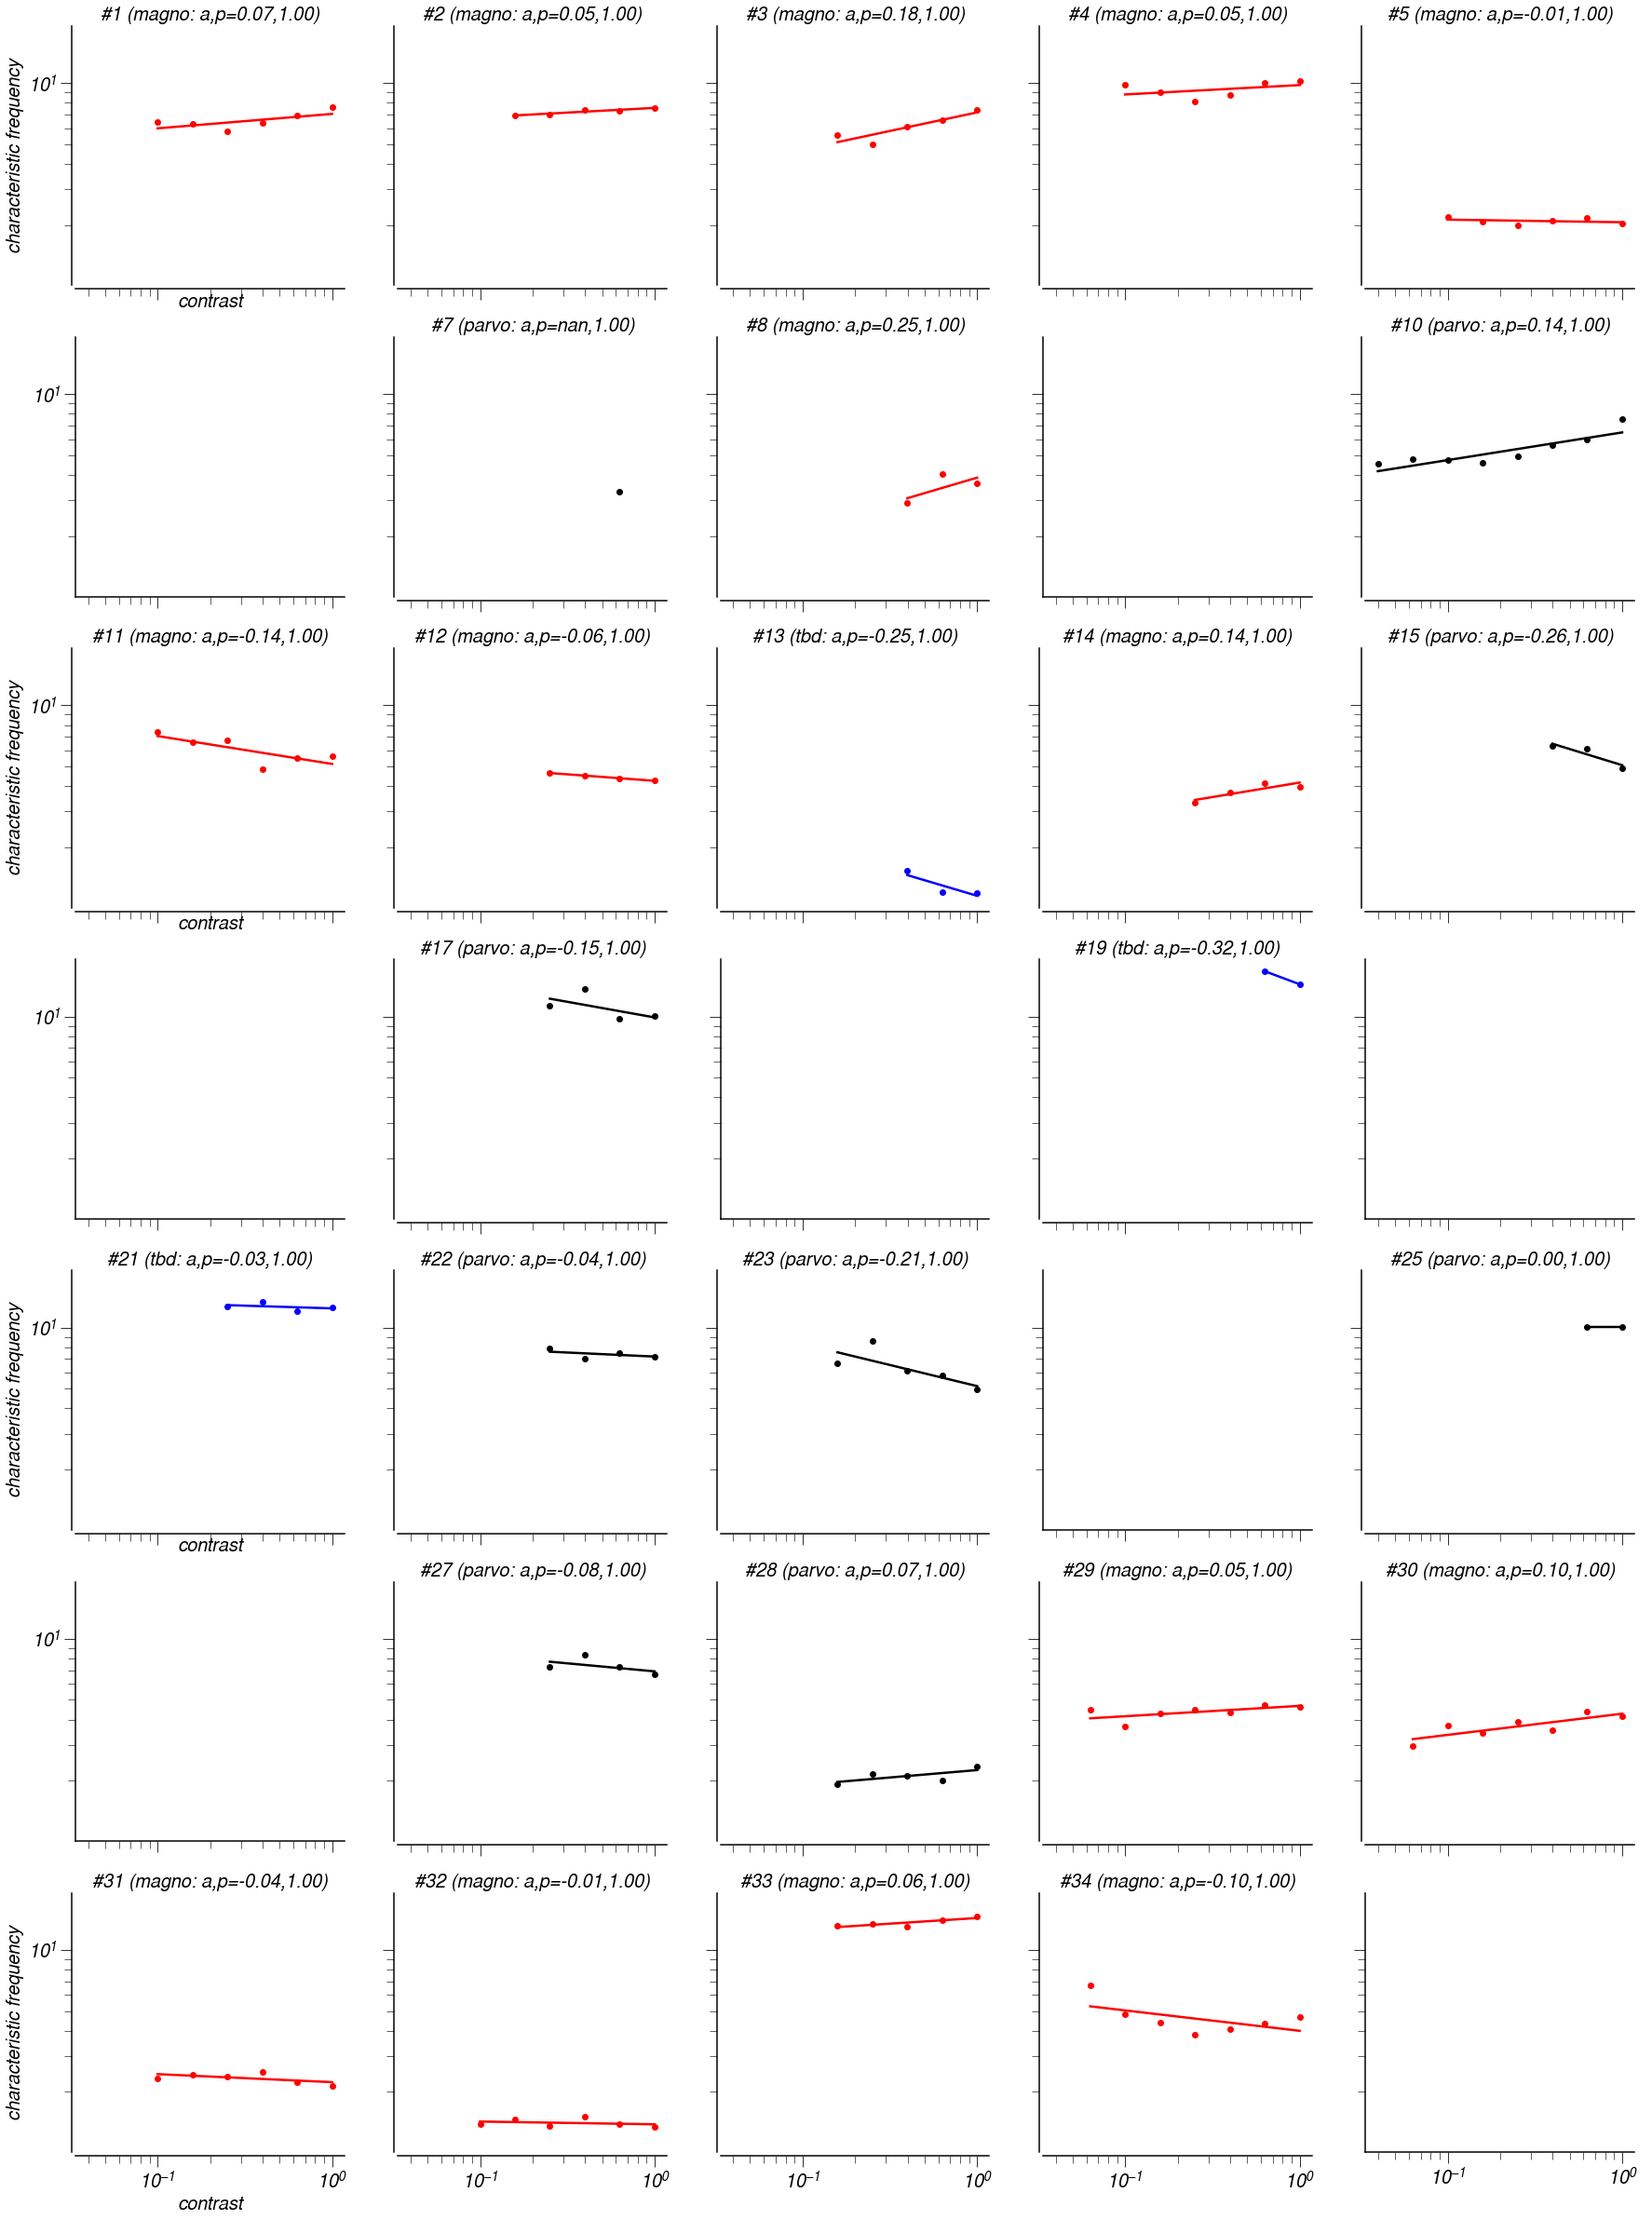

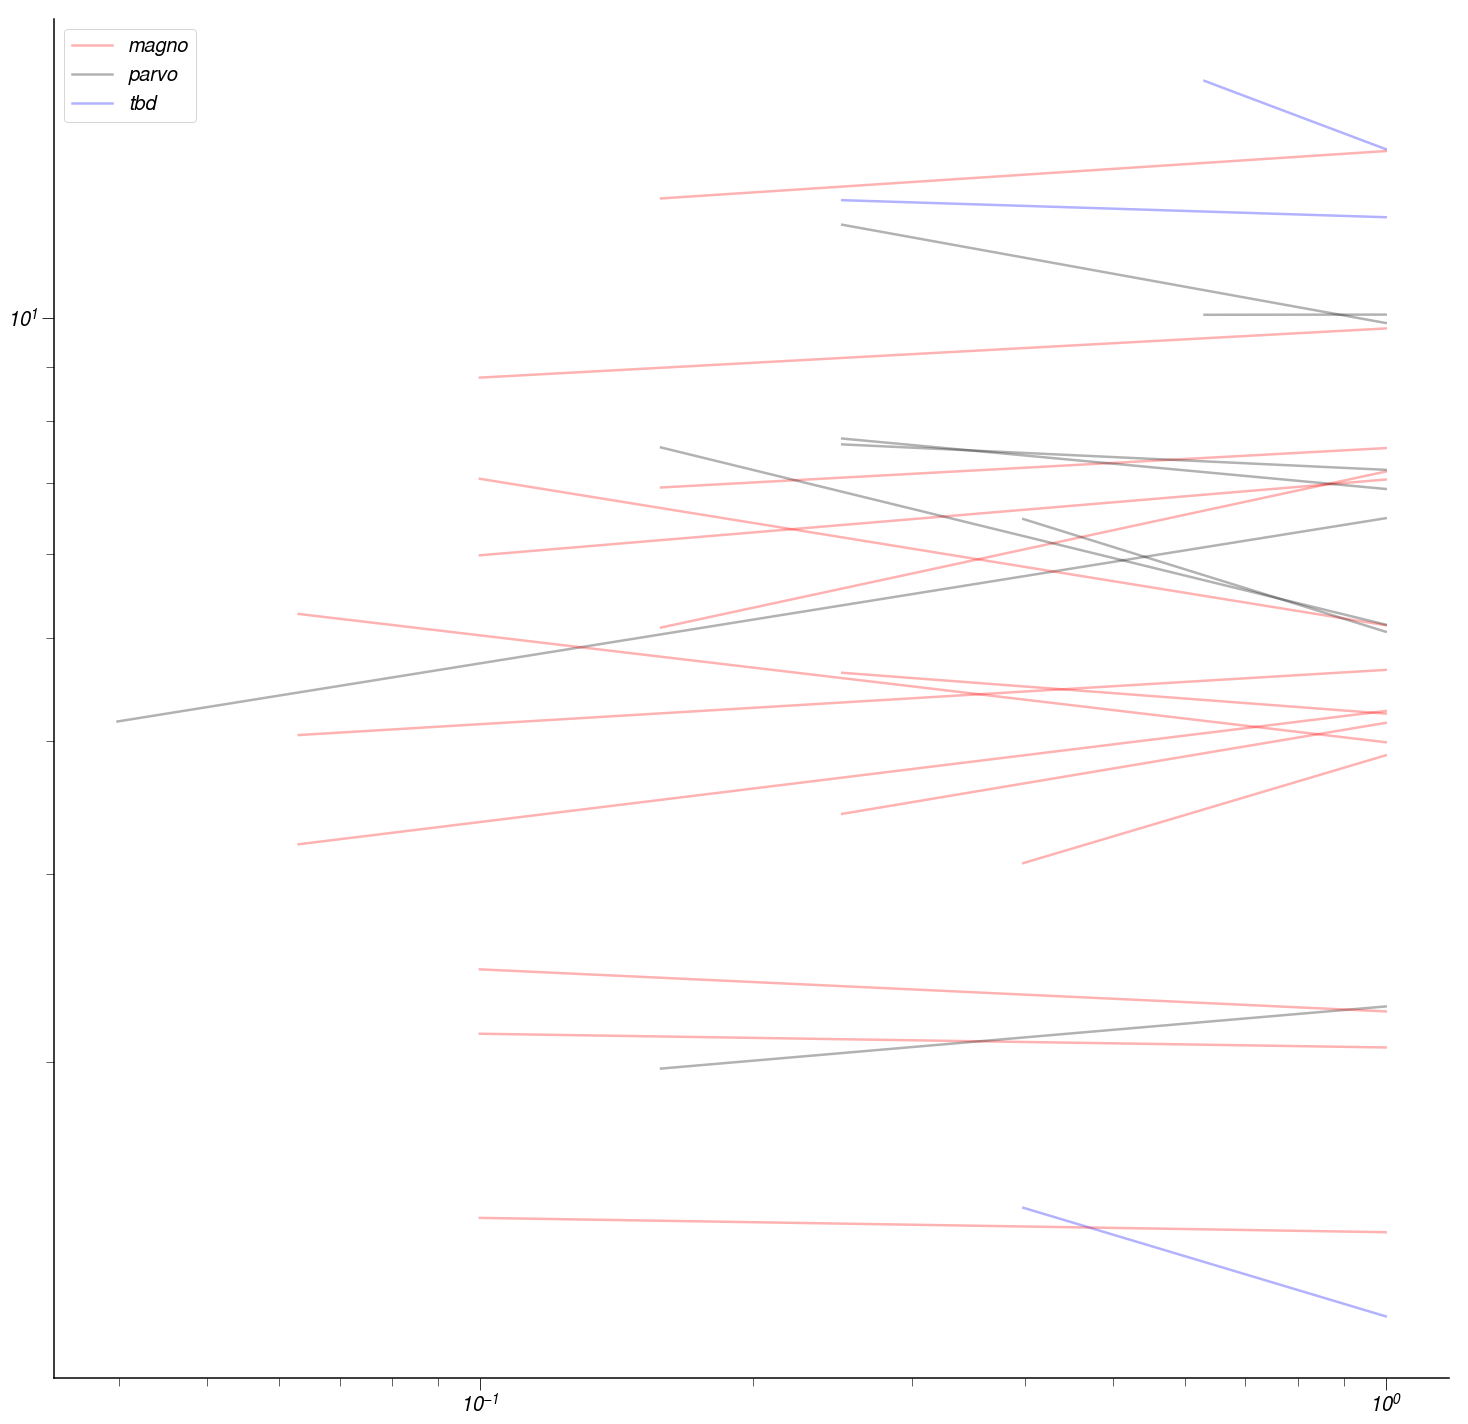

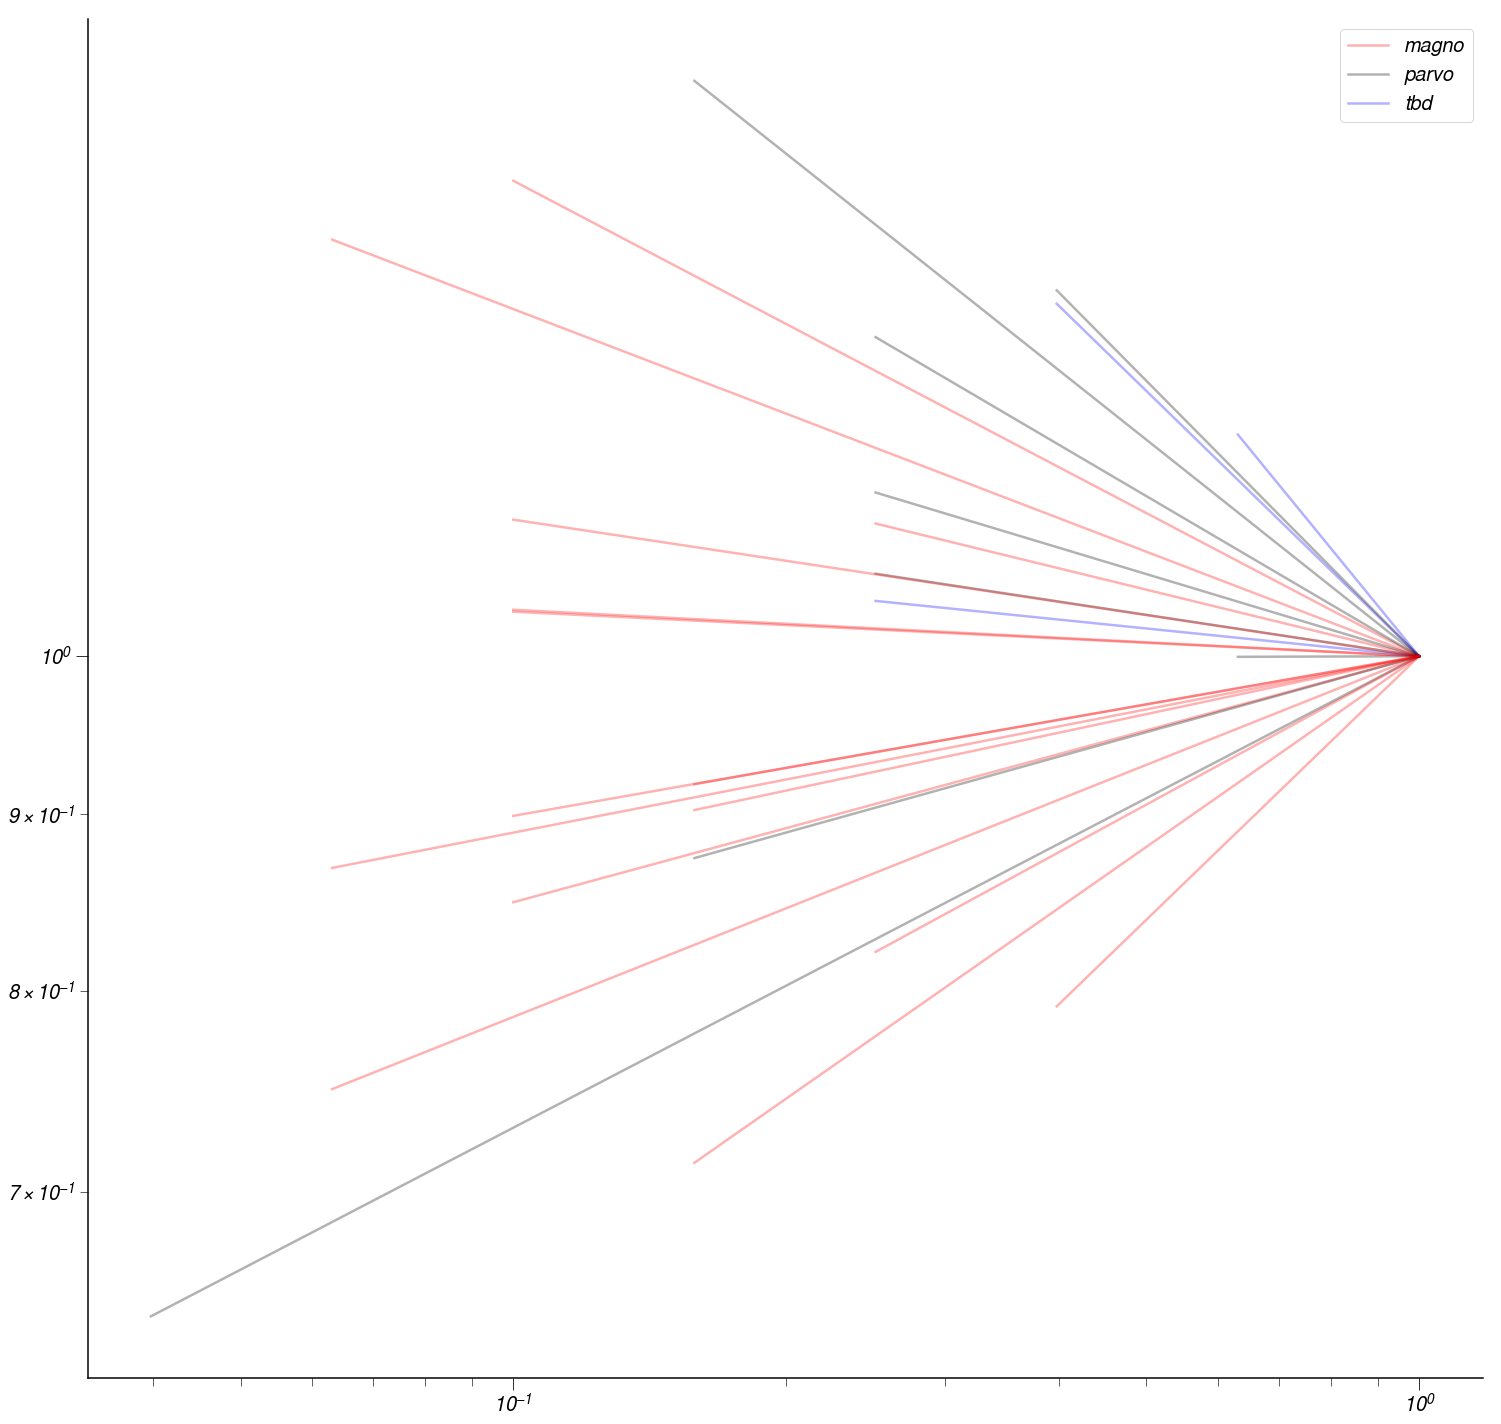

In [1836]:
plt_bycell = 1;
cons_to_use = (np.asarray(0.33), np.asarray(1.0)) # V1 contrasts
fixPow = True; # fix the power/exponent in the cfreq_model?

n_rows = int(np.ceil(n_cells/np.floor(np.sqrt(n_cells)))); # make this close to a rectangle/square in arrangement (cycling through sfs)                                                                 
n_cols = int(np.ceil(n_cells/n_rows));

cfreq_rats = np.nan * np.zeros((n_cells, 4));
cfreq_slopes = np.nan * np.zeros((n_cells, 4));

if plt_bycell:
    f, ax = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows), sharex=True, sharey=True)
    ff, aaxx = plt.subplots(1, 1, figsize=(25, 25));
    ff_norm, aaxx_norm = plt.subplots(1, 1, figsize=(25, 25));
    
for i in range(len(all_keys)):
    ii = all_keys[i];
    expCurr = expNum[i];
    curr_cons = all_cVals[i];
    if expCurr == 0: # my data
        _, mod, modParams, real_fc, real_fc_cons = hf.dog_charFreqMod(descrFits[ii], curr_cons, all_cInds[ii], varThresh=thresh_varExpl, DoGmodel=DoGmodel, lowConCut=0, fixPower=fixPow)
    elif expCurr == 1: # sach data
        _, mod, modParams, real_fc, real_fc_cons = sach_hf.dog_charFreqMod(sachFits[ii], curr_cons, varThresh=thresh_varExpl, DoGmodel=DoGmodel, lowConCut=0, fixPower=fixPow)

    if mod is None:
        continue;
    
    if plt_bycell:
        plt_row, plt_col = int(i/n_cols), np.mod(i, n_cols);
        ax[plt_row, plt_col].plot(real_fc_cons, real_fc, 'o', color=clrs_type[i]);
        plt_cons = np.geomspace(real_fc_cons[0], real_fc_cons[-1], 50);
        mod_plt = np.power(2, mod(*modParams, con=plt_cons)); # because we did log2...
        ax[plt_row, plt_col].plot(plt_cons, mod_plt, color=clrs_type[i]);
        ax[plt_row, plt_col].set_yscale('log');
        ax[plt_row, plt_col].set_xscale('log')
        if plt_col == 0:
            ax[plt_row, plt_col].set_ylabel('characteristic frequency');
            ax[plt_row, plt_col].set_xlabel('contrast')
        ax[plt_row, plt_col].set_title('#%d (%s: a,p=%.2f,%.2f)' % (ii+1, allTypes[i], modParams[1], modParams[2]))
        sns.despine(ax=ax[plt_row, plt_col], offset=4)
        
        # then plot for the common axis
        aaxx.loglog(plt_cons, mod_plt, alpha=0.3, color=clrs_type[i], label=lbls_type[i]);
        aaxx.legend();
        # and again, for a normalized axis
        aaxx_norm.loglog(plt_cons, np.divide(mod_plt, mod_plt[-1]), alpha=0.3, color=clrs_type[i], label=lbls_type[i]); 
        aaxx_norm.legend();
        
    extrema = np.power(2, mod(*modParams, con=cons_to_use)) # evaluating the model fit at "cons_to_use"
    rat = np.log2(extrema[-1] / extrema[0]);
    # now, make sure we only add the ratio if we have more than 
    if sum(real_fc_cons > 0.2) > 2:
        cfreq_rats[i, 0] = rat;
        cfreq_slopes[i, 0] = modParams[1];
        if allTypes[i] == 'parvo':
            cfreq_rats[i, 1] = rat;
            cfreq_slopes[i, 1] = modParams[1];
        elif allTypes[i] == 'magno':
            cfreq_rats[i, 2] = rat;
            cfreq_slopes[i, 2] = modParams[1];
        elif allTypes[i] == 'tbd':
            cfreq_rats[i, 3] = rat;
            cfreq_slopes[i, 3] = modParams[1];
        
if plt_bycell:
    saveName = "/charFreq_mod%s%s.pdf" % (mod_suff, loss_suff)
    full_save = os.path.dirname(save_loc);
    if not os.path.exists(full_save):
        os.makedirs(full_save)
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()
    
    saveName = "/charFreq_mod_allCells%s%s.pdf" % (mod_suff, loss_suff)
    full_save = os.path.dirname(save_loc);
    if not os.path.exists(full_save):
        os.makedirs(full_save)
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(ff) # only one figure here...
    pdfSv.close()
    
    saveName = "/charFreq_mod_allCellsNorm%s%s.pdf" % (mod_suff, loss_suff)
    full_save = os.path.dirname(save_loc);
    if not os.path.exists(full_save):
        os.makedirs(full_save)
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(ff_norm) # only one figure here...
    pdfSv.close()

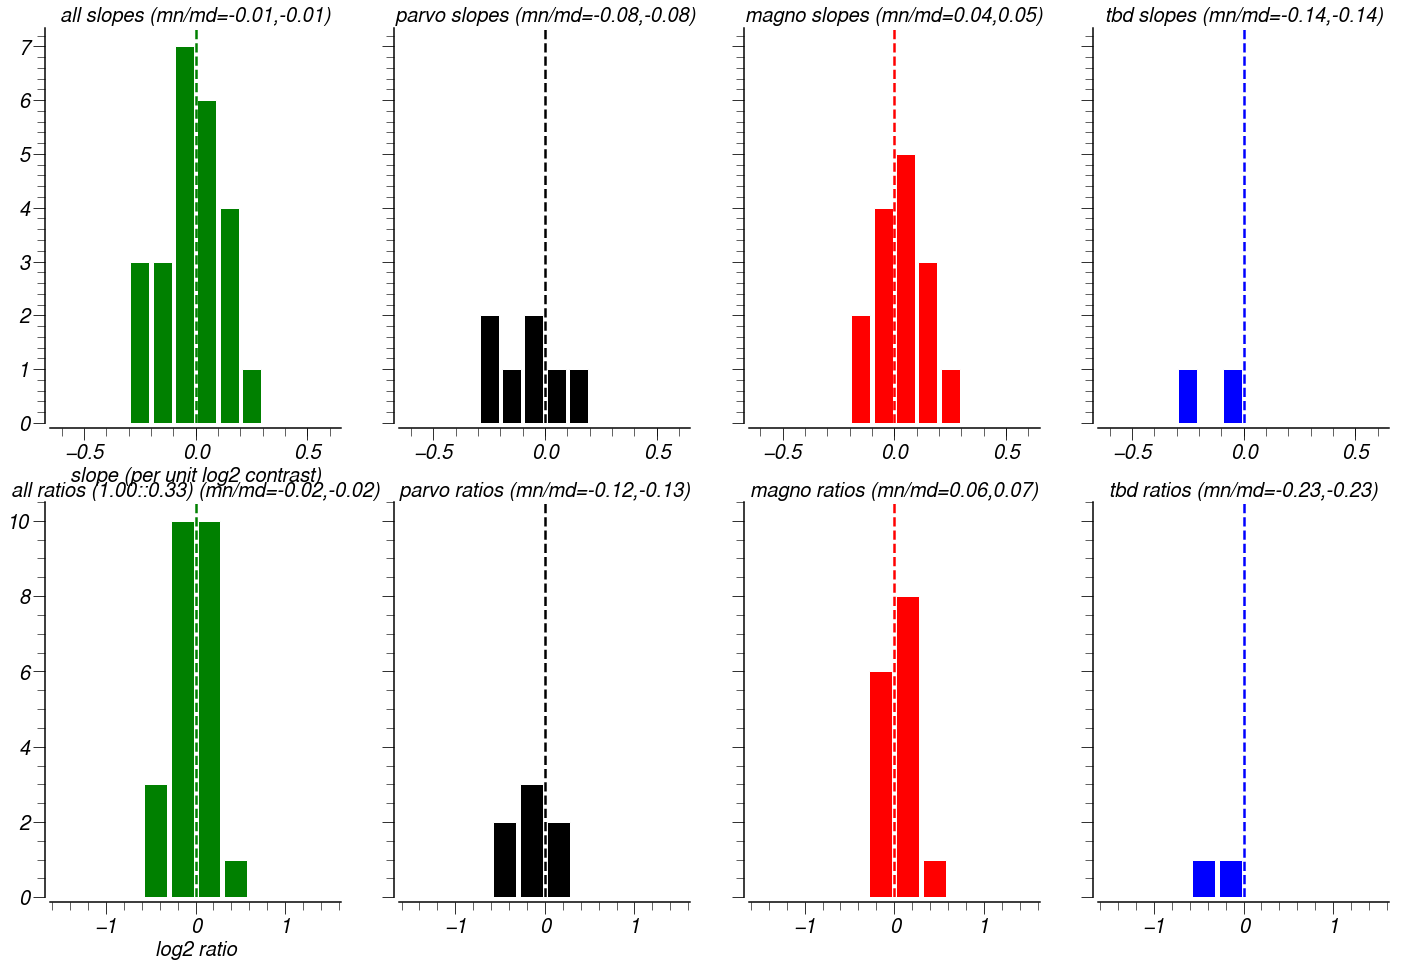

In [1837]:
### now, plot the slopes...and the ratio of cfreq evaluated at 100%:33% contrast

rwd = 0.85 # width of bins (1 is occupy the whole bin...)
# now, plot the slopes...
nrow, ncol = 2, 4;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*6, nrow*8), sharex='row', sharey='row');

### first the slopes
bins = np.linspace(-0.6, 0.6, 13)

non_nan = np.where(~np.isnan(cfreq_slopes[:, 0]))[0];
vals = cfreq_slopes[non_nan, 0];
mn, md = np.mean(vals), np.median(vals);
ax[0, 0].hist(cfreq_slopes[non_nan, 0], bins, color='g', rwidth=rwd);
ax[0, 0].axvline(0.0, color='g', linestyle='--')
ax[0, 0].set_title('all slopes (mn/md=%.2f,%.2f)' % (mn, md))
ax[0, 0].set_xlabel('slope (per unit log2 contrast)')

non_nan = np.where(~np.isnan(cfreq_slopes[:, 1]))[0];
vals = cfreq_slopes[non_nan, 1];
mn, md = np.mean(vals), np.median(vals);
ax[0, 1].hist(cfreq_slopes[non_nan, 1], bins, color='k', rwidth=rwd);
ax[0, 1].axvline(0.0, color='k', linestyle='--')
ax[0, 1].set_title('parvo slopes (mn/md=%.2f,%.2f)' % (mn, md))

non_nan = np.where(~np.isnan(cfreq_slopes[:, 2]))[0];
vals = cfreq_slopes[non_nan, 2];
mn, md = np.mean(vals), np.median(vals);
ax[0, 2].hist(cfreq_slopes[non_nan, 2], bins, color='r', rwidth=rwd);
ax[0, 2].axvline(0.0, color='r', linestyle='--')
ax[0, 2].set_title('magno slopes (mn/md=%.2f,%.2f)' % (mn, md))

non_nan = np.where(~np.isnan(cfreq_slopes[:, 3]))[0];
vals = cfreq_slopes[non_nan, 3];
mn, md = np.mean(vals), np.median(vals);
ax[0, 3].hist(cfreq_slopes[non_nan, 3], bins, color='b', rwidth=rwd);
ax[0, 3].axvline(0.0, color='b', linestyle='--')
ax[0, 3].set_title('tbd slopes (mn/md=%.2f,%.2f)' % (mn, md));

### then the ratios
bins = np.linspace(-1.5, 1.5, 11)

non_nan = np.where(~np.isnan(cfreq_rats[:, 0]))[0];
vals = cfreq_rats[non_nan, 0];
mn, md = np.mean(vals), np.median(vals);
ax[1, 0].hist(cfreq_rats[non_nan, 0], bins, color='g', rwidth=rwd);
ax[1, 0].axvline(0.0, color='g', linestyle='--')
ax[1, 0].set_xlabel('log2 ratio')
ax[1, 0].set_title('all ratios (%.2f::%.2f) (mn/md=%.2f,%.2f)' % (cons_to_use[1], cons_to_use[0], mn, md))

non_nan = np.where(~np.isnan(cfreq_rats[:, 1]))[0];
vals = cfreq_rats[non_nan, 1];
mn, md = np.mean(vals), np.median(vals);
ax[1, 1].hist(cfreq_rats[non_nan, 1], bins, color='k', rwidth=rwd);
ax[1, 1].axvline(0.0, color='k', linestyle='--')
ax[1, 1].set_title('parvo ratios (mn/md=%.2f,%.2f)' % (mn, md))

non_nan = np.where(~np.isnan(cfreq_rats[:, 2]))[0];
vals = cfreq_rats[non_nan, 2];
mn, md = np.mean(vals), np.median(vals);
ax[1, 2].hist(cfreq_rats[non_nan, 2], bins, color='r', rwidth=rwd);
ax[1, 2].axvline(0.0, color='r', linestyle='--')
ax[1, 2].set_title('magno ratios (mn/md=%.2f,%.2f)' % (mn, md))

non_nan = np.where(~np.isnan(cfreq_rats[:, 3]))[0];
vals = cfreq_rats[non_nan, 3];
mn, md = np.mean(vals), np.median(vals);
ax[1, 3].hist(cfreq_rats[non_nan, 3], bins, color='b', rwidth=rwd);
ax[1, 3].axvline(0.0, color='b', linestyle='--')
ax[1, 3].set_title('tbd ratios (mn/md=%.2f,%.2f)' % (mn, md));

### now save

sns.despine(offset=5)

saveName = "/charFreq_mod_slopeHist%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

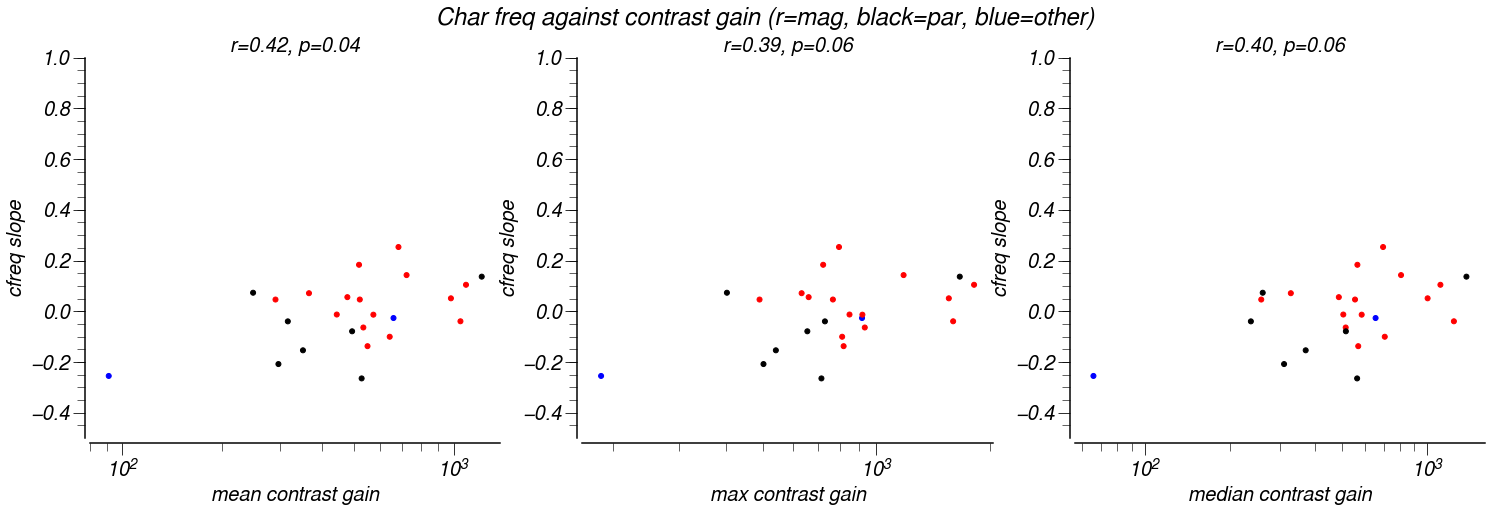

In [1838]:
maxGain = np.array([np.max(x) for x in all_conGains]);
medianGain = np.array([np.median(x) for x in all_conGains]);
meanGain = np.array([np.mean(x) for x in all_conGains]);
consider = np.arange(0, len(all_keys));

f, ax = plt.subplots(1, 3, figsize=(25, 7));

metric = ['mean', 'max', 'median']
rvals = np.nan * np.zeros((3,))
pvals = np.nan * np.zeros((3,))

non_nan = np.where(~np.isnan(cfreq_slopes[consider, 0]));
ax[0].scatter(meanGain[consider], cfreq_slopes[consider, 0], c=clrs_type[consider]);
rvals[0], pvals[0] = pearsonr(meanGain[consider[non_nan]], cfreq_slopes[consider[non_nan], 0])
ax[1].scatter(maxGain[consider], cfreq_slopes[consider, 0], c=clrs_type[consider]);
rvals[1], pvals[1] = pearsonr(maxGain[consider[non_nan]], cfreq_slopes[consider[non_nan], 0])
ax[2].scatter(medianGain[consider], cfreq_slopes[consider, 0], c=clrs_type[consider]);
rvals[2], pvals[2] = pearsonr(medianGain[consider[non_nan]], cfreq_slopes[consider[non_nan], 0])

for i in range(3):
    ax[i].set_xlabel('%s contrast gain' % metric[i])
    ax[i].set_ylabel('cfreq slope')
    ax[i].set_ylim([-0.5, 1])
    ax[i].set_xscale('log')
    ax[i].set_title('r=%.2f, p=%.2f' % (rvals[i], pvals[i]))
sns.despine(offset=5)

f.suptitle('Char freq against contrast gain (r=mag, black=par, blue=other)');

saveName = "/charFreq_vConGain%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

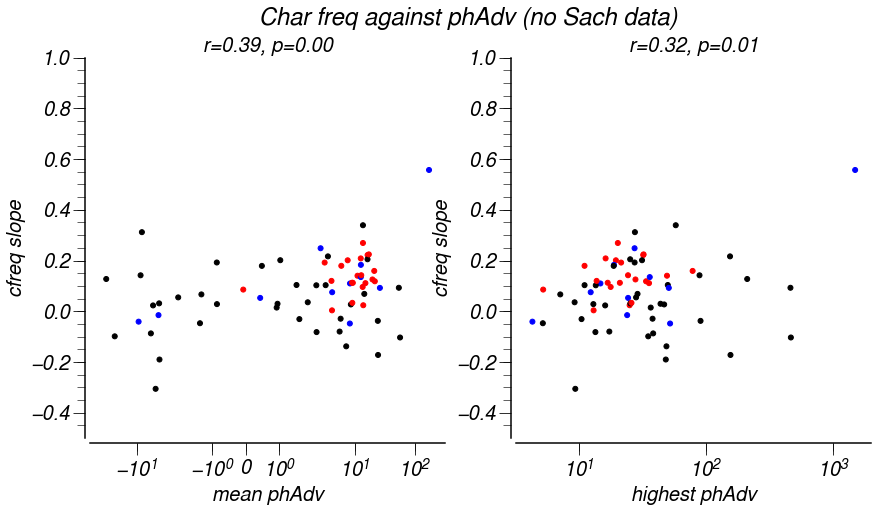

In [1786]:
meanPhAdv = np.array([np.nanmean(phFits[x]['phAdv']) for x in val_cellsMine])
bestPhAdv = np.array([np.nanmax(phFits[x]['phAdv']) for x in val_cellsMine])

consider = np.arange(0, 77);
f, ax = plt.subplots(1, 2, figsize=(14, 7));
ax[0].scatter(meanPhAdv[consider], cfreq_slopes[consider, 0], c=clrs_type[consider]);
ax[0].set_xlabel('mean phAdv')
ax[0].set_ylabel('cfreq slope')
ax[0].set_xscale('symlog')
ax[0].set_ylim([-0.5, 1])
non_nan = np.where(~np.isnan(cfreq_slopes[consider, 0]));
rval, pval = pearsonr(meanPhAdv[consider[non_nan]], cfreq_slopes[consider[non_nan], 0]);
ax[0].set_title('r=%.2f, p=%.2f' % (rval, pval))

ax[1].scatter(bestPhAdv[consider], cfreq_slopes[consider, 0], c=clrs_type[consider]);
ax[1].set_xlabel('highest phAdv')
ax[1].set_ylabel('cfreq slope')
ax[1].set_xscale('symlog')
ax[1].set_ylim([-0.5, 1])
non_nan = np.where(~np.isnan(cfreq_slopes[consider, 0]));
rval, pval = pearsonr(bestPhAdv[consider[non_nan]], cfreq_slopes[consider[non_nan], 0]);
ax[1].set_title('r=%.2f, p=%.2f' % (rval, pval))

sns.despine(offset=5)
# non_nan = np.where(~np.isnan(cfreq_slopes[consider, 0]));
# np.corrcoef(maxGain[consider[non_nan]], cfreq_slopes[consider[non_nan], 0])

f.suptitle('Char freq against phAdv (no Sach data)');

saveName = "/charFreq_vPhAdv%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


In [ ]:
# rcParams['xtick.major.size'] = 12
# rcParams['xtick.minor.size'] = 8
# rcParams['xtick.labelsize'] = 'large'

# rcParams['ytick.major.size'] = 12
# rcParams['ytick.minor.size'] = 8
# rcParams['ytick.labelsize'] = 'large'


In [ ]:
# f, ax = plt.subplots(1, 1, figsize=(12, 6))

# binRange = (-1.0, 1) # in log2 space...
# nBins = 15;
# bins = np.geomspace(np.power(2, binRange[0]), np.power(2, binRange[1]), nBins);

# wghts = np.ones_like(rats)/float(len(rats));
# counts, _, _ = plt.hist(rats, bins=bins, weights=wghts, rwidth=0.75, color='b');
# gmean = geomean(rats)
# plt.plot(gmean, 1.1*np.max(counts), 'v', color='b', markersize=12, label='$\mu = %.2f$\n$n = %d$' % (gmean, len(rats)));
# plt.axvline(1, ls='--', color='k');

# plt.legend(frameon=False, fontsize=15, handlelength=0);

# plt.xlim([bins[0], bins[-1]])
# plt.xscale('log', basex=2)

# plt.xlabel('Ratio of characteristic frequency', fontsize='large');
# plt.ylabel('Proportion of cells', fontsize='large');
# plt.suptitle('charfreq ratio: %.2f:%.2f %%con' % (cons_to_use[-1], cons_to_use[0]));
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# sns.despine(offset=15)
# f.subplots_adjust(bottom=0.2, left=0.3);

# saveName = "/charFreq_v1consInterpAlt%s%s.pdf" % (mod_suff, loss_suff)
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

#### Test: contrast gain versus SF

In [ ]:
# f, ax = plt.subplots(n_cells, 1, figsize=(10, 10*n_cells))
# ff, aaxx = plt.subplots(1, 1, figsize=(20, 20));
    
# for i in range(len(val_cells)):
#     ii = val_cells[i];
    
#     curr_sfs = allSfs[ii];
#     curr_gains = all_conGain[ii];

#     ax[i].set_title('cell %d' % (ii+1))

#     if np.isnan(curr_gains).all():
#         continue;
    
#     sns.despine(ax=ax[i], offset=4)
    
#     ax[i].plot(curr_sfs, curr_gains, '-o', label='con. gain');
#     ax[i].set_xscale('log');
#     ax[i].set_yscale('symlog', linthreshy=1);
#     ax[i].set_ylabel('contrast gain');
#     ax[i].set_xlabel('sf (c/deg)')

#     # now, on the plot for each cell separately, let's plot a re-scaled version of the SF tuning
#     sfref_curr = allSfRef[ii];
#     mn, mx = np.min(sfref_curr), np.max(sfref_curr);
#     mn_gn, mx_gn = np.min(curr_gains), np.max(curr_gains);
#     curr_range, needed_range = (mx-mn), (mx_gn-mn_gn)
#     ax[i].plot(curr_sfs, mn_gn + needed_range*np.divide(sfref_curr-mn, curr_range), '--', label='tuning (rescaled)')
#     ax[i].legend();
    
#     aaxx.plot(curr_sfs, curr_gains, alpha=0.5);
#     aaxx.set_yscale('log')
#     aaxx.set_xscale('log')
    
# saveName = "/conGain_wSF%s%s.pdf" % (mod_suff, loss_suff)
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

# Test of linearity

We designed this stimulus set with the explicit intention of testing the linearity of summation in the LGN. Each component of the mixture stimuli is also presented in isolation, and we can predict the mixture response by simply summing up the responses to the mixture components when presented in isolation.

In [ ]:
# cs = hf.np_smart_load(dataPath + dataList['unitName'][i] + '_sfm.npy');
# data = cellStruct['sfm']['exp']['trial'];
# rvcFitsCurr = rvcFits[i];

# # organize adjusted responses
# f1Mean, f1MeanByTrial, f1MeanAll, f1Pred = hf.organize_adj_responses(data, rvcFits[i]);

# # get all mixture trials
# val_trials = np.where(data['num_comps'] == 5);
# isolResp, _, _, _ = hf.get_isolated_responseAdj(data, val_trials, f1MeanByTrial);

In [ ]:
# for i in rvcFits:
#     cs = hf.np_smart_load(dataPath + dataList['unitName'][i] + '_sfm.npy');
#     data = cellStruct['sfm']['exp']['trial'];
#     rvcFitsCurr = rvcFits[i];
    
#     # organize adjusted responses
#     f1Mean, f1MeanByTrial, f1MeanAll, f1Pred = helper_fcns.organize_adj_responses(data, rvcFits[which_cell-1]);
    
#     # get all mixture trials
#     val_trials = np.where(data['num_comps'] == 5);
#     isolResp, _, _, _ = helper_fcns.get_isolated_responseAdj(data, val_trials, f1MeanByTrial);
    
# #     mixResps = f1MeanAll[d, :, :];

### Quick aside: V1 diff-of-gauss?

In [629]:
expDir = 'V1/';
dataPath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/%sstructures/' % expDir;
dataList = hf.np_smart_load(dataPath + hf.get_datalist(expDir));

In [630]:
dir = 1;
rvcBase = 'rvcFits_191023';
rvcMod = 1;
rvcFits = hf.np_smart_load(dataPath + hf.rvc_fit_name(rvcBase, modNum=rvcMod, dir=1))

In [631]:
loss_type = 4;
loss_suff = '_loss%s' % hf.lossType_suffix(loss_type).replace('.npy', '') # for save name ONLY
DoGmodel = 2;
fLnameBase = 'descrFits_191201_joint'

descrFits = hf.np_smart_load(dataPath + hf.descrFit_name(loss_type, fLnameBase, hf.descrMod_name(DoGmodel)))

In [633]:
nCells = len(rvcFits.keys());

allDisps = []; allCons = []; allSfs = []; allConByDisp =[]; allSfRef = [];

for cellNum in range(nCells):

    cellName = dataList['unitName'][cellNum];
    cellStruct = hf.np_smart_load(dataPath +  cellName + '_sfm.npy');
    data = cellStruct['sfm']['exp']['trial'];
    expInd = hf.get_exp_ind(dataPath, cellName)[0]
    _, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(data, expInd)

    spks = hf.get_adjusted_spikerate(data, cellNum+1, expInd, dataPath, rvcBase, rvcMod, force_f1=True); #force F1, since we're in LGN
    _, _, respOrg, _ = hf.organize_resp(spks, data, expInd, respsAsRate=True);
    sfRef = respOrg[0, :, -1]; # 0 disp, highest contrast
        
    allDisps.append(stimVals[0])
    allCons.append(stimVals[1])
    allSfs.append(stimVals[2])
    allConByDisp.append(val_con_by_disp);
    # let's also save high contrast, single grating SF tuning
    allSfRef.append(sfRef);
    

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2639: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2662: UserWarning: Tried to access f1 adjusted responses, defaulting to F1/F0 request
  warnings.warn('Tried to access f1 adjusted responses, defaulting to F1/F0 request');
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2535: ComplexWarning: Casting complex values to real discards the imaginary part
  modRespOrg[d, sf, con, 0:nTrCurr] = np.divide(modResp[valid_tr], divFactor);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2662: UserWarning: Tried to access f1 adjusted responses, defaulting to F1/F0 request
  warnings.warn('Tried to access f1 adjusted responses, defaulting to F1/F0 request');
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2662: UserWarning: Tried to access f1 a

In [635]:
val_cells = sorted(descrFits.keys())

all_params = [descrFits[x]['params'][0] for x in val_cells]
flat_params = np.asarray(hf.flatten_list(all_params))
all_varExpl = [descrFits[x]['varExpl'][0] for x in val_cells]
flat_varExpl = np.asarray(hf.flatten_list(all_varExpl));
all_prefSf = [descrFits[x]['prefSf'][0] for x in val_cells]
flat_prefSf = np.asarray(hf.flatten_list(all_varExpl));
all_NLL = [descrFits[x]['NLL'][0] for x in val_cells]
flat_NLL = np.asarray(hf.flatten_list(all_NLL));

n_cells = len(all_params);
n_cons = np.array([len(allConByDisp[x][0]) for x in val_cells])
max_nCons = np.max(n_cons)

In [636]:
### NOTE: Sach uses 70% as his varExpl cut-off
thresh_varExpl = 70; # i.e. what is the threshold for variance explained for counting that fit/params in the analysis?
valid_inds = np.where(flat_varExpl > thresh_varExpl)[0]

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


Now, gather the indices for all valid (i.e. supra-variance-explained-threshold) conditions

In [637]:
gain_c = [hf.dog_get_param(x, DoGmodel, 'gc') for x in flat_params[valid_inds]]
gain_s = [hf.dog_get_param(x, DoGmodel, 'gs') for x in flat_params[valid_inds]]

gain_ratio = np.divide(gain_c, gain_s);

# radius
rad_c = [hf.dog_get_param(x, DoGmodel, 'rc') for x in flat_params[valid_inds]]
rad_s = [hf.dog_get_param(x, DoGmodel, 'rs') for x in flat_params[valid_inds]]

rad_ratio = np.divide(rad_c, rad_s);

In [639]:
print('Of %d gain ratios, %.1f%% are greater than 1 (i.e. c > s)\n' % (len(gain_ratio), 100*sum(gain_ratio>1)/len(gain_ratio)))
print('Of %d radius ratios, %.1f%% are less than 1 (i.e. c < s)\n' % (len(rad_ratio), 100*sum(rad_ratio<1)/len(rad_ratio)))

Of 151 gain ratios, 100.0% are greater than 1 (i.e. c > s)

Of 151 radius ratios, 100.0% are less than 1 (i.e. c < s)



Now, let's plot the trajectory of each parameter (and peak SF) with contrast, as split by cell

In [640]:
all_rc = np.nan * np.zeros((n_cells, max_nCons));
all_rs = np.nan * np.zeros((n_cells, max_nCons));
all_gc = np.nan * np.zeros((n_cells, max_nCons));
all_gs = np.nan * np.zeros((n_cells, max_nCons));
all_psf = np.nan * np.zeros((n_cells, max_nCons));
all_volc = np.nan * np.zeros((n_cells, max_nCons));
all_vols = np.nan * np.zeros((n_cells, max_nCons));
all_volrat = np.nan * np.zeros((n_cells, max_nCons));

# and make space for normalized values of the same, where we normalize to the parameter value at the highest valid contrast
all_rc_norm = np.nan * np.zeros((n_cells, max_nCons));
all_rs_norm = np.nan * np.zeros((n_cells, max_nCons));
all_gc_norm = np.nan * np.zeros((n_cells, max_nCons));
all_gs_norm = np.nan * np.zeros((n_cells, max_nCons));
all_psf_norm = np.nan * np.zeros((n_cells, max_nCons));
all_volc_norm = np.nan * np.zeros((n_cells, max_nCons));
all_vols_norm = np.nan * np.zeros((n_cells, max_nCons));
all_volrat_norm = np.nan * np.zeros((n_cells, max_nCons));

# and contrast ratios...
all_rc_conRat = np.nan * np.zeros((n_cells, ))
all_rs_conRat = np.nan * np.zeros((n_cells, ))
all_volc_conRat = np.nan * np.zeros((n_cells, ))
all_vols_conRat = np.nan * np.zeros((n_cells, ))

In [641]:
# here, organize and compute everything we need
for i in range(n_cells):
    # take into account that not all cells are in descrFits, but all will be in all[Con[[byDisp]]][sf][disp]
    ii = val_cells[i]
    cons_curr = allConByDisp[ii][0];
    con_inds = range(len(cons_curr));
    # messy list comprehension, but basically only get the parameter if that fit meets the variance explained thresh
    all_rc[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'rc') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_rs[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'rs') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_gc[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'gc') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_gs[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'gs') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_psf[i, con_inds] = [all_prefSf[i][c] if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    # now compute volumes, ratio of volumes
    all_volc[i, con_inds] = np.multiply(all_gc[i, con_inds], np.square(all_rc[i, con_inds]))
    all_vols[i, con_inds] = np.multiply(all_gs[i, con_inds], np.square(all_rs[i, con_inds]))
    all_volrat[i, con_inds] = np.divide(all_vols[i, con_inds], all_volc[i, con_inds])
    
    if np.all(np.isnan(all_rc[i, :])): # don't normalize if they're all NaN
        continue;
    highest_valIndex = np.where(~np.isnan(all_rc[i, con_inds]))[0][-1];
    lowest_valIndex = np.where(~np.isnan(all_rc[i, con_inds]))[0][0];
    all_rc_norm[i, con_inds] = np.divide(all_rc[i, con_inds], all_rc[i, highest_valIndex]);
    all_rs_norm[i, con_inds] = np.divide(all_rs[i, con_inds], all_rs[i, highest_valIndex]);
    all_gc_norm[i, con_inds] = np.divide(all_gc[i, con_inds], all_gc[i, highest_valIndex]);
    all_gs_norm[i, con_inds] = np.divide(all_gs[i, con_inds], all_gs[i, highest_valIndex]);
    all_psf_norm[i, con_inds] = np.divide(all_psf[i, con_inds], all_psf[i, highest_valIndex]) 
    # now compute volumes, ratio of volumes
    all_volc_norm[i, con_inds] = np.divide(all_volc[i, con_inds], all_volc[i, highest_valIndex])
    all_vols_norm[i, con_inds] = np.divide(all_vols[i, con_inds], all_vols[i, highest_valIndex])
    all_volrat_norm[i, con_inds] = np.divide(all_volrat[i, con_inds], all_volrat[i, highest_valIndex])

    # measure ratio of center, surround radii at highest/lowest contrast; same for volumes
    all_rc_conRat[i] = all_rc[i, highest_valIndex]/all_rc[i, lowest_valIndex];
    all_rs_conRat[i] = all_rs[i, highest_valIndex]/all_rs[i, lowest_valIndex];
    all_volc_conRat[i] = all_volc[i, highest_valIndex]/all_volc[i, lowest_valIndex];
    all_vols_conRat[i] = all_vols[i, highest_valIndex]/all_vols[i, lowest_valIndex];

#### Parameter trends versus contrast

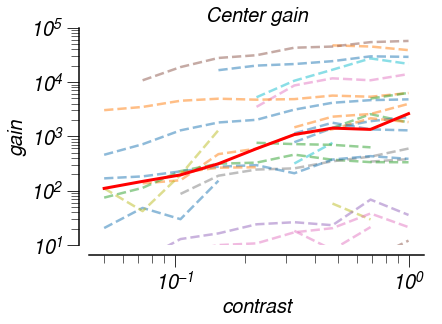

In [643]:
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_gc[i, :], '--', alpha=0.5)
gc_medians = np.nanmedian(all_gc, 0);
plt.plot(val_cons, gc_medians, 'r', linewidth=3)
plt.ylim([1e1, 1e5])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Center gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range
sns.despine(offset=10)

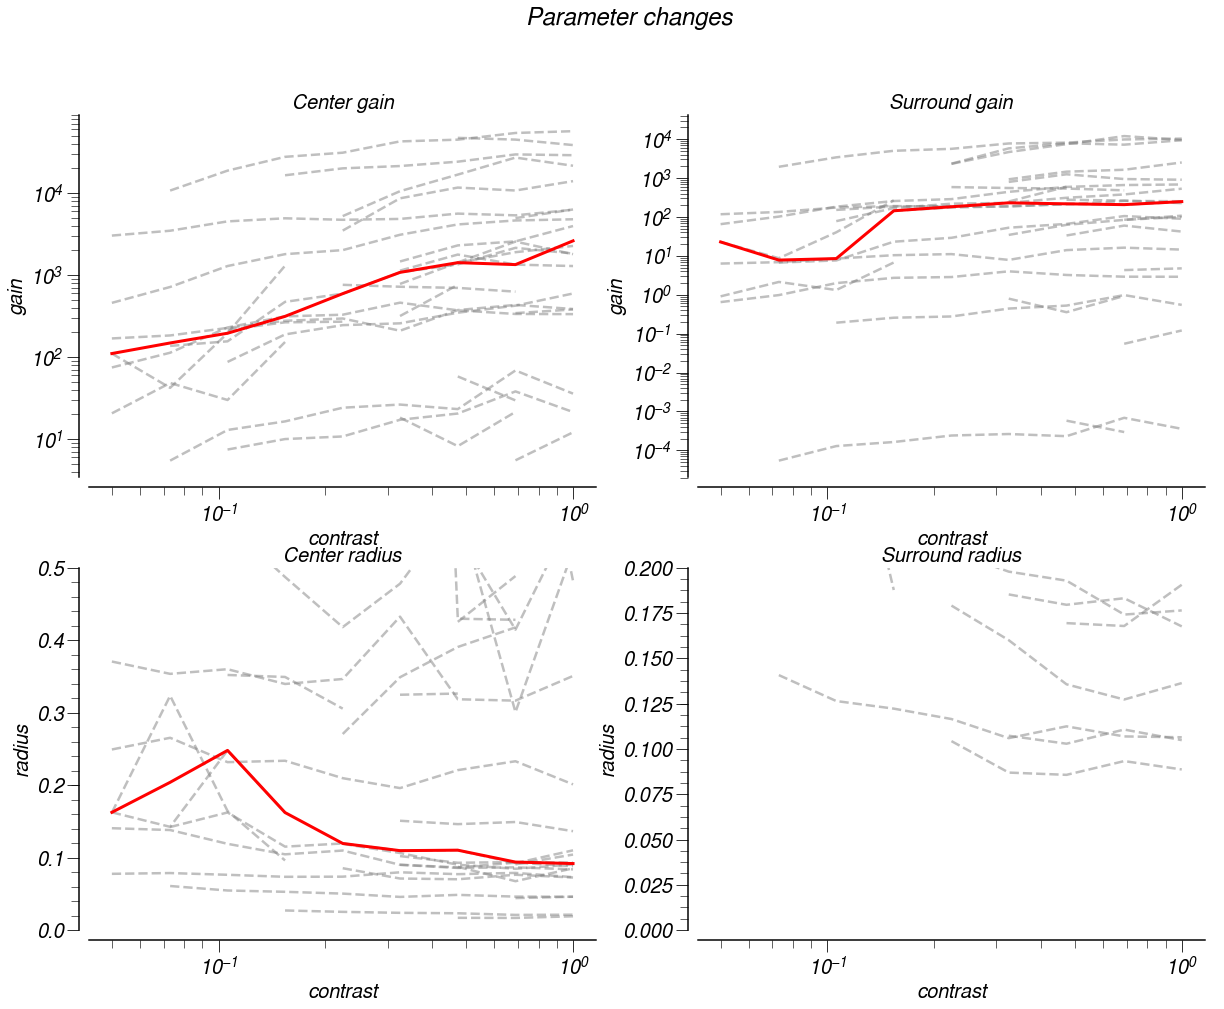

In [646]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

gray = cm.gray(0.5) # mean gray

# center gain
plt.subplot(2, 2, 1);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_gc[i, :], '--', color=gray, alpha=0.5)
gc_medians = np.nanmedian(all_gc, 0);
plt.plot(val_cons, gc_medians, 'r', linewidth=3)
# plt.ylim([0, 75])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Center gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range

# surround gain
plt.subplot(2, 2, 2);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_gs[i, :], '--', color=gray, alpha=0.5)
gs_medians = np.nanmedian(all_gs, 0);
plt.plot(val_cons, gs_medians, 'r', linewidth=3)
# plt.ylim([10e0, 10e3])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Surround gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range

# center radius
plt.subplot(2, 2, 3);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rc[i, :], '--', color=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc, 0);
plt.plot(val_cons, rc_medians, 'r', linewidth=3)
plt.ylim([0, 0.5]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround radius
plt.subplot(2, 2, 4);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rs[i, :], '--', color=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs, 0);
plt.plot(val_cons, rs_medians, 'r', linewidth=3)
plt.ylim([0, 0.2]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

f.suptitle('Parameter changes')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

# saveName = "/DoG_params%s.pdf" % loss_suff
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

The center (and, to a lesser extent, the surround) gain increases steadily with contrast. The center and surround radii seem relatively constant. These findings, though, are obscured by the different cells which contribute to each of the median values - i.e. cells 1, 3, 5 might contribute to lowest contrast, and 2, 4, 5 to the highest -- they each have their own range of values, so a "raw" median/trend might be misleading.

#### Normalized trends

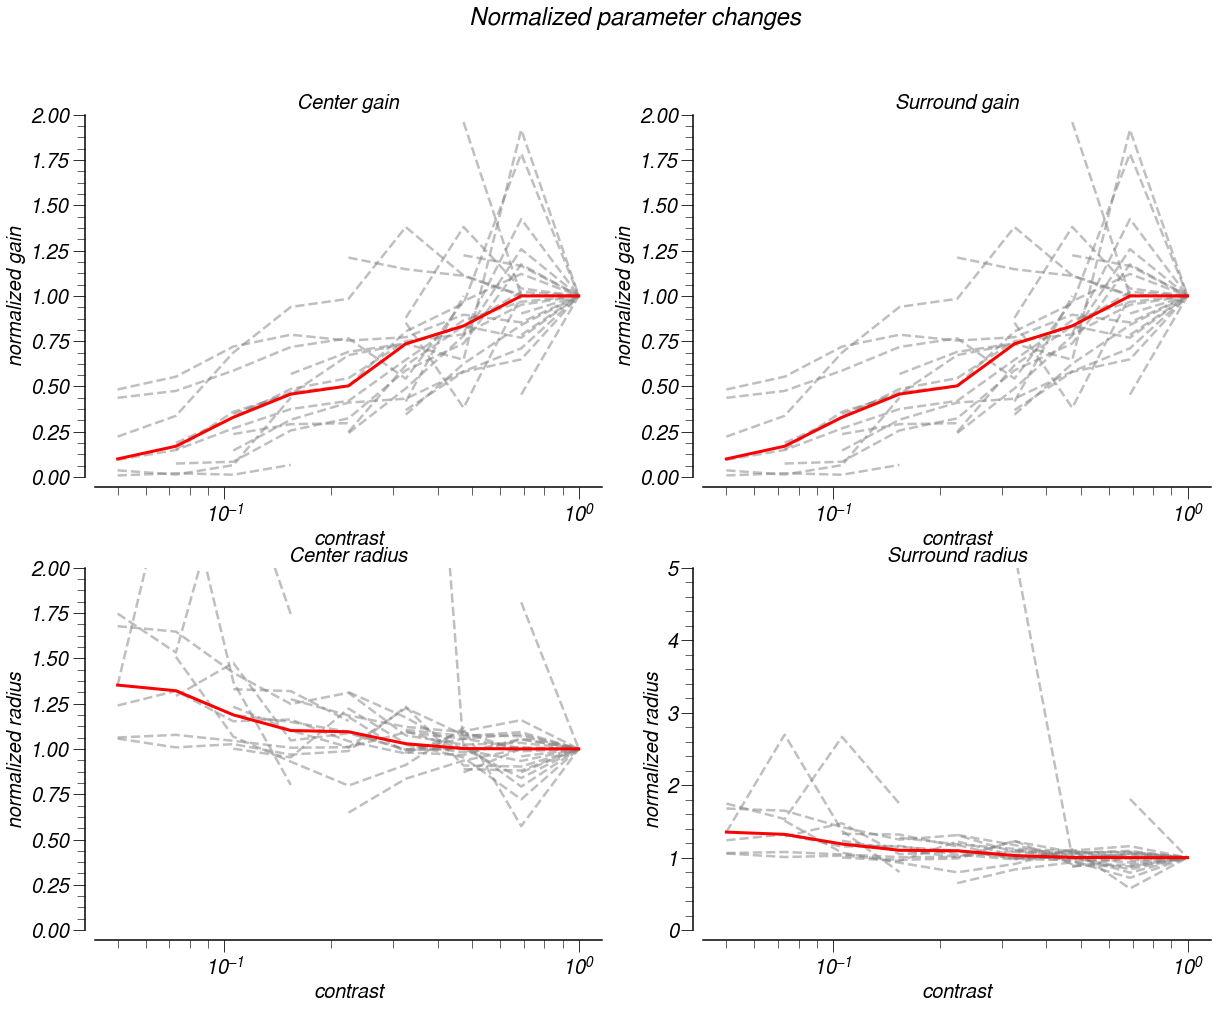

In [647]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

gray = cm.gray(0.5)

# center gain
plt.subplot(2, 2, 1);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_gc_norm[i, :], '--', c=gray, alpha=0.5)
gc_medians = np.nanmedian(all_gc_norm, 0);
plt.plot(val_cons, gc_medians, 'r', linewidth=3)
plt.ylim([0, 2])
plt.xlabel('contrast');
plt.ylabel('normalized gain')
plt.title('Center gain')
plt.xscale('log')

# surround gain
plt.subplot(2, 2, 2);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_gs_norm[i, :], '--', c=gray, alpha=0.5)
gs_medians = np.nanmedian(all_gs_norm, 0);
plt.plot(val_cons, gs_medians, 'r', linewidth=3)
plt.ylim([0, 2])
plt.xlabel('contrast');
plt.ylabel('normalized gain')
plt.title('Surround gain')
plt.xscale('log')

# center radius
plt.subplot(2, 2, 3);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rc_norm[i, :], '--', c=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc_norm, 0);
plt.plot(val_cons, rc_medians, 'r', linewidth=3)
plt.ylim([0, 2]);
plt.xlabel('contrast');
plt.ylabel('normalized radius')
plt.title('Center radius')
plt.xscale('log')

# surround radius
plt.subplot(2, 2, 4);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rs_norm[i, :], '--', c=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs_norm, 0);
plt.plot(val_cons, rs_medians, 'r', linewidth=3)
plt.ylim([0, 5]);
plt.xlabel('contrast');
plt.ylabel('normalized radius')
plt.title('Surround radius')
plt.xscale('log')

f.suptitle('Normalized parameter changes')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

# saveName = "/DoG_params_norm%s.pdf" % loss_suff
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

Now, a more clear picture emerges: gain increases with contrast, and radius - both center and surround - decrease with contrast. This is what Sach finds (plots/reports only on the radius change).

### Reproduce Sach's figure 3-3

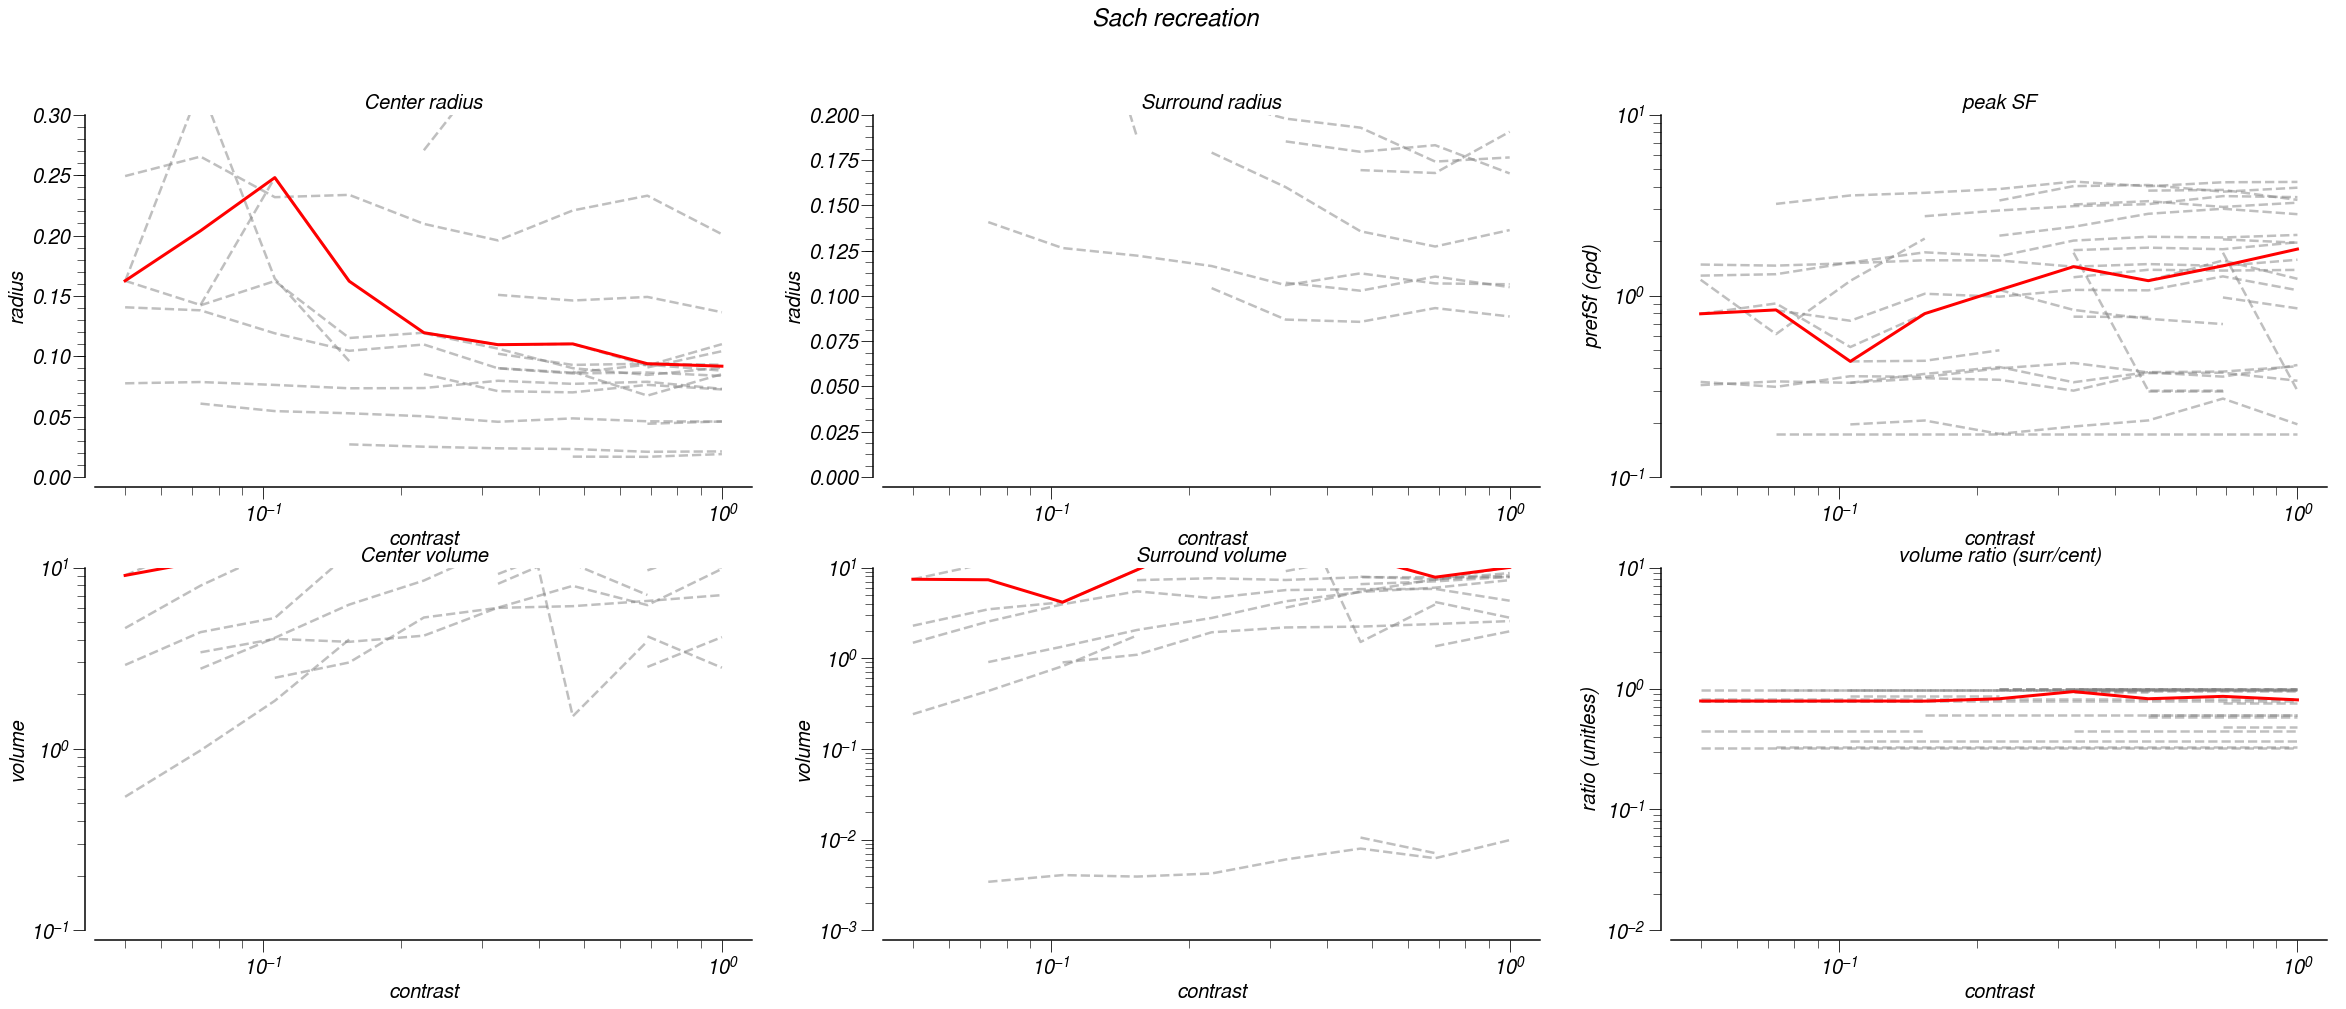

In [648]:
f, ax = plt.subplots(2, 3, figsize=(40, 15))

gray = cm.gray(0.5) # mean gray

# center radius
plt.subplot(2, 3, 1);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rc[i, :], '--', color=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc, 0);
plt.plot(val_cons, rc_medians, 'r', linewidth=3)
plt.ylim([0, 0.3]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround radius
plt.subplot(2, 3, 2);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rs[i, :], '--', color=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs, 0);
plt.plot(val_cons, rs_medians, 'r', linewidth=3)
plt.ylim([0, 0.2]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

# peak SF
plt.subplot(2, 3, 3);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_psf[i, :], '--', color=gray, alpha=0.5)
psf_medians = np.nanmedian(all_psf, 0);
plt.plot(val_cons, psf_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('prefSf (cpd)')
plt.title('peak SF')
plt.xscale('log')
plt.yscale('log')

# center volume
plt.subplot(2, 3, 4);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_volc[i, :], '--', color=gray, alpha=0.5)
vc_medians = np.nanmedian(all_volc, 0);
plt.plot(val_cons, vc_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Center volume')
plt.xscale('log')
plt.yscale('log')

# surround volume
plt.subplot(2, 3, 5);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_vols[i, :], '--', color=gray, alpha=0.5)
vs_medians = np.nanmedian(all_vols, 0);
plt.plot(val_cons, vs_medians, 'r', linewidth=3)
plt.ylim([1e-3, 1e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Surround volume')
plt.xscale('log')
plt.yscale('log')

# volume ratio
plt.subplot(2, 3, 6);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_volrat[i, :], '--', color=gray, alpha=0.5)
volrat_medians = np.nanmedian(all_volrat, 0);
plt.plot(val_cons, volrat_medians, 'r', linewidth=3)
plt.ylim([1e-2, 1e1]);
plt.xlabel('contrast');
plt.ylabel('ratio (unitless)')
plt.title('volume ratio (surr/cent)')
plt.xscale('log')
plt.yscale('log')

f.suptitle('Sach recreation')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

# saveName = "/sach%s.pdf" % loss_suff
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

Now, the normalized version

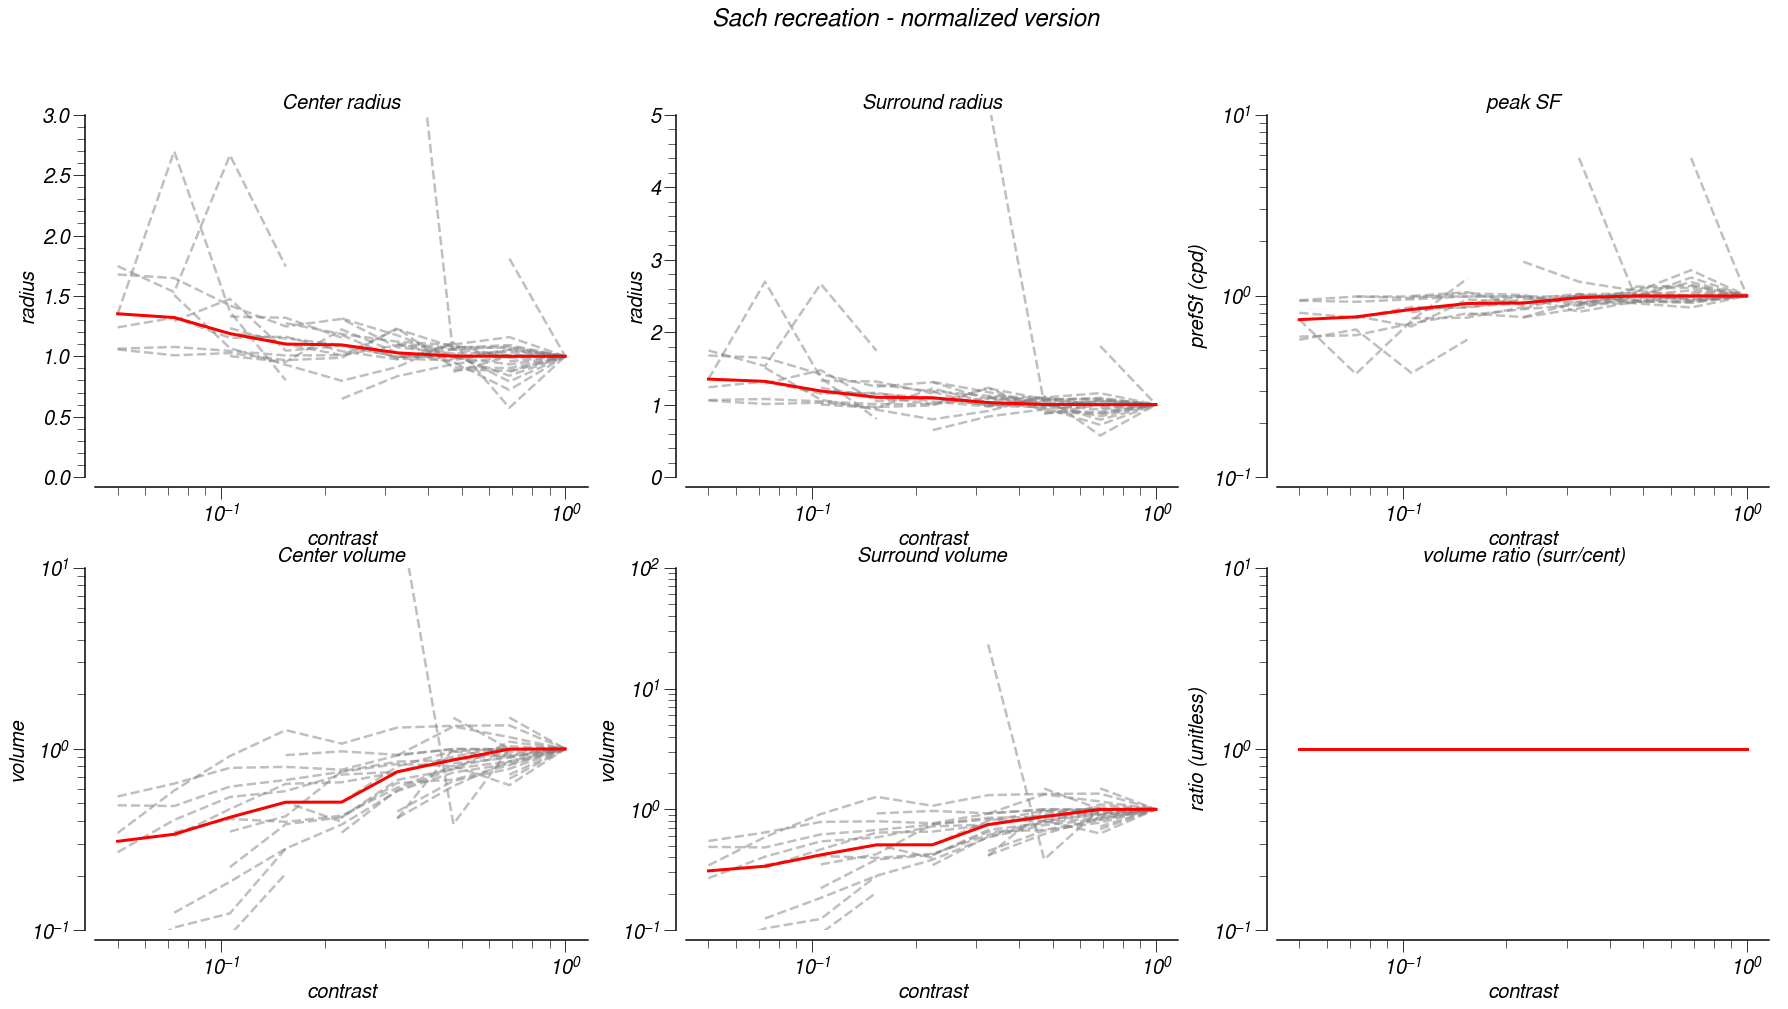

In [649]:
f, ax = plt.subplots(2, 3, figsize=(30, 15))

gray = cm.gray(0.5) # mean gray

# center freq
plt.subplot(2, 3, 1);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rc_norm[i, :], '--', color=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc_norm, 0);
plt.plot(val_cons, rc_medians, 'r', linewidth=3)
plt.ylim([0, 3]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround freq
plt.subplot(2, 3, 2);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rs_norm[i, :], '--', color=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs_norm, 0);
plt.plot(val_cons, rs_medians, 'r', linewidth=3)
plt.ylim([0, 5]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

# peak SF
plt.subplot(2, 3, 3);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_psf_norm[i, :], '--', color=gray, alpha=0.5)
psf_medians = np.nanmedian(all_psf_norm, 0);
plt.plot(val_cons, psf_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('prefSf (cpd)')
plt.title('peak SF')
plt.xscale('log')
plt.yscale('log')

# center volume
plt.subplot(2, 3, 4);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_volc_norm[i, :], '--', color=gray, alpha=0.5)
vc_medians = np.nanmedian(all_volc_norm, 0);
plt.plot(val_cons, vc_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Center volume')
plt.xscale('log')
plt.yscale('log')

# surround volume
plt.subplot(2, 3, 5);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_vols_norm[i, :], '--', color=gray, alpha=0.5)
vs_medians = np.nanmedian(all_vols_norm, 0);
plt.plot(val_cons, vs_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e2]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Surround volume')
plt.xscale('log')
plt.yscale('log')

# volume ratio
plt.subplot(2, 3, 6);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_volrat_norm[i, :], '--', color=gray, alpha=0.5)
volrat_medians = np.nanmedian(all_volrat_norm, 0);
plt.plot(val_cons, volrat_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('ratio (unitless)')
plt.title('volume ratio (surr/cent)')
plt.xscale('log')
plt.yscale('log')

f.suptitle('Sach recreation - normalized version')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

# saveName = "/sach_norm%s.pdf" % loss_suff
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

### Let's plot ratios!

Let's make scatter plots of each the ratios for each cell's tuning - evaluated at highest/lowest valid contrasts

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


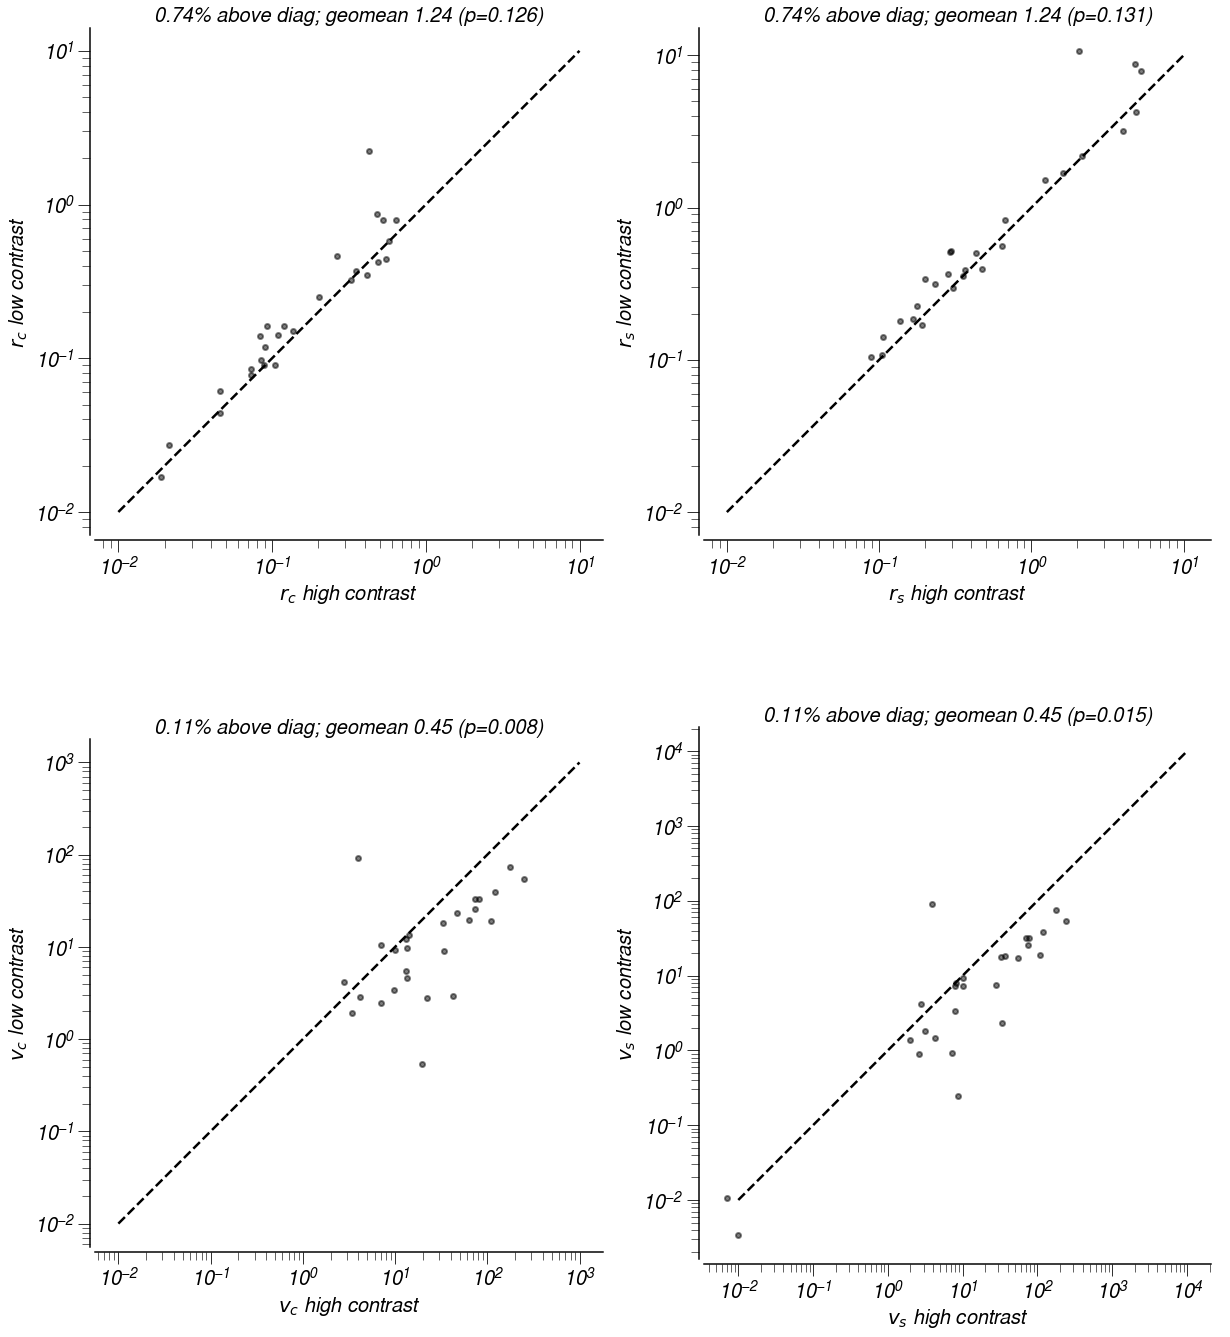

In [650]:
ctrR_rats = np.nan*np.zeros((n_cells, ));
surR_rats = np.nan*np.zeros((n_cells, ));
ctrVol_rats = np.nan*np.zeros((n_cells, ));
surVol_rats = np.nan*np.zeros((n_cells, ));
# also save the indices into all_* for later analysis
extremaInds = np.zeros((n_cells, 2), dtype='int32');

nr, nc = 2, 2;
f, ax = plt.subplots(nr, nc, figsize=(10*nc, 12*nr))

for i in range(n_cells):
    # take into account that not all cells are necessarily in descrFits, but all will be in all[Con[[byDisp]]][sf][disp]
    ii = val_cells[i]

    ### center radius - and generally, which contrasts are valid (i.e. varExpl above threshold)
    curr_radii = all_rc[ii, :];
    # first, label/extras:
    if i == 0:
        ax[0, 0].set_xlabel('$r_c$ high contrast')
        ax[0, 0].set_ylabel('$r_c$ low contrast')
        ax[0, 0].plot([1e-2, 1e1], [1e-2, 1e1], 'k--')
        sns.despine(offset=5, ax=ax[0, 0])
    # now, get the actual data
    non_nan = np.where(~np.isnan(curr_radii))[0];
    if len(non_nan) < 2:
        continue;
    extrema_ind = [non_nan[0], non_nan[-1]] # low con, high con
    extremaInds[ii, :] = extrema_ind
    low_r, high_r = curr_radii[extrema_ind[0]], curr_radii[extrema_ind[1]]
    ctrR_rats[ii] = np.divide(low_r, high_r);
    ax[0, 0].plot(high_r, low_r, 'ko', alpha=0.5);

    ### surround radius
    curr_radii = all_rs[ii, :];
    # first, label/extras:
    if i == 0:
        ax[0, 1].set_xlabel('$r_s$ high contrast')
        ax[0, 1].set_ylabel('$r_s$ low contrast')
        ax[0, 1].plot([1e-2, 1e1], [1e-2, 1e1], 'k--')
        sns.despine(offset=5, ax=ax[0, 1])
    # now, get the actual data
    low_r, high_r = curr_radii[extrema_ind[0]], curr_radii[extrema_ind[1]]
    surR_rats[ii] = np.divide(low_r, high_r);
    ax[0, 1].plot(high_r, low_r, 'ko', alpha=0.5);
    
    ### center volume
    curr_vol = all_volc[ii, :];
    # first, label/extras:
    if i == 0:
        ax[1, 0].set_xlabel('$v_c$ high contrast')
        ax[1, 0].set_ylabel('$v_c$ low contrast')
        ax[1, 0].plot([1e-2, 1e3], [1e-2, 1e3], 'k--')
        sns.despine(offset=5, ax=ax[1, 0])
    # now, get the actual data
    low_v, high_v = curr_vol[extrema_ind[0]], curr_vol[extrema_ind[1]]
    ctrVol_rats[ii] = np.divide(low_v, high_v);
    ax[1, 0].plot(high_v, low_v, 'ko', alpha=0.5);
    
    ### surround volume
    curr_vol = all_vols[ii, :];
    # first, label/extras:
    if i == 0:
        ax[1, 1].set_xlabel('$v_s$ high contrast')
        ax[1, 1].set_ylabel('$v_s$ low contrast')
        ax[1, 1].plot([1e-2, 1e4], [1e-2, 1e4], 'k--')
        sns.despine(offset=5, ax=ax[1, 1])
    # now, get the actual data
    low_v, high_v = curr_vol[extrema_ind[0]], curr_vol[extrema_ind[1]]
    surVol_rats[ii] = np.divide(low_v, high_v);
    ax[1, 1].plot(high_v, low_v, 'ko', alpha=0.5);

### general plotting
for inds in itertools.product(range(nr), range(nc)):
    ax[inds].set_xscale('log')
    ax[inds].set_yscale('log')
    ax[inds].axis('square')
    
### now, titles, some analysis
## center radius
nn_inds = np.where(~np.isnan(ctrR_rats));
non_nan = ctrR_rats[nn_inds]
ctrR_gt1 = sum(ctrR_rats>1);
# - get pval on paired t-test
idx_low = zip(range(n_cells), extremaInds[:, 0])
low_cr = np.array([all_rc[x] for x in idx_low])
idx_high = zip(range(n_cells), extremaInds[:, 1])
high_cr = np.array([all_rc[x] for x in idx_high])
pval_cr = paired_ttest(low_cr[nn_inds], high_cr[nn_inds])
# now set title
ax[0, 0].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (ctrR_gt1/len(non_nan), geomean(non_nan), pval_cr.pvalue));

## surround radius
non_nan = surR_rats[~np.isnan(surR_rats)]
surR_gt1 = sum(surR_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_sr = np.array([all_rs[x] for x in idx_low])
high_sr = np.array([all_rs[x] for x in idx_high])
pval_sr = paired_ttest(low_sr[nn_inds], high_sr[nn_inds])
# now set title
ax[0, 1].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (surR_gt1/len(non_nan), geomean(non_nan), pval_sr.pvalue));

## center vol
non_nan = ctrVol_rats[~np.isnan(ctrVol_rats)]
ctrVol_gt1 = sum(ctrVol_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_vc = np.array([all_volc[x] for x in idx_low])
high_vc = np.array([all_volc[x] for x in idx_high])
pval_vc = paired_ttest(low_vc[nn_inds], high_vc[nn_inds])
ax[1, 0].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (ctrVol_gt1/len(non_nan), geomean(non_nan), pval_vc.pvalue));

## surround vol
non_nan = surVol_rats[~np.isnan(surVol_rats)]
surVol_gt1 = sum(surVol_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_vs = np.array([all_vols[x] for x in idx_low])
high_vs = np.array([all_vols[x] for x in idx_high])
pval_vs = paired_ttest(low_vs[nn_inds], high_vs[nn_inds])
ax[1, 1].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (surVol_gt1/len(non_nan), geomean(non_nan), pval_vs.pvalue));
